## Using CAVs generated from jazz instruction textbooks

In [23]:
import os
from random import shuffle
from itertools import groupby

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import yaml
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from torch.utils.data import DataLoader, Dataset
from pretty_midi import PrettyMIDI, Instrument, Note
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import deep_pianist_identification.plotting as plotting
from deep_pianist_identification import utils
from deep_pianist_identification.dataloader import remove_bad_clips_from_batch
from deep_pianist_identification.extractors import get_piano_roll
from deep_pianist_identification.training import TrainModule, DEFAULT_CONFIG

In [2]:
SPLIT_PATH = os.path.join(utils.get_project_root(), "references/_unsupervised_resources/voicings/midi_split/")

In [3]:
utils.seed_everything(utils.SEED)

Defining dataloaders for CAV MIDI files

In [4]:
class VoicingLoaderReal(Dataset):
    def __init__(
        self, 
        cav_number, 
        n_clips: int = None,
        transpose_range = 6
    ):
        super().__init__()
        self.transpose_range = transpose_range
        self.n_clips = n_clips
        self.cav_midis = self.get_midi_paths(cav_number)
        self.midis = self.create_midi()

    @staticmethod
    def get_midi_paths(cav_number):
        cav_path = os.path.join(SPLIT_PATH, f"{cav_number}_cav")
        assert os.path.isdir(cav_path)
        cavs = [os.path.join(cav_path, i) for i in os.listdir(cav_path) if i.endswith('mid')]
        return cavs

    def _create_midi(self, cav_midi_path):
        pm = PrettyMIDI(cav_midi_path)
        # Replacing velocity with 1.0
        lhand = [(i.start, i.end, i.pitch, 1.0) for i in pm.instruments[1].notes]
        rhand = [(i.start, i.end, i.pitch, 1.0) for i in pm.instruments[0].notes]
        # Take top note from each left hand if we have multiple voices
        newlhand = []
        for key, group in groupby(lhand, lambda x: x[0]):
            group = list(group)
            if len(group) > 1:
                # Get the highest pitch
                sort = sorted(group, key=lambda x: x[2])
                rhand.extend(sort[1:])
                newlhand.append(sort[0])
        lhand = newlhand
        
        rhand = sorted(rhand, key=lambda x: (x[0], x[2]))
        rhand_grp = [list(i[1]) for i in groupby(rhand, lambda x: x[0])]
        
        inverted_rhands = {i: [] for i in range(len(rhand_grp[0]) - 1)}
        for inversion in inverted_rhands.keys():
            for grp in rhand_grp:
                to_invert = sorted(grp, key=lambda x: x[2])[:inversion + 1]
                inverted = [(i[0], i[1], i[2] + 12, i[3]) for i in to_invert]
                combined = inverted + grp[inversion + 1:]
                inverted_rhands[inversion].extend(sorted(combined, key=lambda x: x[2]))
                      
        to_compute = [rhand, * list(inverted_rhands.values())]
        # Iterating over all inversions
        all_rolls = []
        for rhands in to_compute:
            for transp in range(-self.transpose_range, self.transpose_range + 1):
                for include_lh in [False]:
                    if include_lh:
                        comb = sorted(rhands + lhand, key=lambda x: x[0])
                    else:
                        comb = sorted(rhands, key=lambda x: x[0])
                    onset_grps = [list(i[1]) for i in groupby(comb, lambda x: x[0])]
                    spacer = np.linspace(0, utils.CLIP_LENGTH, len(onset_grps))
                    fmt = []
                    for start, end, grp in zip(spacer, spacer[1:], onset_grps):
                        fmt_grp = [(start, end, note[2] + transp, note[3]) for note in grp]
                        fmt.extend(fmt_grp)
                    all_rolls.append(get_piano_roll(fmt))
        return all_rolls
        
    def create_midi(self):
        # TODO: maybe we set a cap on the number of MIDIs to use per concept?
        with Parallel(n_jobs=-1, verbose=1) as par:
            midis = par(delayed(self._create_midi)(mid) for mid in self.cav_midis)
            midis = [m for ms in midis for m in ms]
        # midis = [list(self._create_midi(midi)) for midi in self.cav_midis]
        if self.n_clips is not None:
            shuffle(midis)
            midis = midis[:self.n_clips]
        return midis

    def __len__(self):
        return len(self.midis)
    
    def __getitem__(self, idx: int) -> tuple[np.ndarray, int]:
        # Return the MIDI piano roll and the class index (i.e., True)
        return np.expand_dims(self.midis[idx], 0), 1


class VoicingLoaderFake(VoicingLoaderReal):
    def __init__(
        self, 
        avoid_cav_number: int, 
        n_clips: int,
        transpose_range: int = 6
    ):
        super().__init__(cav_number=avoid_cav_number, n_clips=n_clips, transpose_range=transpose_range)
    
    @staticmethod
    def get_midi_paths(cav_number):
        fmt_cav_paths = [os.path.join(SPLIT_PATH, i) for i in os.listdir(SPLIT_PATH) if i != f"{cav_number}_cav"]
        all_cavs = []
        for path in fmt_cav_paths:
            all_cavs.extend([os.path.join(SPLIT_PATH, path, i) for i in os.listdir(path) if i.endswith('.mid')])
        shuffle(all_cavs)
        return all_cavs

    # def create_midi(self):
    #     all_midis = []
    #     midis_used = []
    #     # Doing this means that we don't have to create more MIDI files than we actually need
    #     for midi in self.cav_midis:
    #         created = list(self._create_midi(midi))
    #         all_midis.extend(created)
    #         if len(all_midis) > self.n_clips:
    #             break
    #         midis_used.append(midi)
    #     self.cav_midis = midis_used
    #     return all_midis[:self.n_clips]
        
    def __len__(self):
        return self.n_clips

    def __getitem__(self, idx: int) -> tuple[np.ndarray, int]:
        # Return the MIDI piano roll and the class index (i.e., False)
        return np.expand_dims(self.midis[idx], 0), 0


In [5]:
# Create some fake datasets for testing
real = DataLoader(
    VoicingLoaderReal(15), 
    shuffle=True, 
    batch_size=10,
    drop_last=False
)
fake = DataLoader(
    VoicingLoaderFake(15, n_clips=len(real.dataset)), 
    shuffle=True, 
    batch_size=10,
    drop_last=False
)
# Both dataloaders should have the same length
assert len(real.dataset) == len(fake.dataset)
# Should be no filepaths shared between both dataloaders
assert len(list(set(real.dataset.cav_midis) & set(fake.dataset.cav_midis))) == 0
print(len(real.dataset), len(fake.dataset))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    8.4s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s


1560 1560


[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:   14.2s finished


Load in the model

In [6]:
# Define the name of the model we're going to wrap
MODEL_NAME = "disentangle-jtd+pijama-resnet18-mask30concept3-augment50-noattention-avgpool-onefc"

In [7]:
# Load in the config path for the model
cfg_path = os.path.join(utils.get_project_root(), 'config', 'disentangle-resnet-channel', MODEL_NAME + '.yaml')
cfg = yaml.safe_load(open(cfg_path))
# Replace any non-existing keys with their default value
for k, v in DEFAULT_CONFIG.items():
    if k not in cfg.keys():
        cfg[k] = v

In [8]:
tm = TrainModule(**cfg)
disentangle_net = tm.model.to(utils.DEVICE)
disentangle_net.eval()
harmony_concept = disentangle_net.harmony_concept

2024-10-28 17:27:33.726 | DEBUG    | deep_pianist_identification.training:__init__:107 - Model will be trained with 20 classes!
2024-10-28 17:27:33.727 | DEBUG    | deep_pianist_identification.training:__init__:110 - Initialising model...
2024-10-28 17:27:33.727 | DEBUG    | deep_pianist_identification.training:__init__:111 - Using encoder disentangle with parameters {'use_gru': False, 'use_masking': True, 'use_attention': False, 'mask_probability': 0.3, 'max_masked_concepts': 3, '_use_resnet': True, '_resnet_cls': 'resnet18', 'use_2fc': False, 'pool_type': 'avg'}
2024-10-28 17:27:33.728 | DEBUG    | deep_pianist_identification.encoders.disentangle:__init__:97 - Using ResNet class resnet18 as concept encoder!
2024-10-28 17:27:34.315 | INFO     | deep_pianist_identification.encoders.disentangle:create_fc_layers:144 - Using one FC layer with I/O (512>>20)
2024-10-28 17:27:34.336 | DEBUG    | deep_pianist_identification.training:__init__:118 - Model parameters: 44691220
2024-10-28 17:27:3

### Create the explainer class

In [9]:
SCALER = StandardScaler()


class Explainer:
    def __init__(self, cav_idx: int, model, n_clips: int = None, transpose_range: int = 6):
        # Create the dataloaders for the desired CAV
        self.cav_idx = cav_idx
        self.real = DataLoader(
            VoicingLoaderReal(
                self.cav_idx, 
                n_clips=n_clips, 
                transpose_range=transpose_range
            ), 
            shuffle=True, 
            batch_size=10,
            drop_last=False
        )
        self.fake = DataLoader(
            VoicingLoaderFake(
                self.cav_idx, 
                n_clips=len(self.real.dataset),
                transpose_range=transpose_range
            ), 
            shuffle=True, 
            batch_size=10,
            drop_last=False
        )
        assert len(self.real.dataset) == len(self.fake.dataset)
        self.model = model
        self.predictor = LogisticRegression(random_state=utils.SEED, max_iter=10000)
        self.class_centroid = None
        self.coefs = None

    def get_embeds(self):
        real_embeds, fake_embeds = [], []
        for (real_batch, _), (fake_batch, _) in zip(self.real, self.fake):
            # Create both sets of embeddings
            with torch.no_grad():
                # Through the model
                real_embed = self.model(real_batch.to(utils.DEVICE)).squeeze(1)
                fake_embed = self.model(fake_batch.to(utils.DEVICE)).squeeze(1)
                # Append to the list
                real_embeds.append(real_embed.cpu().numpy())
                fake_embeds.append(fake_embed.cpu().numpy())
        return np.concatenate(real_embeds), np.concatenate(fake_embeds)

    def fit(self):
        # Get embeddings from the model
        real_embeds, fake_embeds = self.get_embeds()
        self.class_centroid = real_embeds.mean(axis=0)
        # Create arrays of targets with same shape as embeddings
        real_targets, fake_targets = np.ones(real_embeds.shape[0]), np.zeros(fake_embeds.shape[0])
        # Combine both real/fake features and targets into single matrix
        X = np.vstack([real_embeds, fake_embeds])
        y = np.hstack([real_targets, fake_targets])
        # Scale the features
        X = SCALER.fit_transform(X)
        # Create the model
        self.predictor.fit(X, y)
        acc = self.predictor.score(X, y)
        print(f'Accuracy for CAV {self.cav_idx}: ', acc) 
        # Extract coefficients - these are our CAVs
        self.coefs = self.predictor.coef_

In [10]:
# Get CAVs for all concepts
explainers = []
for idx in tqdm(range(1, 21), desc='Creating all CAVs: '):
    explain = Explainer(idx, harmony_concept)
    explain.fit()
    explainers.append(explain)
cavs = np.concatenate([i.coefs for i in explainers])

Creating all CAVs:   0%|          | 0/20 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   16.3s finished


Accuracy for CAV 1:  0.9967948717948718


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 182 out of 182 | elapsed:   14.6s finished


Accuracy for CAV 2:  0.981216457960644


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:   13.3s finished


Accuracy for CAV 3:  0.9893162393162394


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:   13.8s finished


Accuracy for CAV 4:  0.9935897435897436


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   18.9s finished


Accuracy for CAV 5:  0.9980769230769231


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 193 out of 193 | elapsed:   15.4s finished


Accuracy for CAV 6:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:   14.0s finished


Accuracy for CAV 7:  0.9978632478632479


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:   16.0s finished


Accuracy for CAV 8:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:   14.5s finished


Accuracy for CAV 9:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:   16.1s finished


Accuracy for CAV 10:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:   14.8s finished


Accuracy for CAV 11:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   14.5s finished


Accuracy for CAV 12:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 194 out of 194 | elapsed:   14.9s finished


Accuracy for CAV 13:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    0.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:   12.1s finished


Accuracy for CAV 14:  0.9996794871794872


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    0.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:   13.7s finished


Accuracy for CAV 15:  0.9977564102564103


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:   15.6s finished


Accuracy for CAV 16:  0.9925213675213675


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  24 | elapsed:    0.7s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:   12.0s finished


Accuracy for CAV 17:  0.9971153846153846


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 188 out of 188 | elapsed:   15.3s finished


Accuracy for CAV 18:  0.9990384615384615


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 195 out of 195 | elapsed:   15.0s finished


Accuracy for CAV 19:  1.0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   14.3s finished


Accuracy for CAV 20:  1.0


Get clips for all pianists from the validation dataset

In [11]:
valid_loader = DataLoader(
    tm.dataloader_cls(
        'validation',
        classify_dataset=tm.classify_dataset,
        data_split_dir=tm.data_split_dir,
        **tm.test_dataset_cfg
    ),
    batch_size=tm.batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=remove_bad_clips_from_batch
)

In [12]:
actual_embeds, actual_targets, X_features, track_names = [], [], [], []
for loader in [valid_loader, tm.test_loader]:
    # Create list of all indexes
    indices = [list(range(l, l + loader.batch_size)) for l in range(0, len(loader.dataset), loader.batch_size)]
    # Iterate over all indexes
    for idxs in tqdm(indices, desc="Getting embeddings"):
        # Subset the indexes so we don't end up exceeding the number of clips
        idxs = [i for i in idxs if i < len(loader.dataset)]
        rolls, targets, paths = [], [], []
        # Now we actually use the __getitem__ call
        for n, i in enumerate(idxs):
            temp = loader.dataset.__getitem__(i)
            # replaces collate_fn to remove bad items from batch
            if temp is not None:
                r, t, p = temp
                rolls.append(r)
                targets.append(t) 
                tn, _, _, clip_idx = loader.dataset.clips[i]
                assert tn.split(os.path.sep)[-1] == p
                paths.append(os.path.sep.join([tn.split(os.path.sep)[-2], p, f'clip_{str(clip_idx).zfill(3)}.mid'])) 
        assert len(rolls) == len(targets) == len(paths)
        # Convert into tensors
        roll = torch.tensor(np.array(rolls))
        target = torch.tensor(np.array(targets))
        # Get the required concept from the piano roll (harmony, here)
        harmony_roll = roll[:, 1, :, :].unsqueeze(1)
        # Call the forward function without gradient computation
        with torch.no_grad():
            harm_embed = harmony_concept(harmony_roll.to(utils.DEVICE)).squeeze(1)
        # Store original data        
        track_names.extend(paths)
        X_features.append(harmony_roll)
        # Store layer activations
        actual_embeds.append(harm_embed.cpu().numpy())
        # Store target indexes
        actual_targets.append(target.cpu().numpy())

Getting embeddings:   0%|          | 0/45 [00:00<?, ?it/s]

2024-10-28 17:33:38.095 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/pijama/alleng-dancingmysticpoetsatdawn-unaccompanied-xxxx-8jyumey5 (clip 0) after retrying 100 times. Skipping this clip! Error message: no notes present in clip when extracting harmony.


Getting embeddings:   0%|          | 0/51 [00:00<?, ?it/s]

2024-10-28 17:34:09.287 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/pijama/jarrettk-pt-unaccompanied-xxxx-zeyo5k6v (clip 16) after retrying 100 times. Skipping this clip! Error message: no notes present in clip when extracting melody.
2024-10-28 17:34:11.584 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967 (clip 1) after retrying 100 times. Skipping this clip! Error message: no notes present in clip when extracting harmony.
2024-10-28 17:34:11.711 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967 (clip 2) after retrying 100 times. Skipping this clip! Erro

In [14]:
actual_embed_arr = np.concatenate(actual_embeds)
actual_target_arr = np.concatenate(actual_targets)
print(actual_embed_arr.shape, actual_target_arr.shape)

(1894, 512) (1894,)


Compute dot-product similarity of embeddings vs CAV

In [15]:
dotted = actual_embed_arr @ cavs.T
# (N_clips, N_cavs)
dotted.shape

(1894, 20)

Compute multinomial logistic regression with CAV sensitivity as predictor

In [16]:
multi_md = LogisticRegression(random_state=utils.SEED, max_iter=10000)
multi_md.fit(dotted, actual_target_arr)
multi_acc = multi_md.score(dotted, actual_target_arr)
print('Accuracy of multinomial model: ', multi_acc)

Accuracy of multinomial model:  0.6214361140443506


In [17]:
cav_class_coefs = multi_md.coef_

Plot a heatmap with class and CAV labels

In [18]:
yticklabels = np.array(list(tm.class_mapping.values()))

In [19]:
# Sorting performers by birth year
birth_years = np.array([1934, 1930, 1929, 1970, 1934, 1941, 1933, 1957, 1918, 1941, 1928, 1945, 1943, 1928, 1938, 1925, 1941, 1912, 1917, 1930])
sorters = np.argsort(birth_years)

In [20]:
csv_loc = os.path.join(utils.get_project_root(), 'references/_unsupervised_resources/voicings/cav_mapping.csv')
mapping = pd.read_csv(csv_loc, index_col=1)
xticklabels = np.array([row.iloc[0] for i, row in mapping.iterrows()])

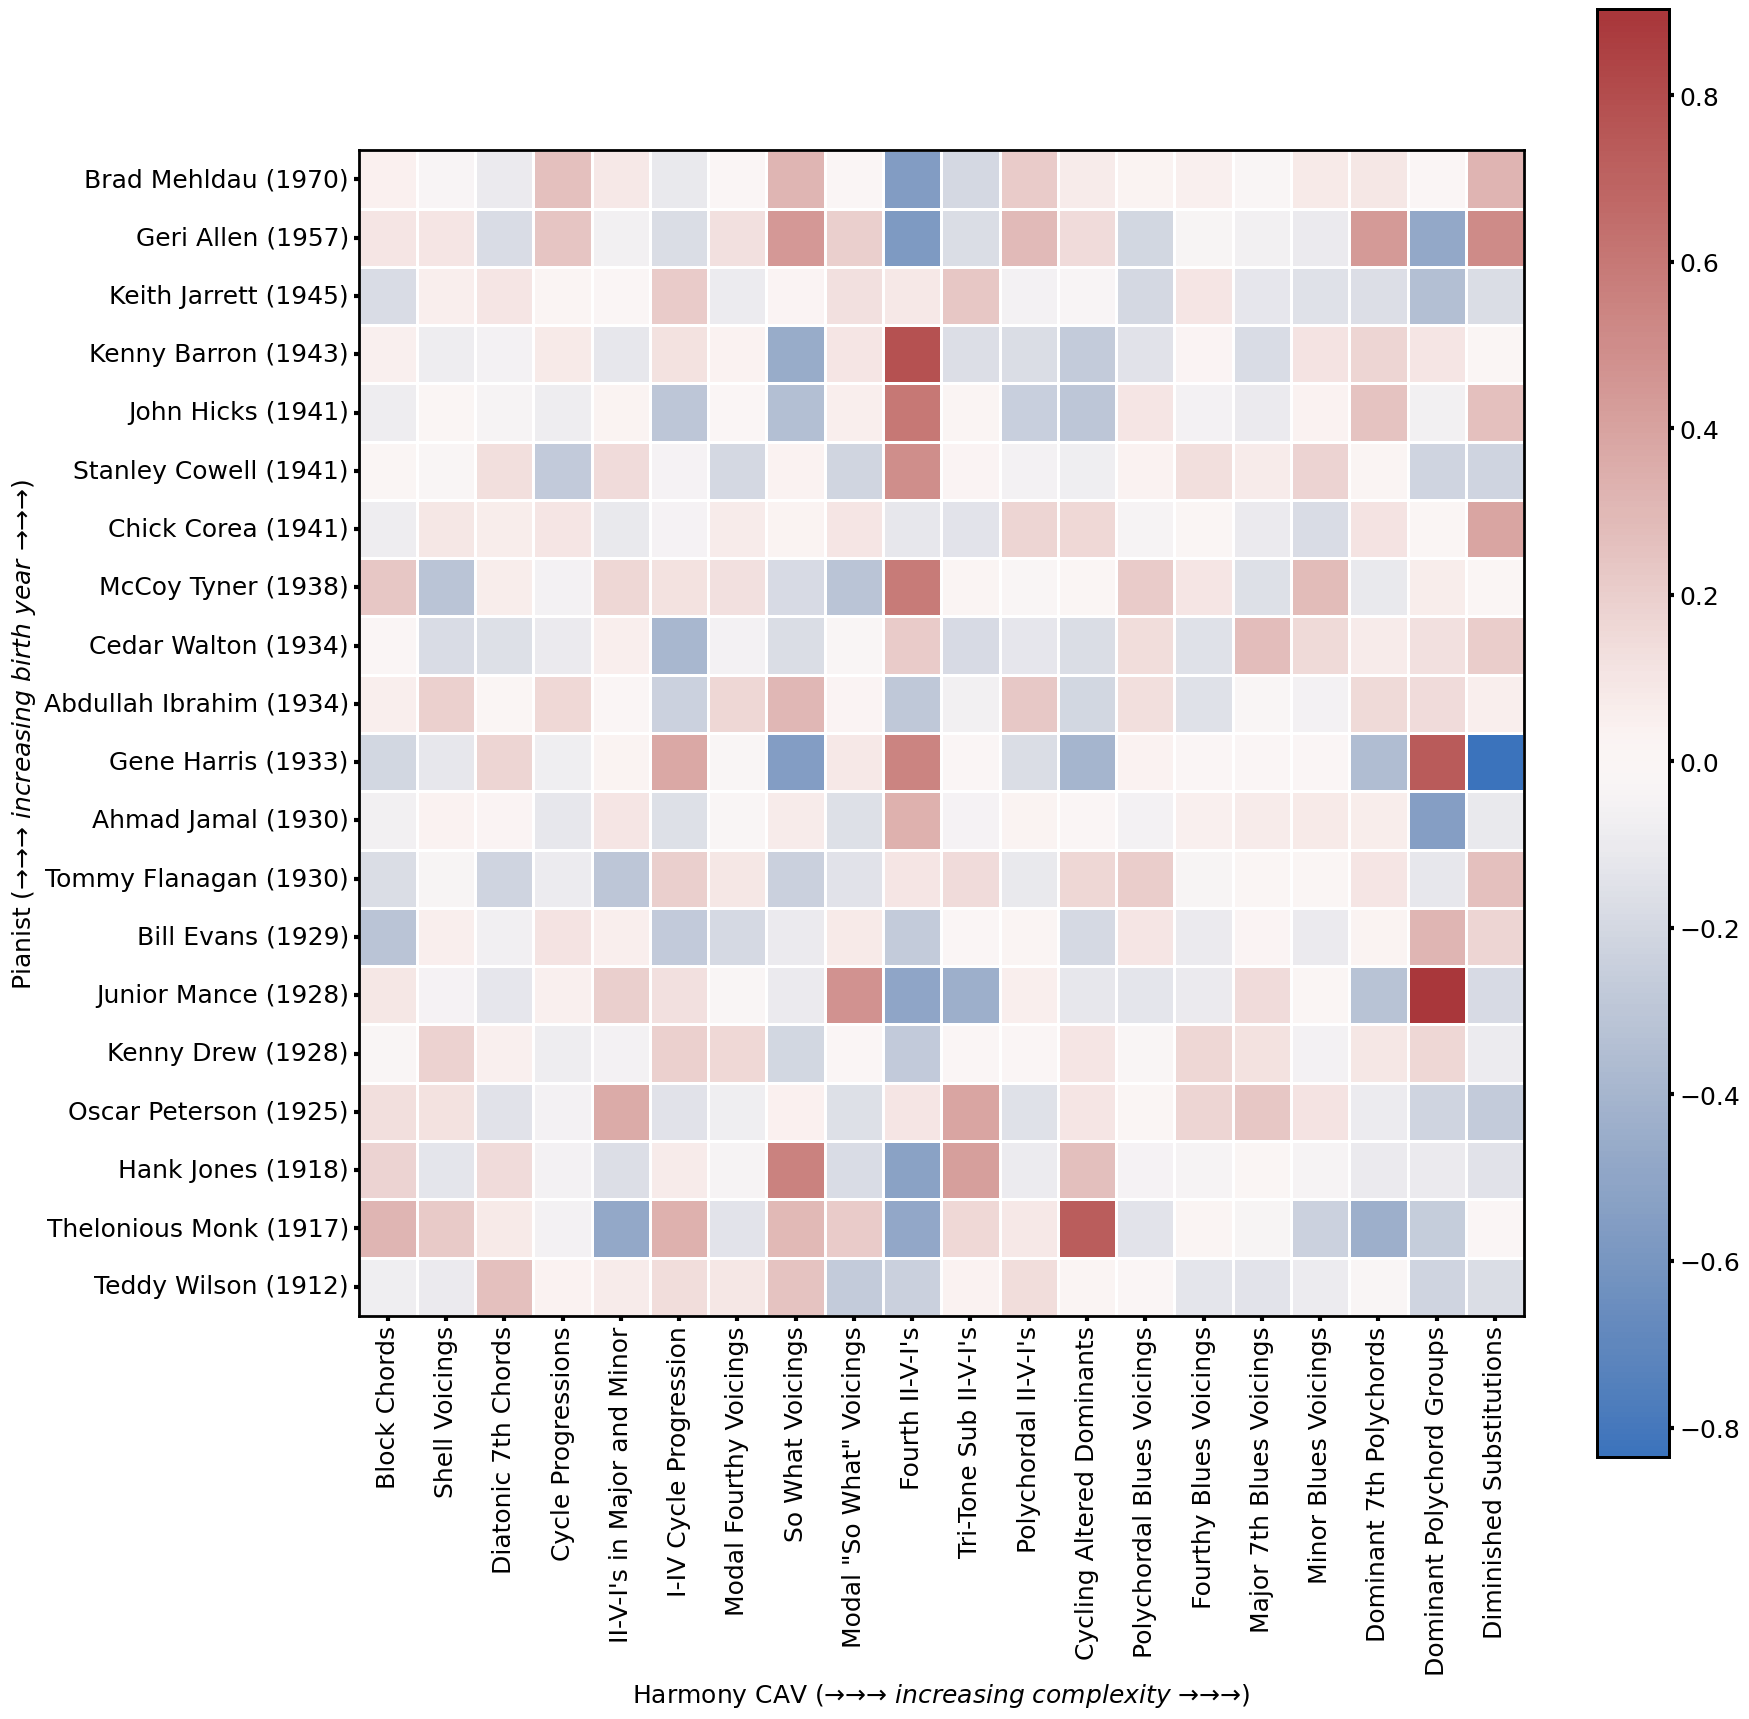

In [24]:
plt.rcParams.update({'font.size': plotting.FONTSIZE})
fig, ax = plt.subplots(1, 1, figsize=(plotting.WIDTH, plotting.WIDTH))
g = sns.heatmap(
    cav_class_coefs[sorters, :], xticklabels=xticklabels, square=True,
    yticklabels=[f'{p} ({b})' for p, b in zip(yticklabels[sorters], birth_years[sorters])], 
    cmap="vlag", linecolor=plotting.WHITE, 
    linewidth=plotting.LINEWIDTH // 2, ax=ax, center=0.
)
for a in [ax, ax.figure.axes[-1]]:
    for spine in a.spines.values():
        spine.set_visible(True)
        spine.set_color(plotting.BLACK)
        spine.set_linewidth(plotting.LINEWIDTH)
    plt.setp(a.spines.values(), linewidth=plotting.LINEWIDTH, color=plotting.BLACK)
    a.tick_params(axis='both', width=plotting.TICKWIDTH, color=plotting.BLACK)
# Set axis and tick thickness
ax.invert_yaxis()
ax.set(xlabel="Harmony CAV (→→→ $increasing$ $complexity$ →→→)", ylabel="Pianist (→→→ $increasing$ $birth$ $year$ →→→)")

plt.show()

Plot areas of the original heatmap where the CAV is activated

In [25]:
kernels = []
for i1 in range(0, utils.PIANO_KEYS):
    i1_u = i1 + 24
    if i1_u > 88:
        break
    for i2 in range(0, utils.CLIP_LENGTH):
        i2_u = i2 + 5
        if i2_u > 30:
            break
        kernels.append([(i1, i1_u), (i2, i2_u)])

Block Chords pijama/petersono-makinwhoopeelive-unaccompanied-xxxx-i3xns7vr/clip_003.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Block Chords pijama/ibrahima-forcoltranept-unaccompanied-xxxx-pdygnkxw/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Block Chords pijama/petersono-makinwhoopeelive-unaccompanied-xxxx-i3xns7vr/clip_004.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

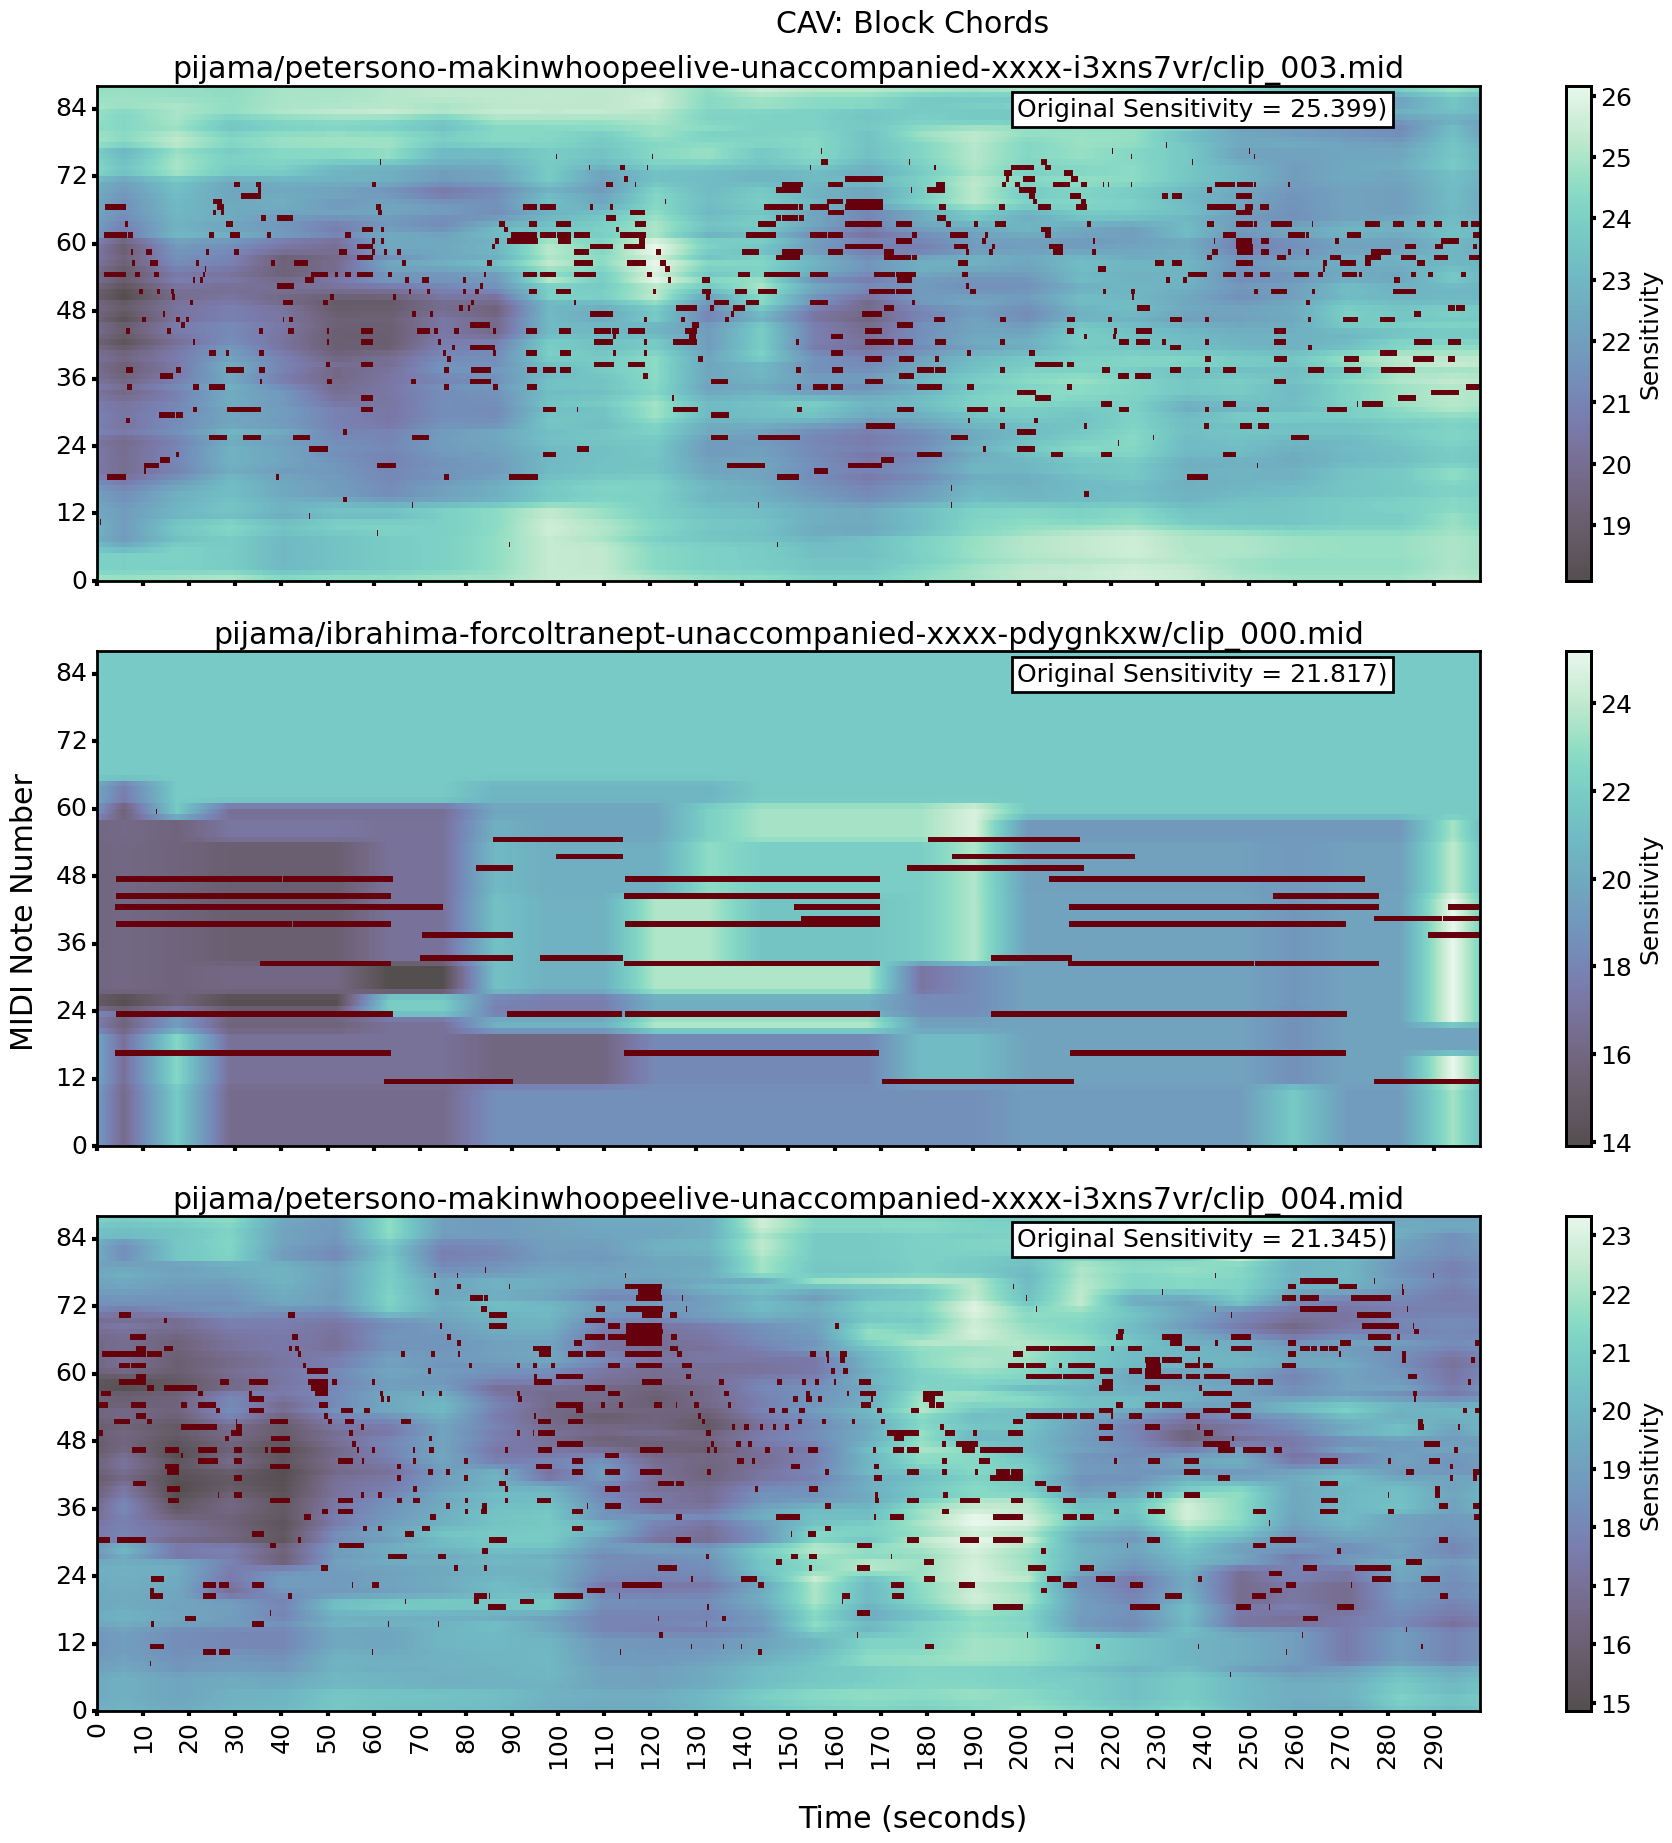

Shell Voicings pijama/monkt-askmenow-unaccompanied-xxxx-7mh1wybr/clip_006.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Shell Voicings pijama/alleng-godsancientsky-unaccompanied-xxxx-224gmzlu/clip_010.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Shell Voicings pijama/monkt-askmenow-unaccompanied-xxxx-7mh1wybr/clip_005.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

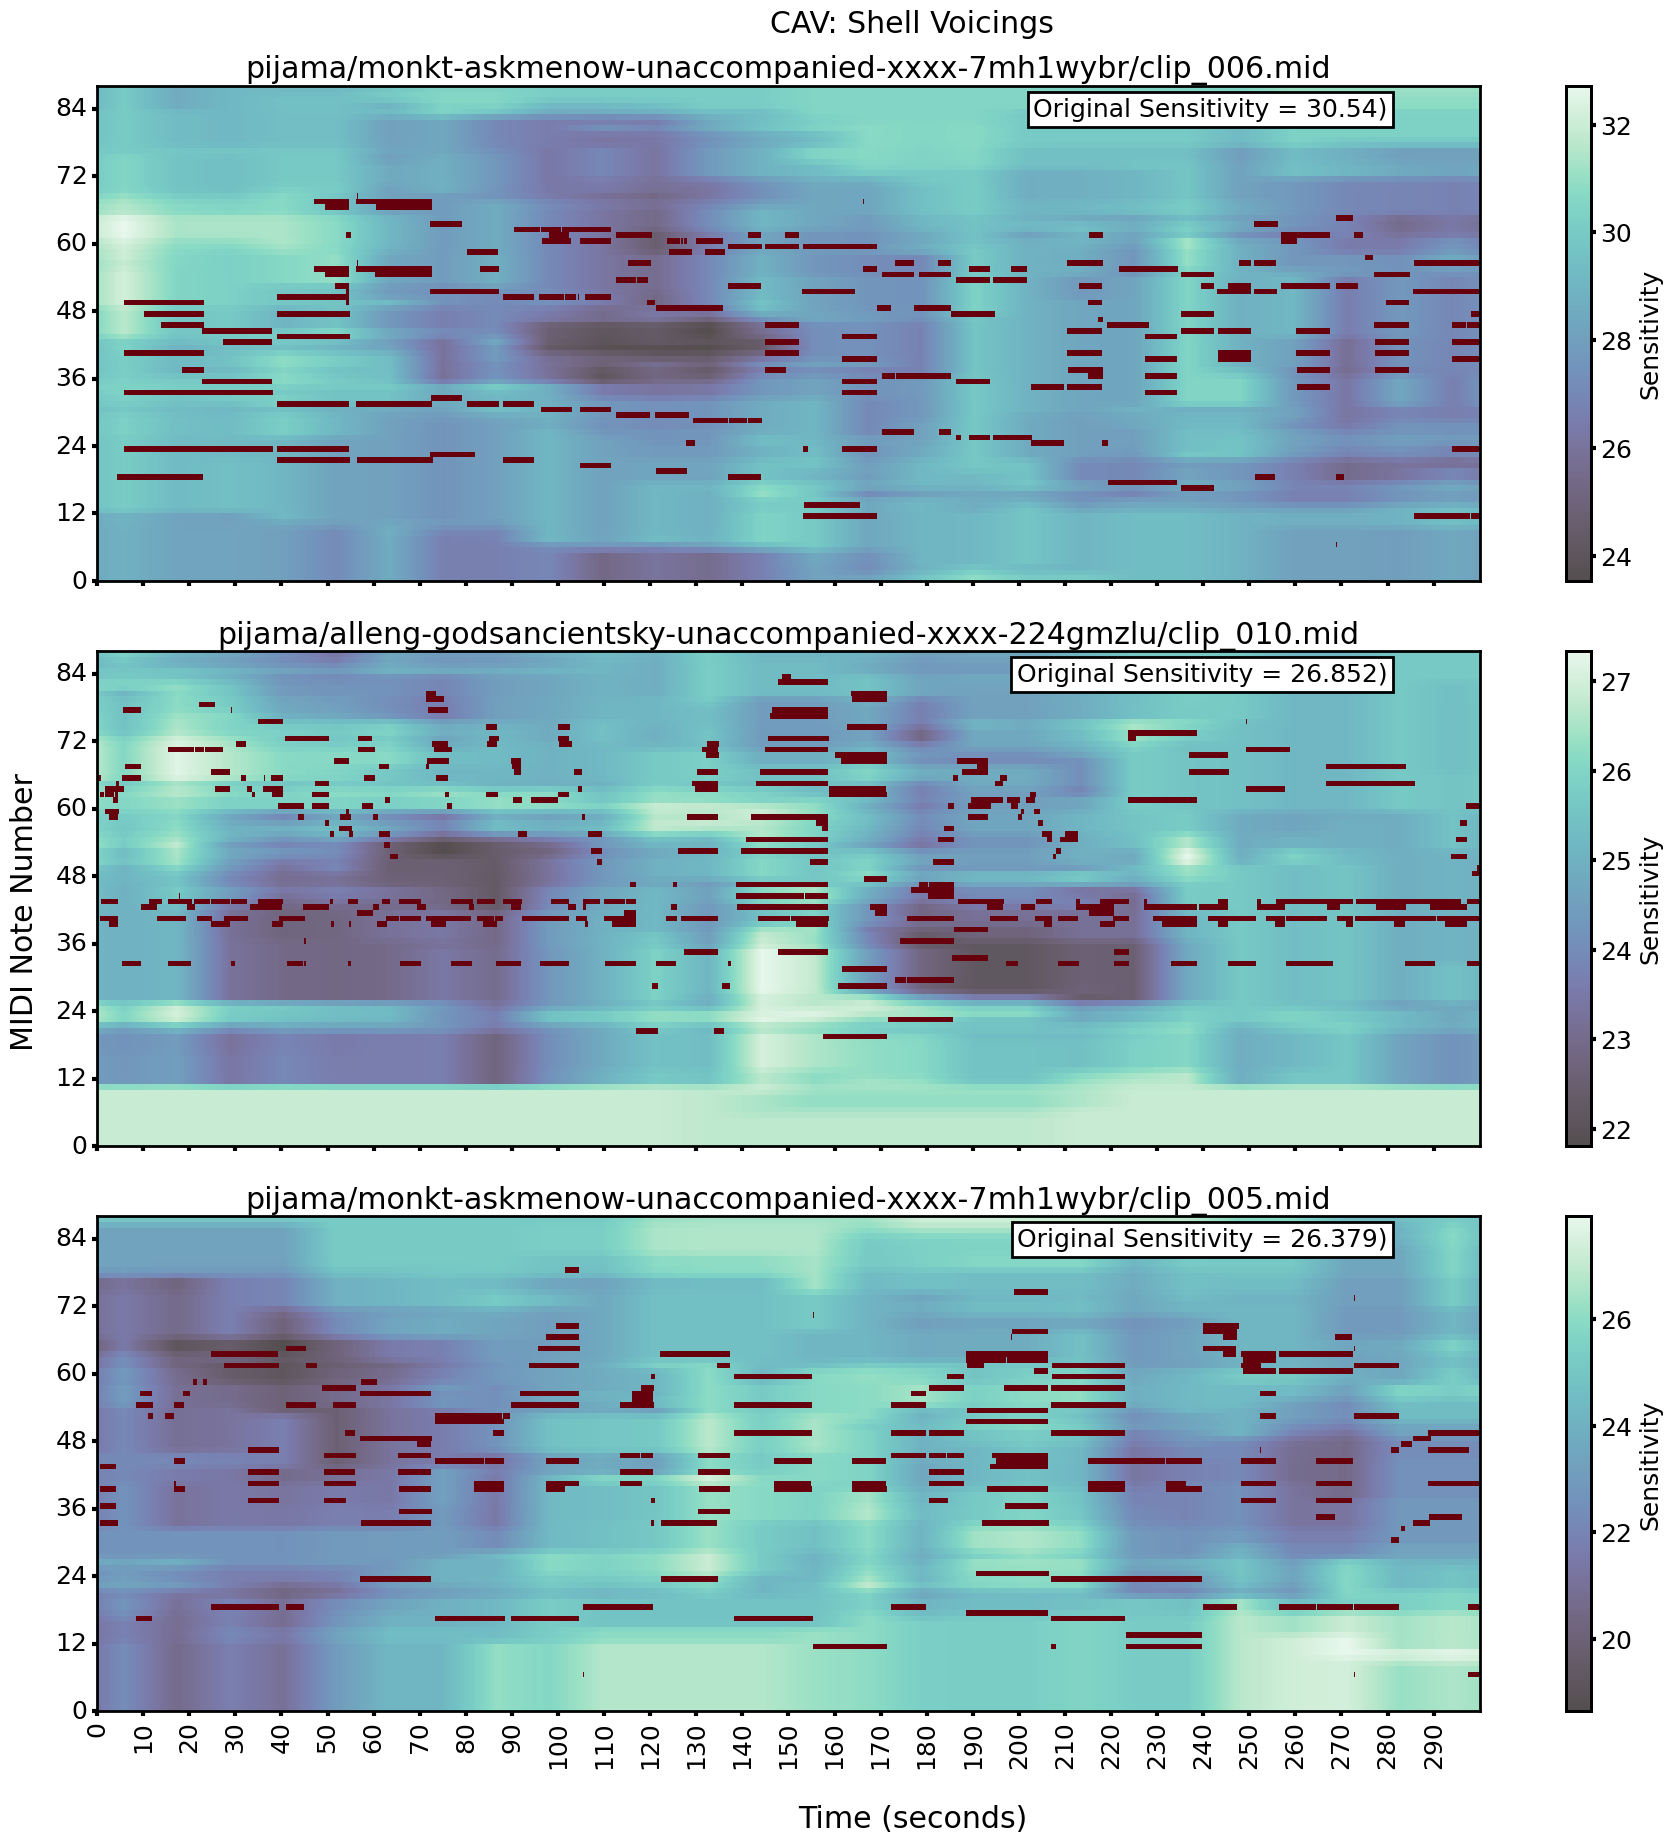

Diatonic 7th Chords jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967/clip_005.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Diatonic 7th Chords jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967/clip_004.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Diatonic 7th Chords pijama/mehldaub-andiloveherlive-unaccompanied-xxxx-as1cgema/clip_030.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

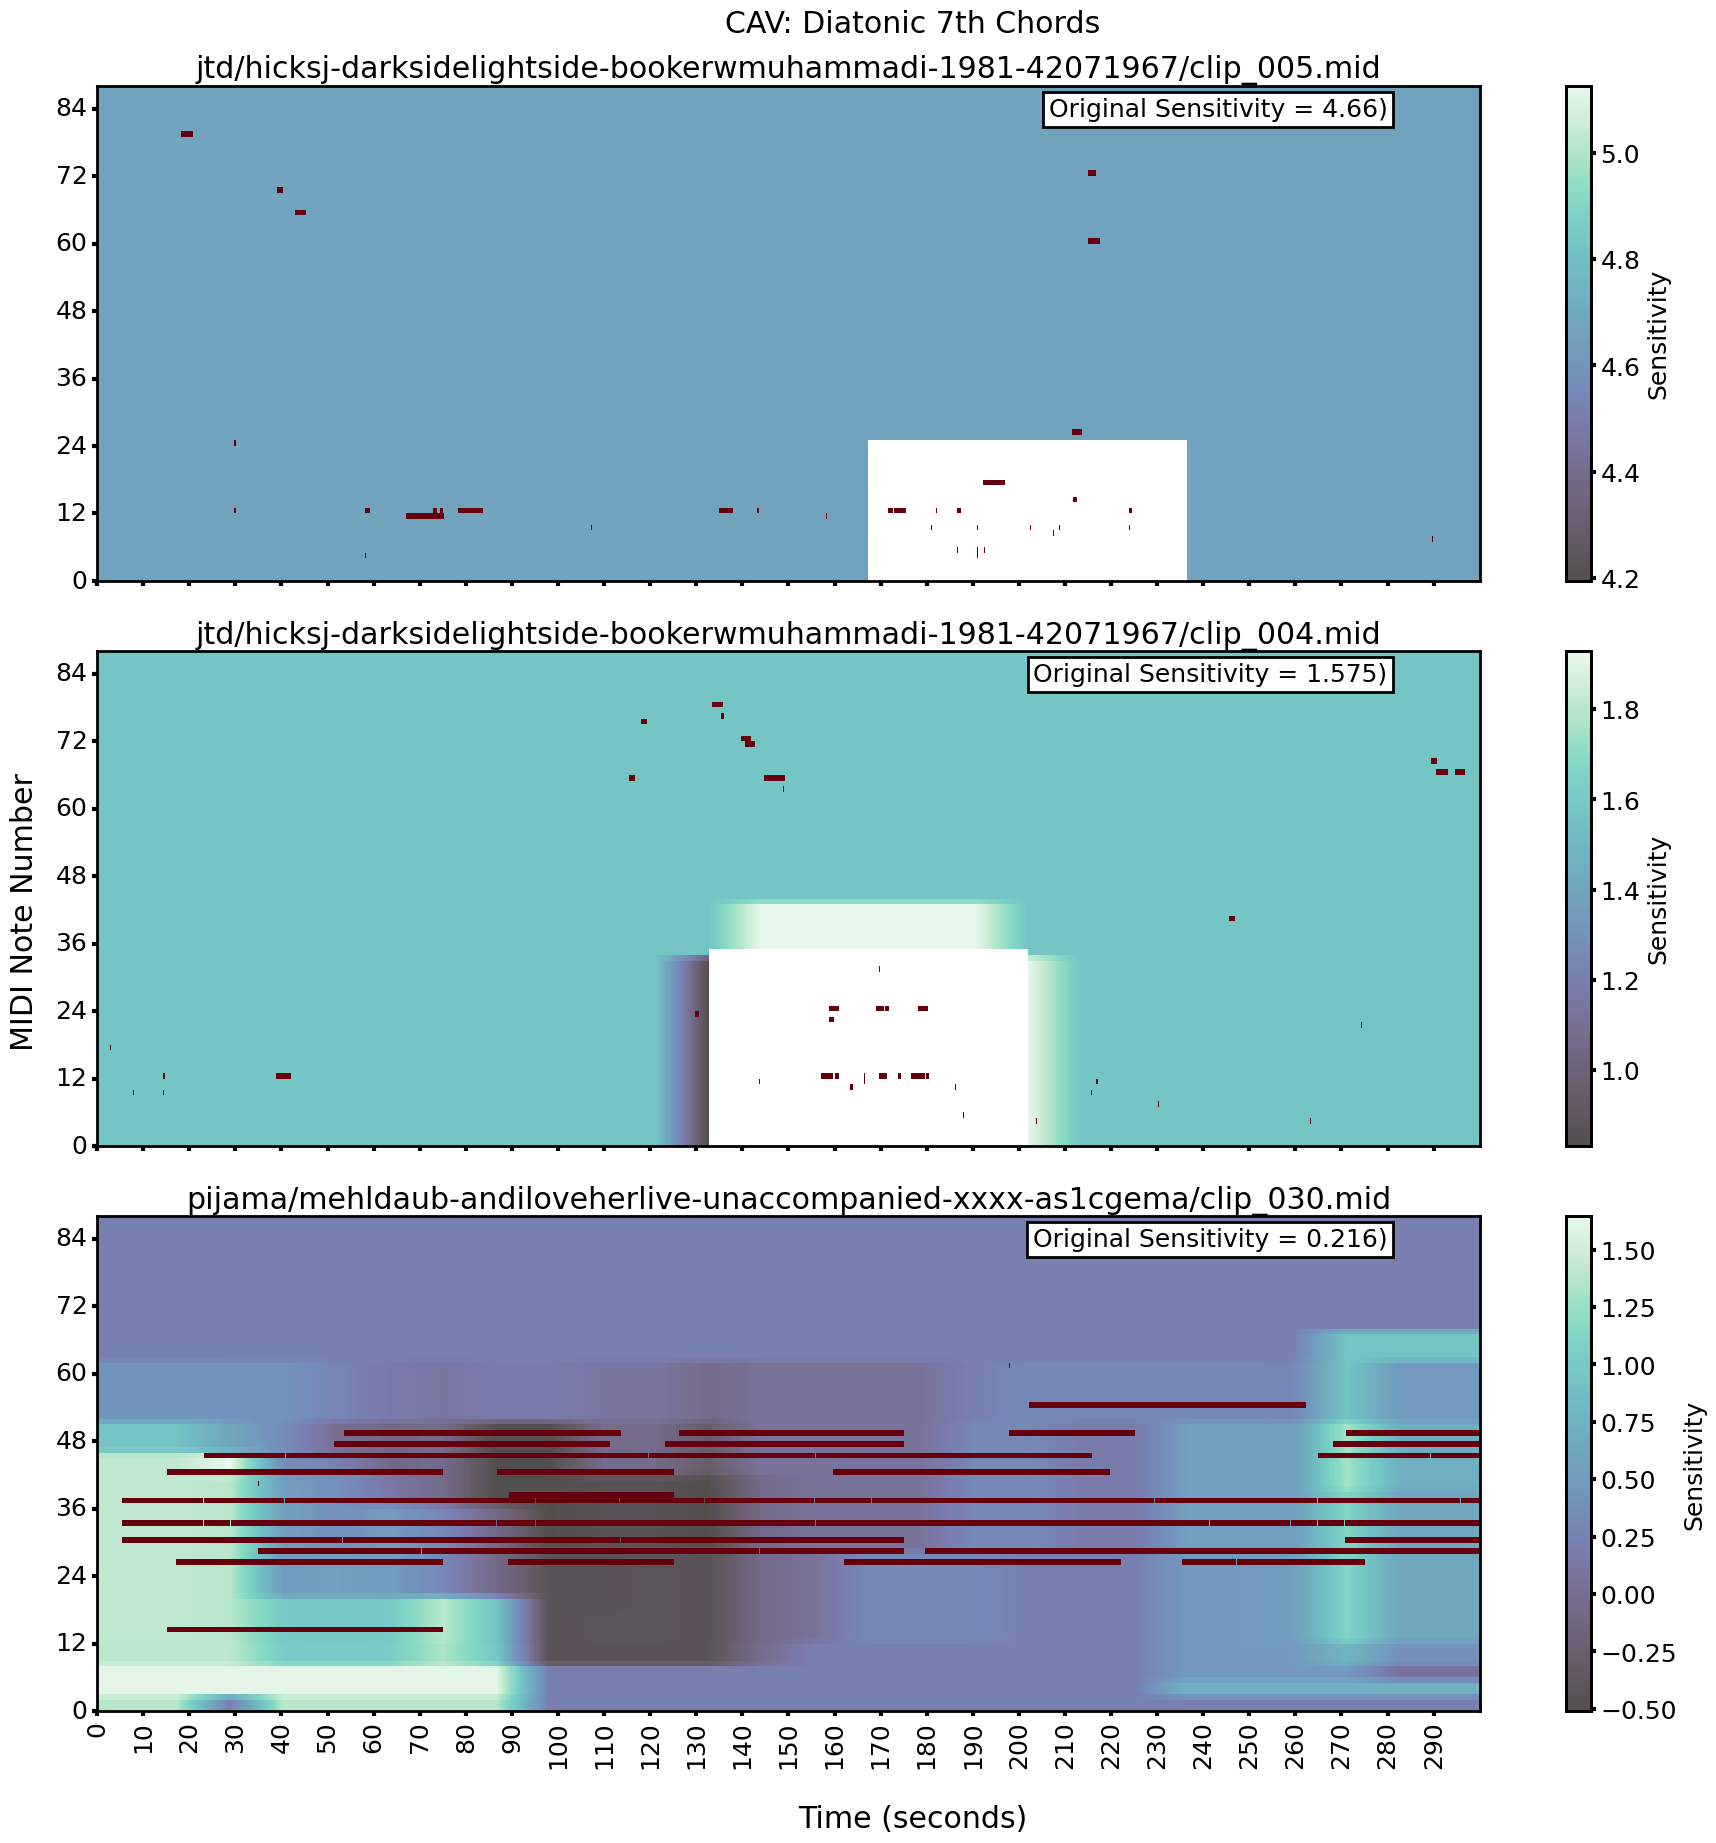

Cycle Progressions pijama/mehldaub-ix-unaccompanied-xxxx-id6ylbmq/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Cycle Progressions jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967/clip_006.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Cycle Progressions pijama/ibrahima-opendoorwithin-unaccompanied-xxxx-n188c8gt/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

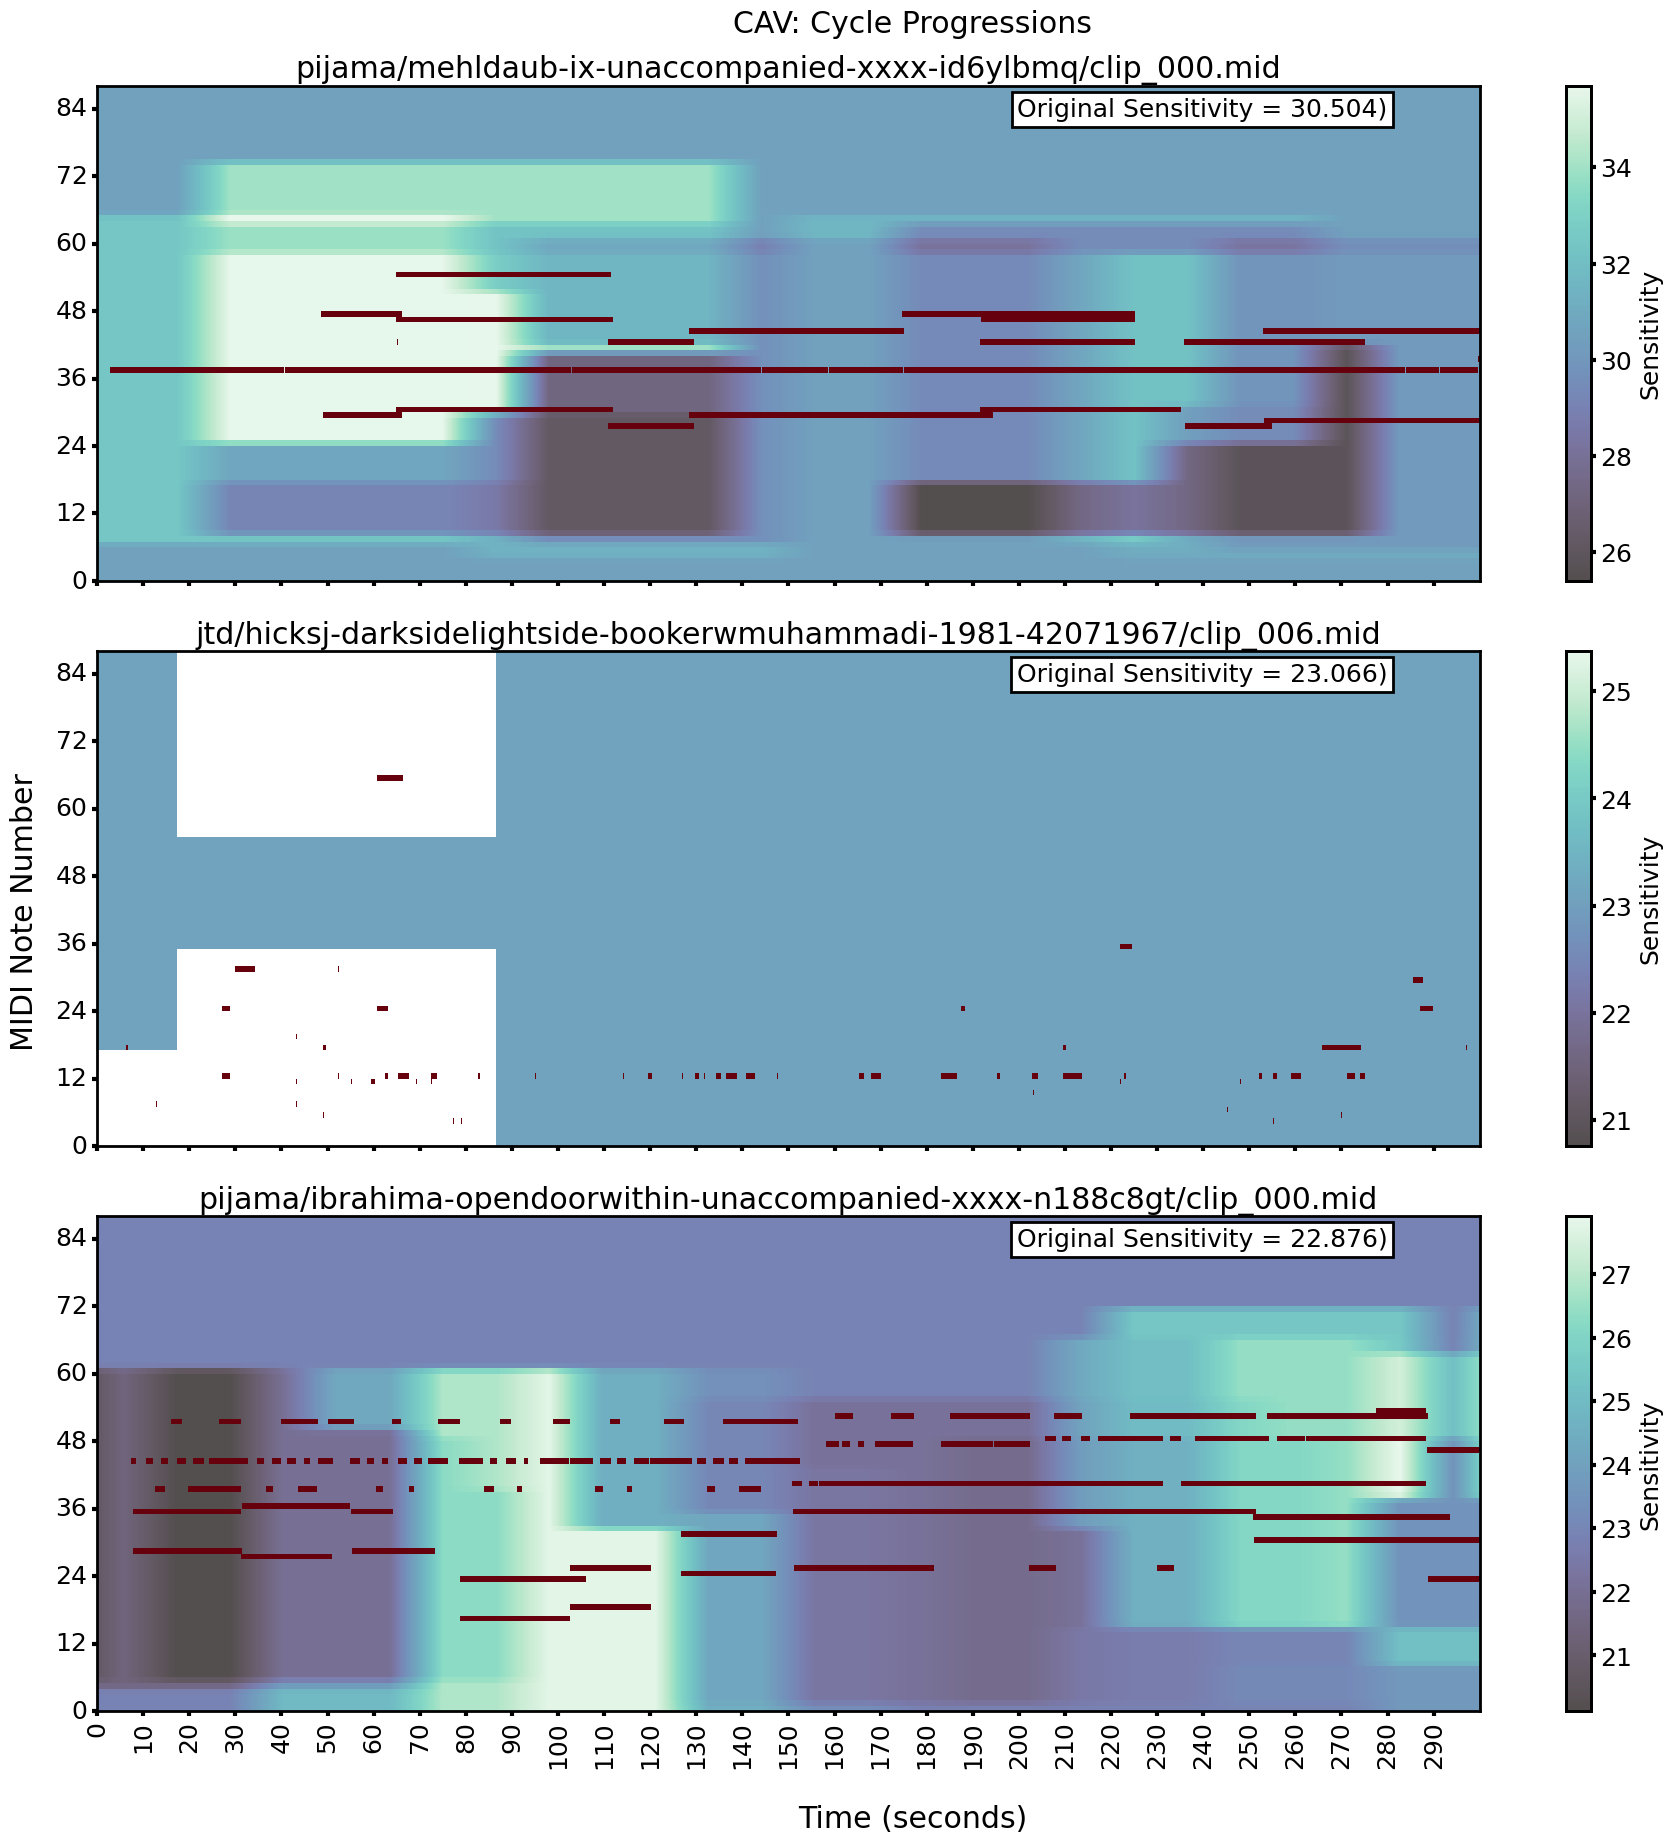

II-V-I's in Major and Minor pijama/wilsont-teafortwo-unaccompanied-xxxx-ptbs1qzd/clip_010.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

II-V-I's in Major and Minor pijama/wilsont-shinystockings-unaccompanied-xxxx-swlsd0wg/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

II-V-I's in Major and Minor pijama/wilsont-sunday-unaccompanied-xxxx-1gc4easf/clip_002.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

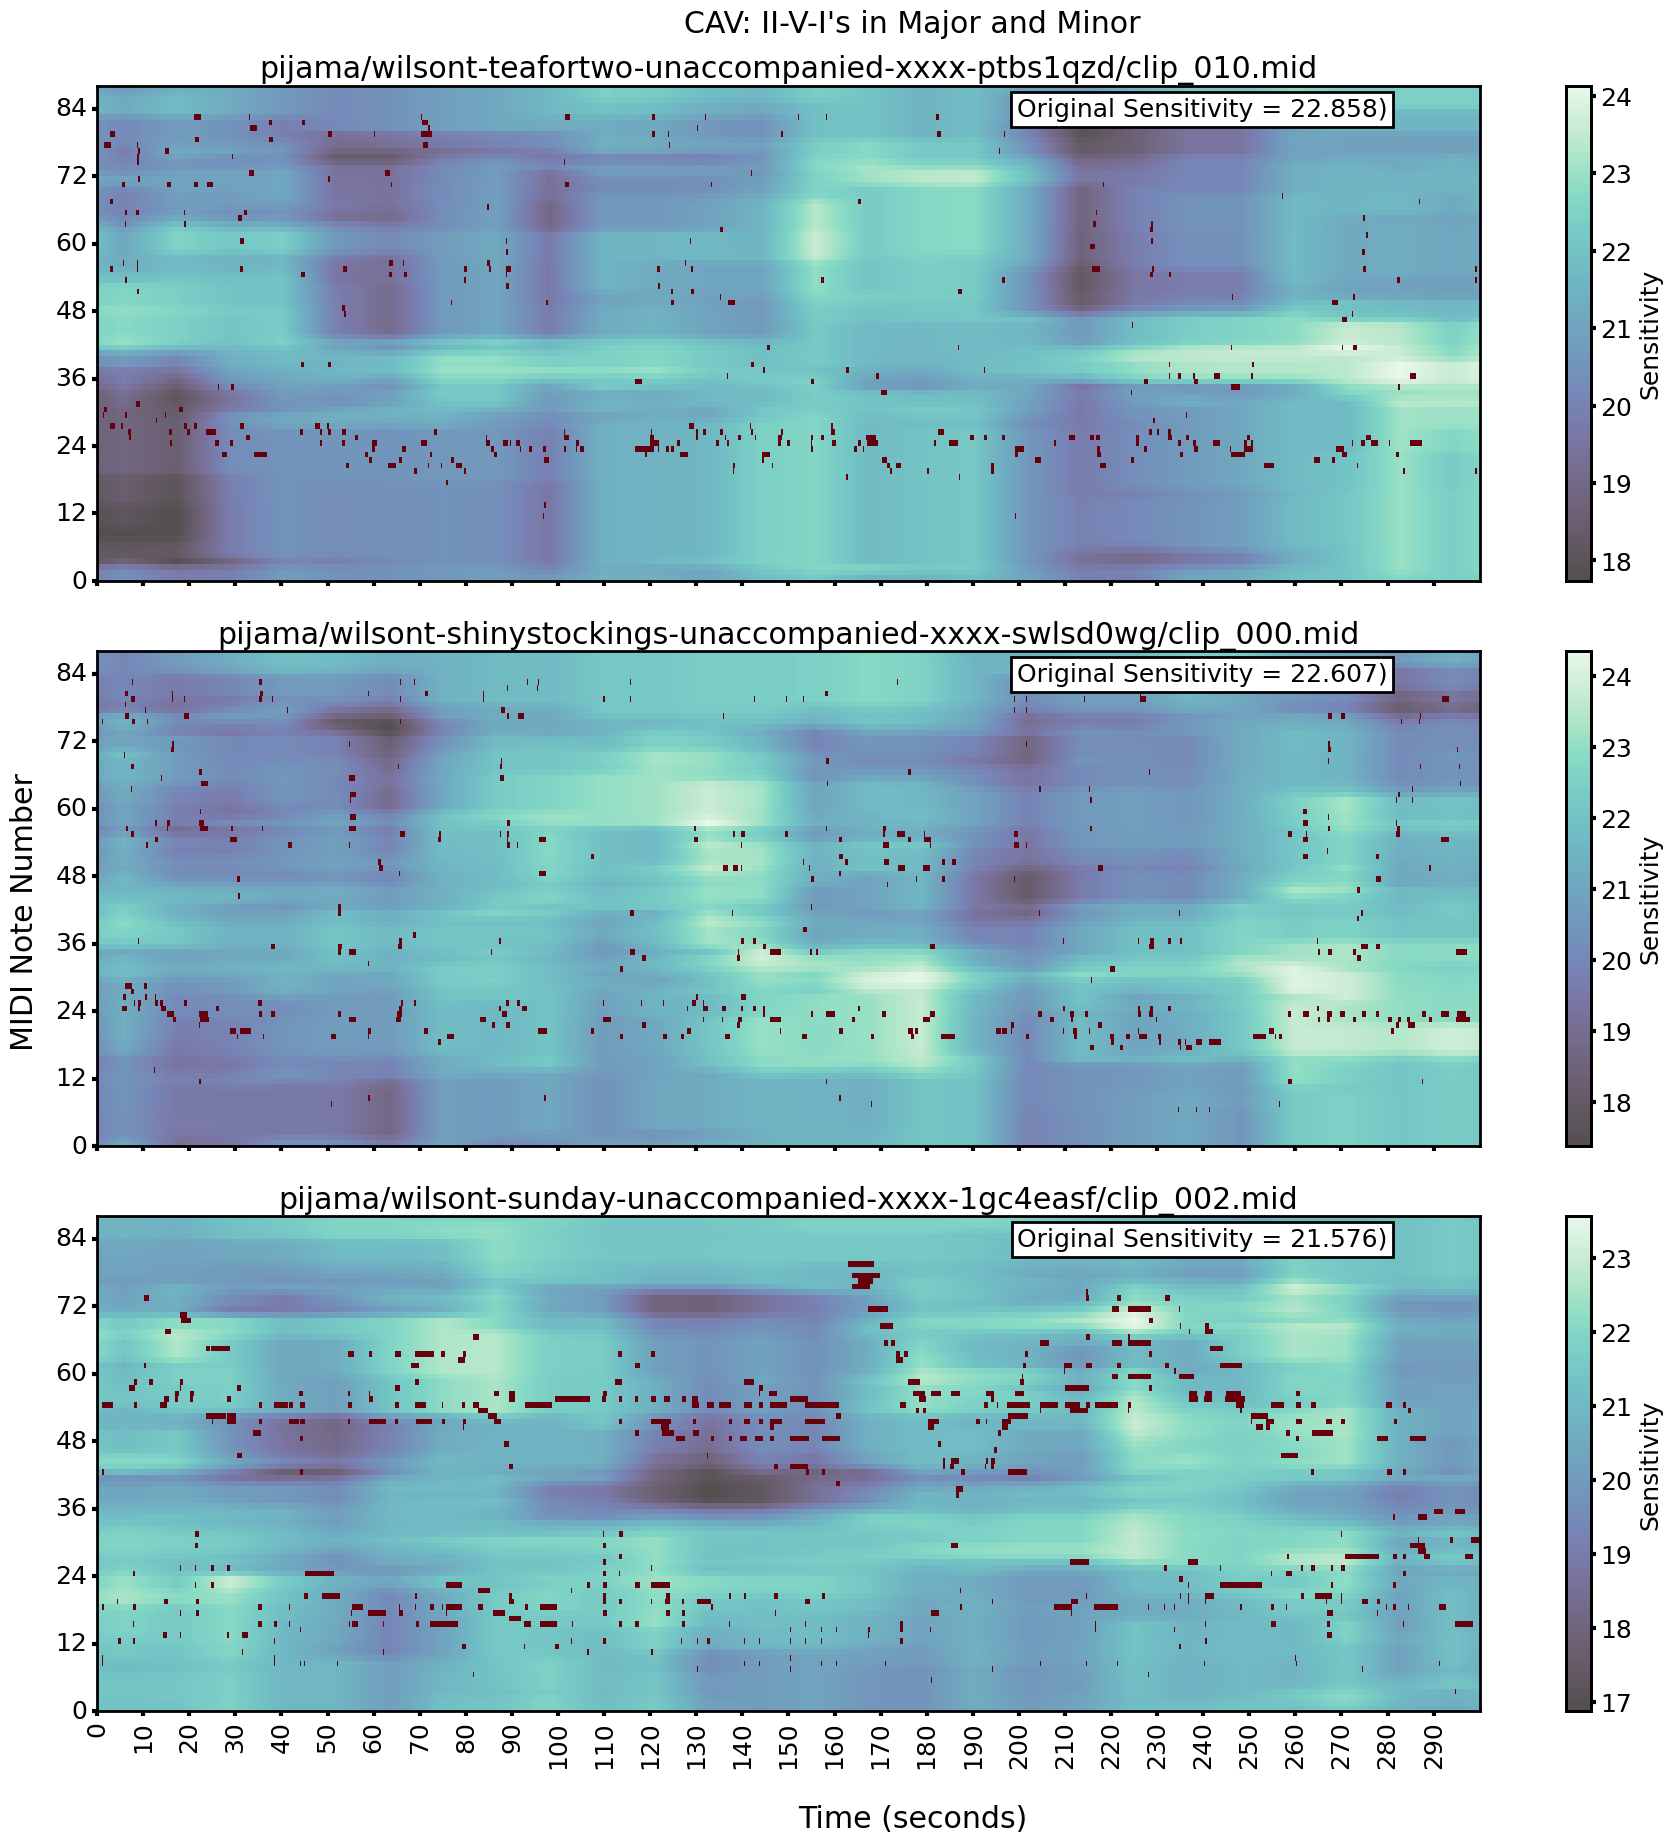

I-IV Cycle Progression jtd/monkt-monksdream-mappgblakeya-1952-0526e904/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

I-IV Cycle Progression jtd/mancej-lesterleapsin-thompsondalleynea-1997-bfbe7a50/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

I-IV Cycle Progression jtd/monkt-niceworkifyoucan-rameygblakeya-1949-705f0b58/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

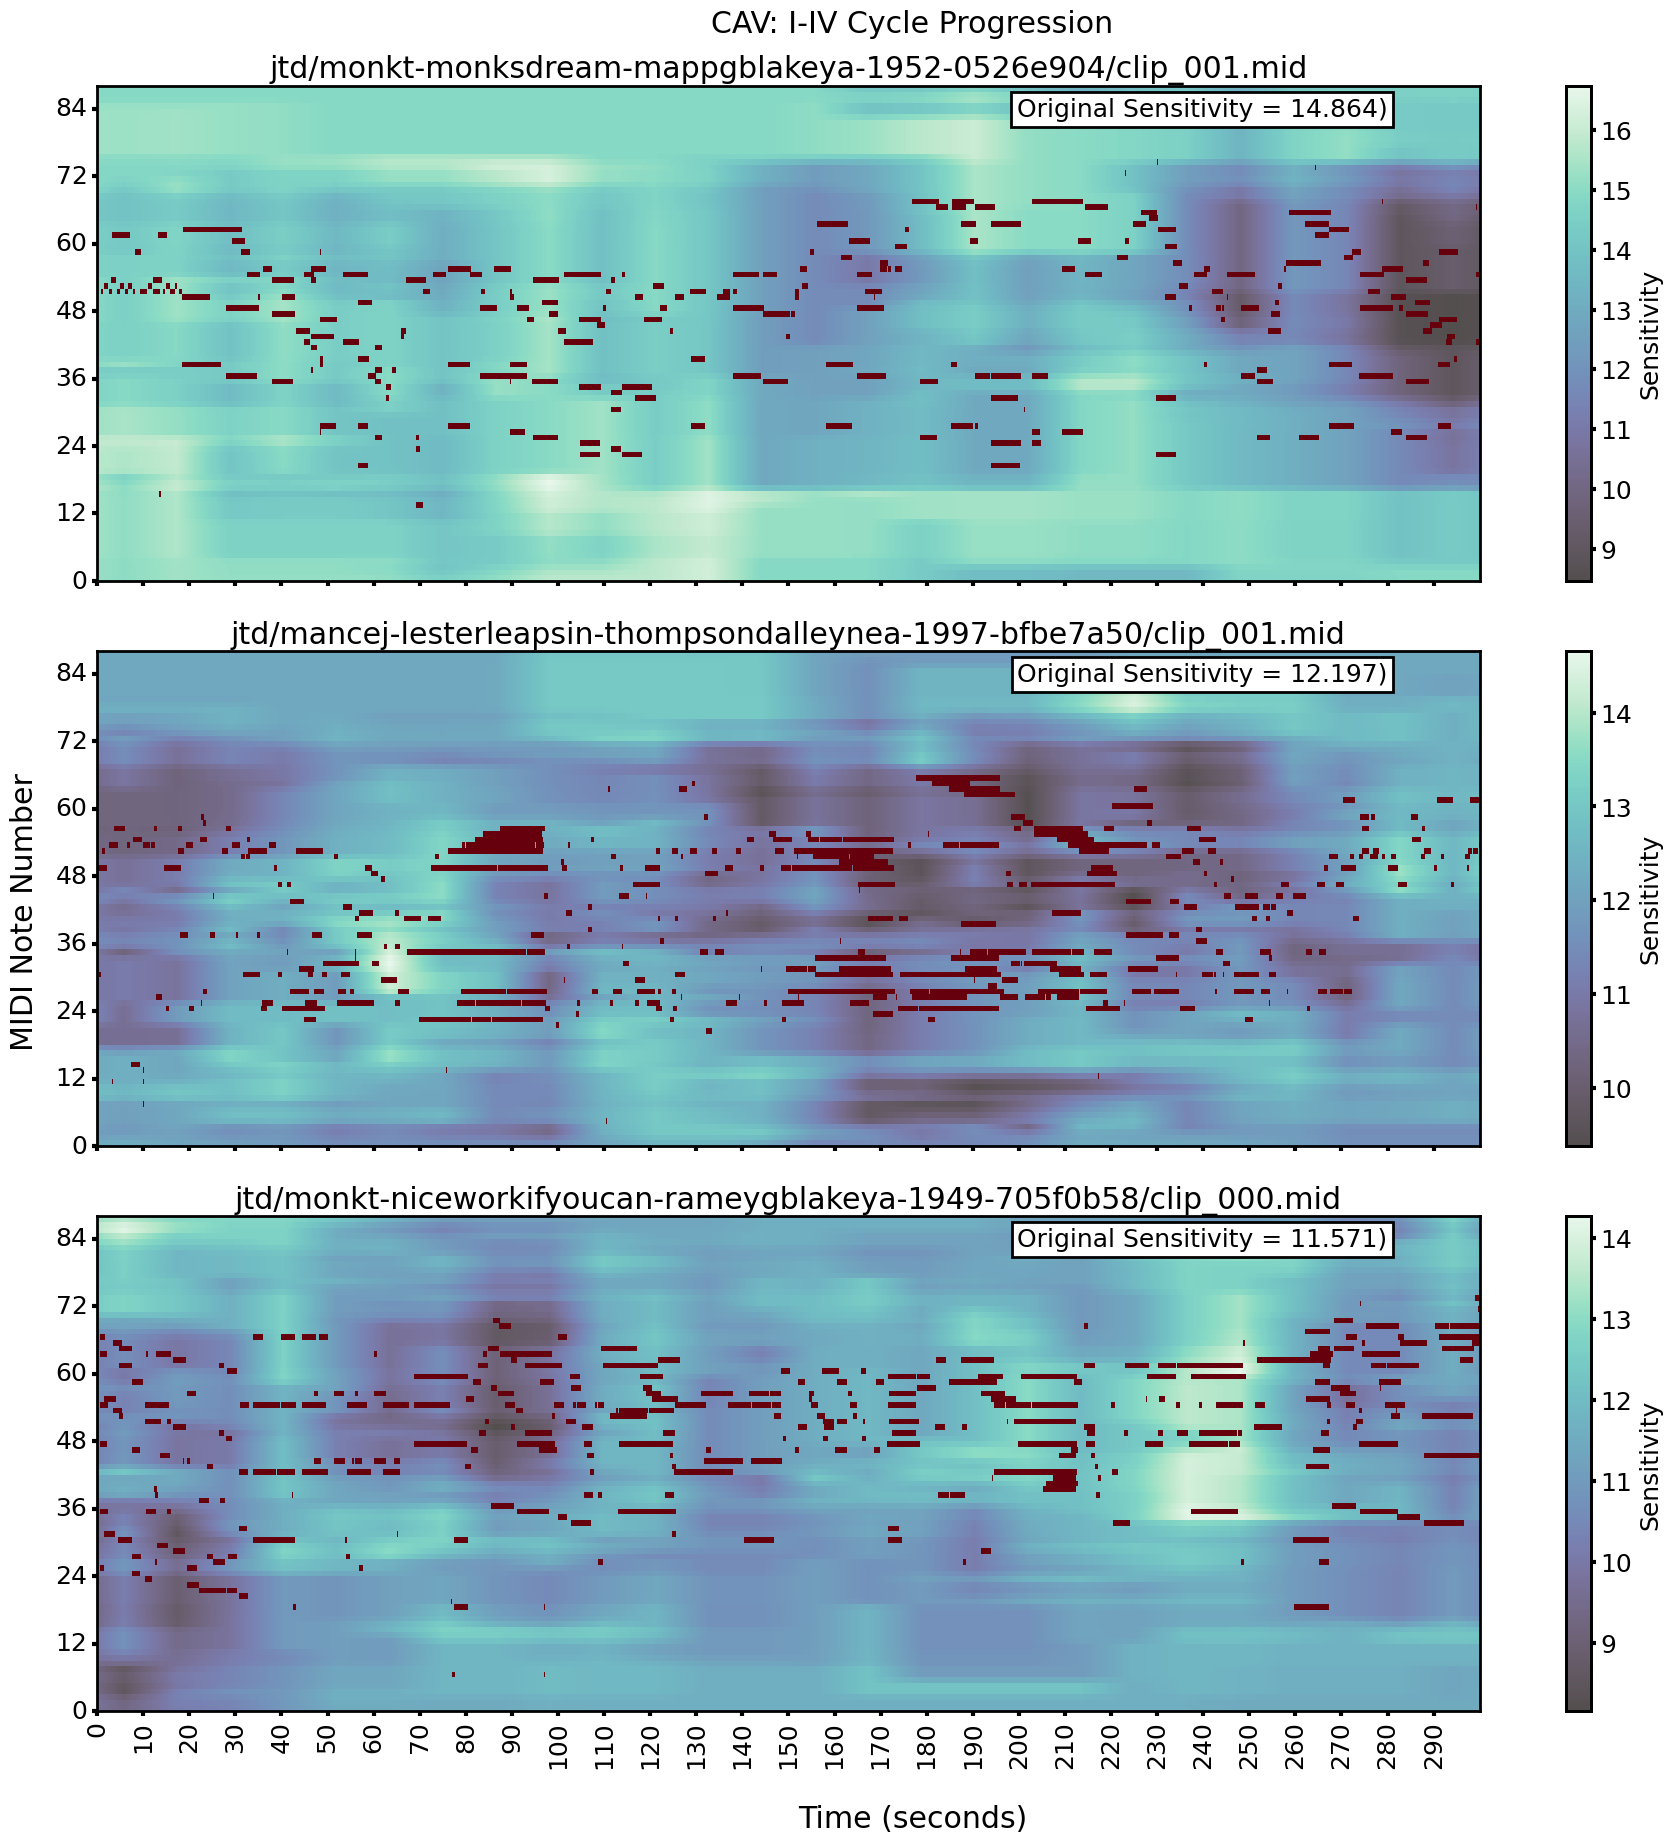

Modal Fourthy Voicings jtd/hicksj-darksidelightside-bookerwmuhammadi-1981-42071967/clip_006.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Modal Fourthy Voicings pijama/tynerm-tivoli-unaccompanied-xxxx-zzs1xka8/clip_008.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Modal Fourthy Voicings pijama/ibrahima-forcoltranept-unaccompanied-xxxx-pdygnkxw/clip_005.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

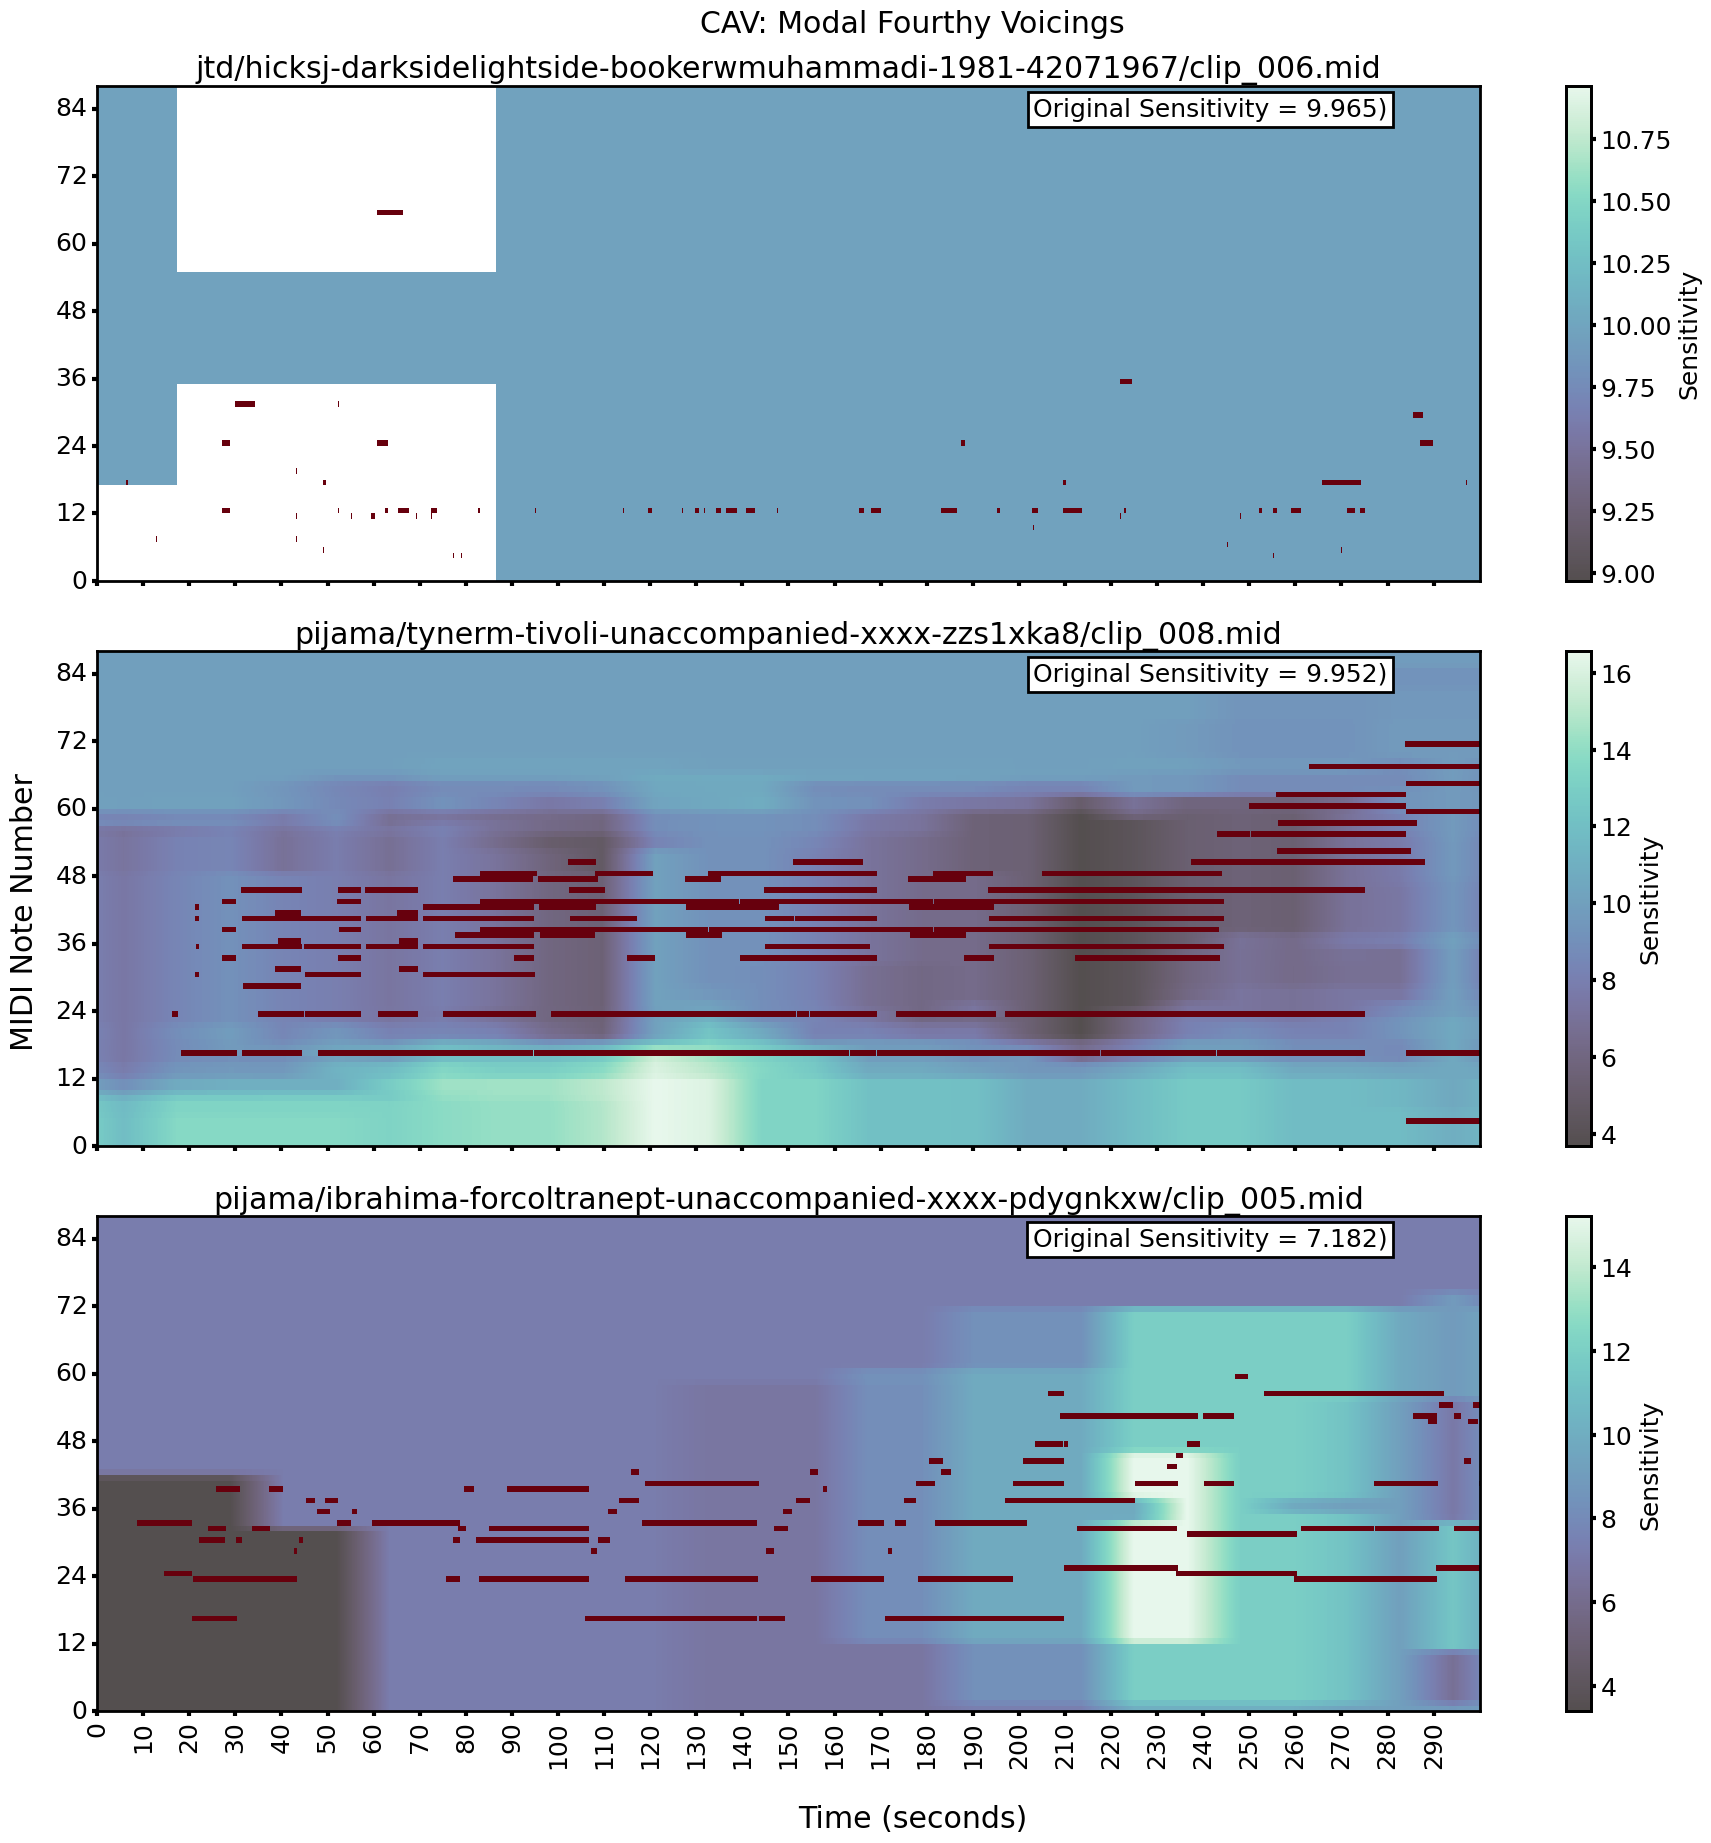

So What Voicings pijama/mehldaub-ix-unaccompanied-xxxx-id6ylbmq/clip_005.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

So What Voicings pijama/jarrettk-osakanovember81976part1-unaccompanied-xxxx-pst1v2v5/clip_048.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

So What Voicings pijama/coreac-portrait2casablanca-unaccompanied-xxxx-eewiosu3/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

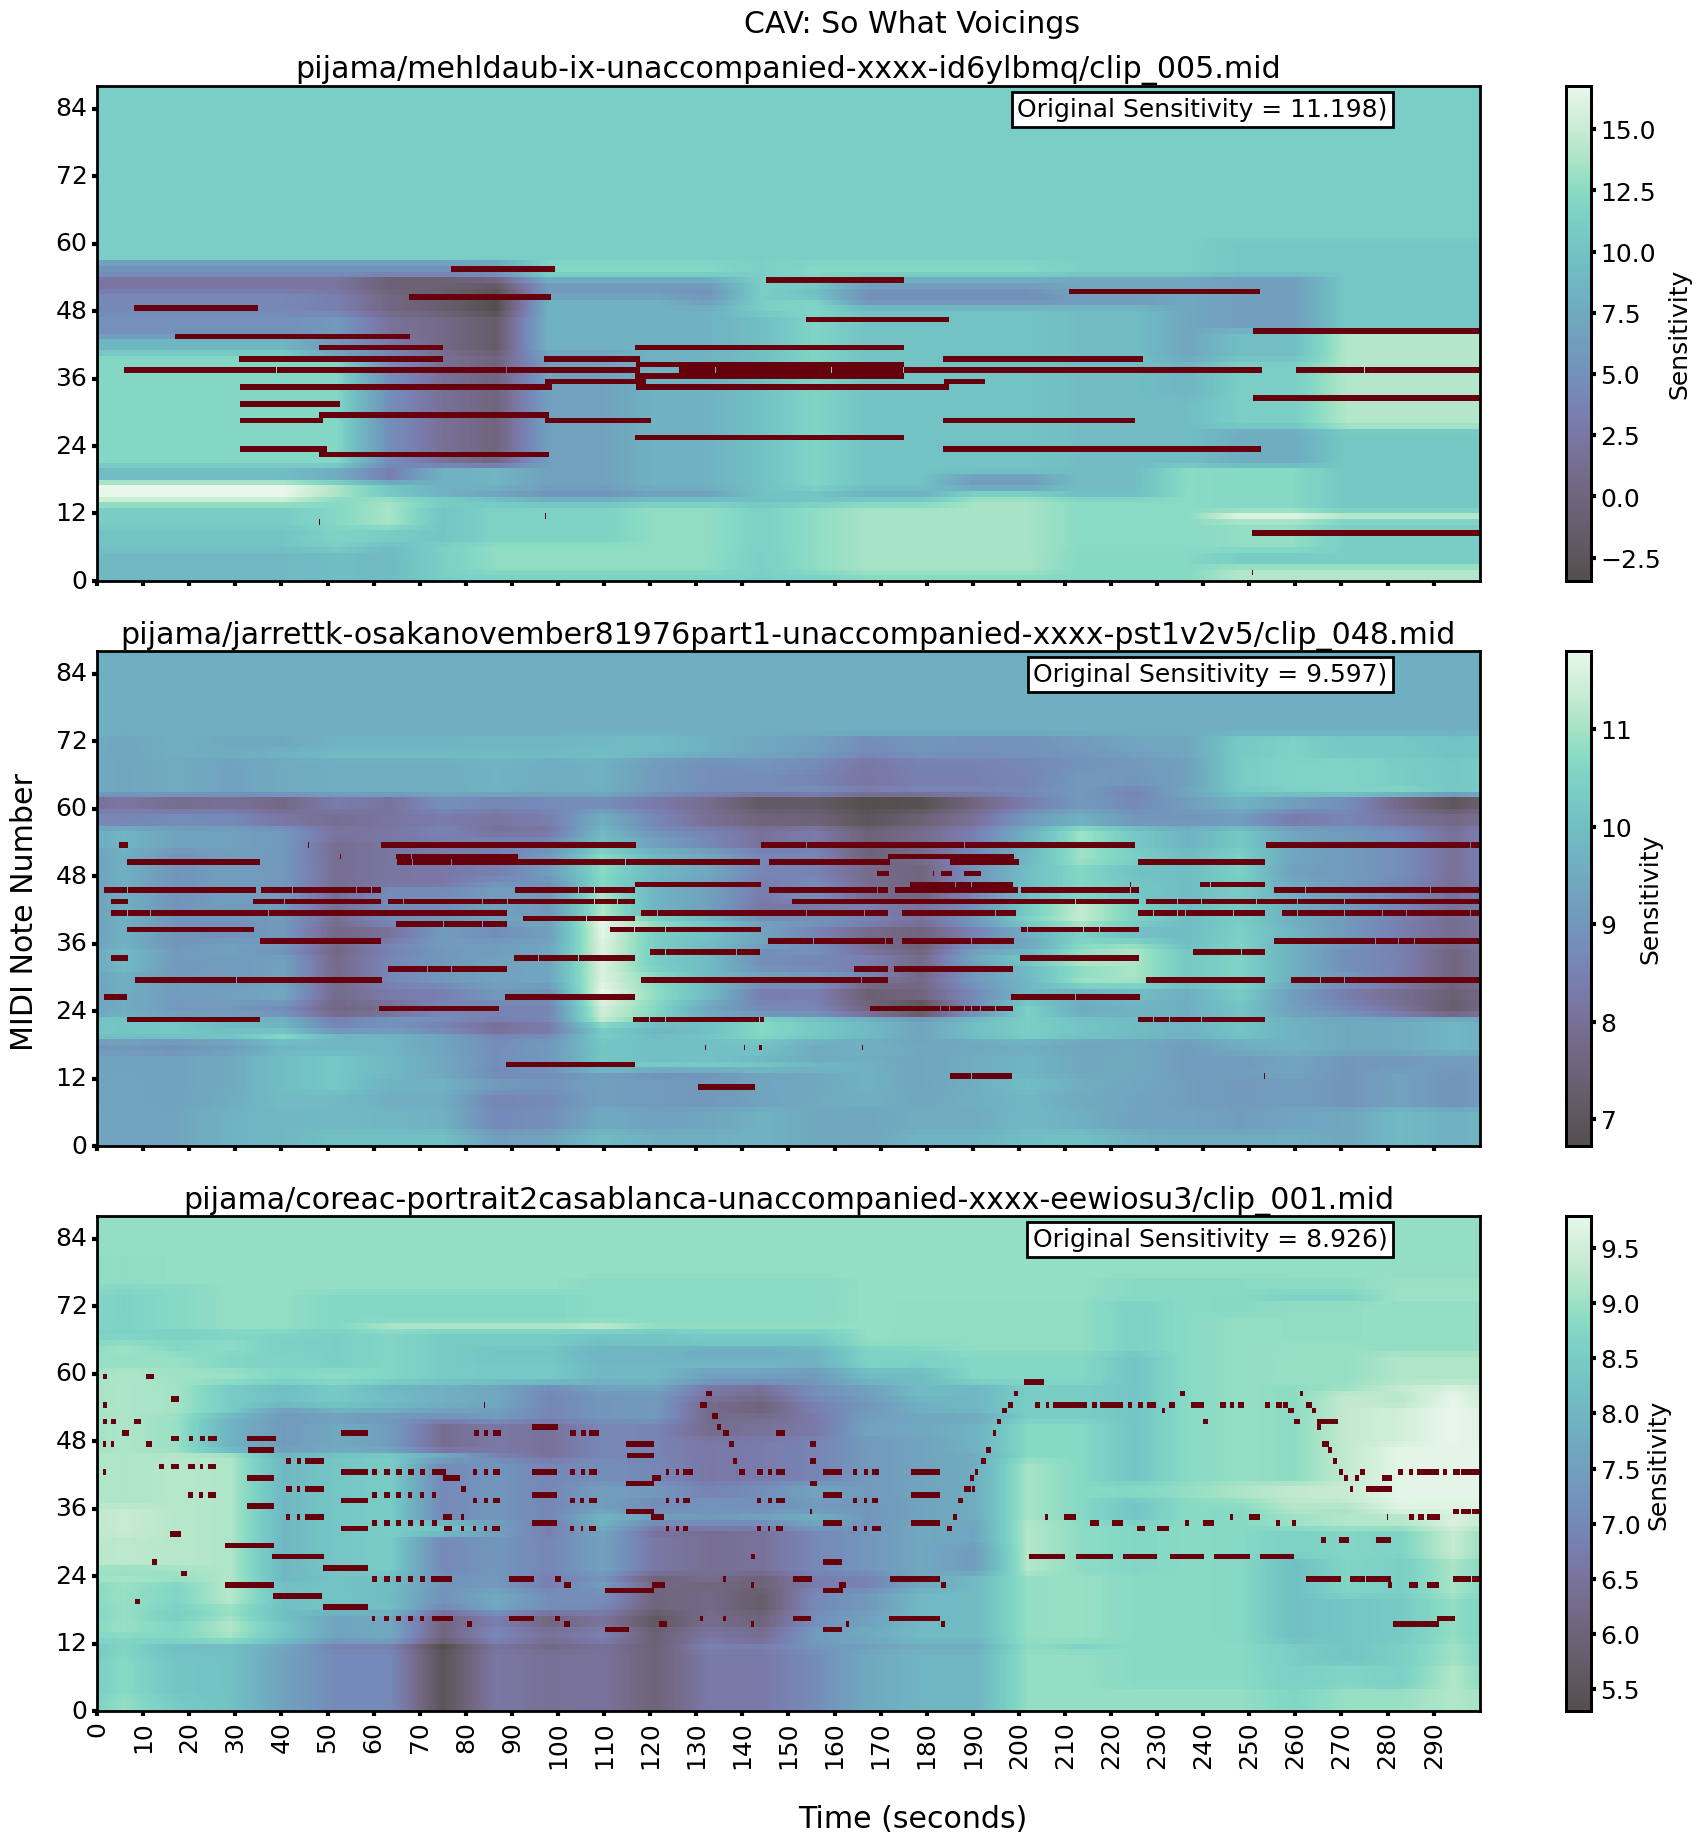

Modal "So What" Voicings pijama/jarrettk-pt-unaccompanied-xxxx-whfxi44r/clip_007.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Modal "So What" Voicings pijama/alleng-alonetogether-unaccompanied-xxxx-fbbw4vkv/clip_002.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Modal "So What" Voicings pijama/mehldaub-heyyoulive-unaccompanied-xxxx-levtfkvk/clip_017.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

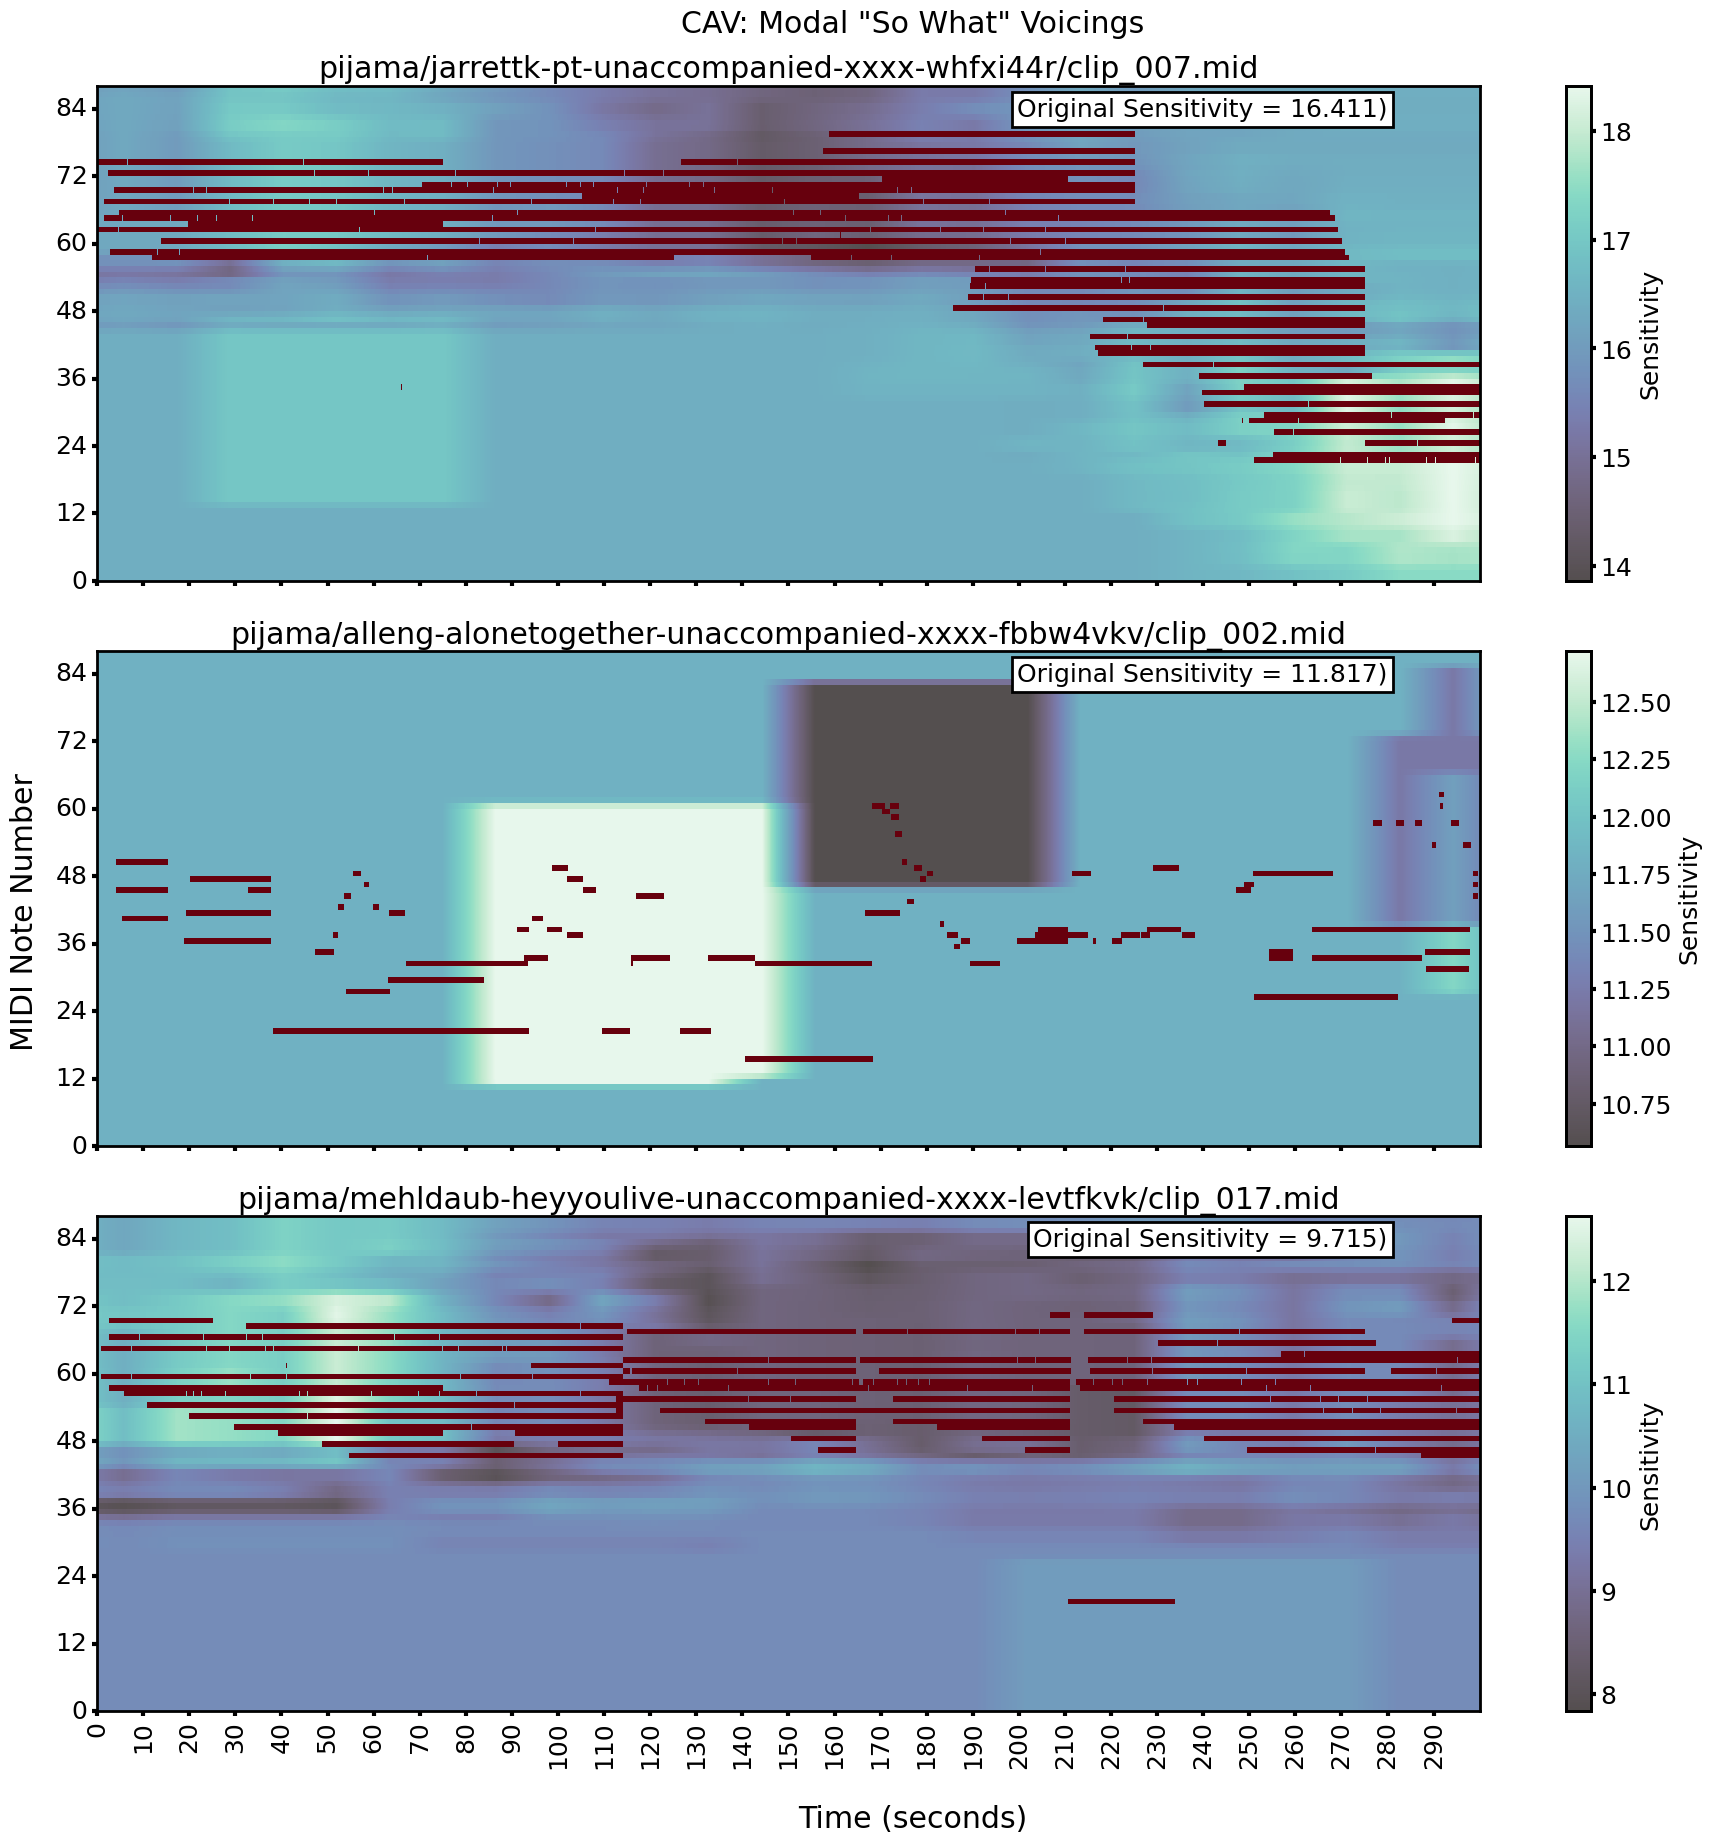

Fourth II-V-I's pijama/tynerm-tivoli-unaccompanied-xxxx-zzs1xka8/clip_008.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Fourth II-V-I's pijama/barronk-budlikeliveatmaybeckrecital-unaccompanied-xxxx-mkhwqz3b/clip_003.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Fourth II-V-I's pijama/coreac-portrait2casablanca-unaccompanied-xxxx-eewiosu3/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

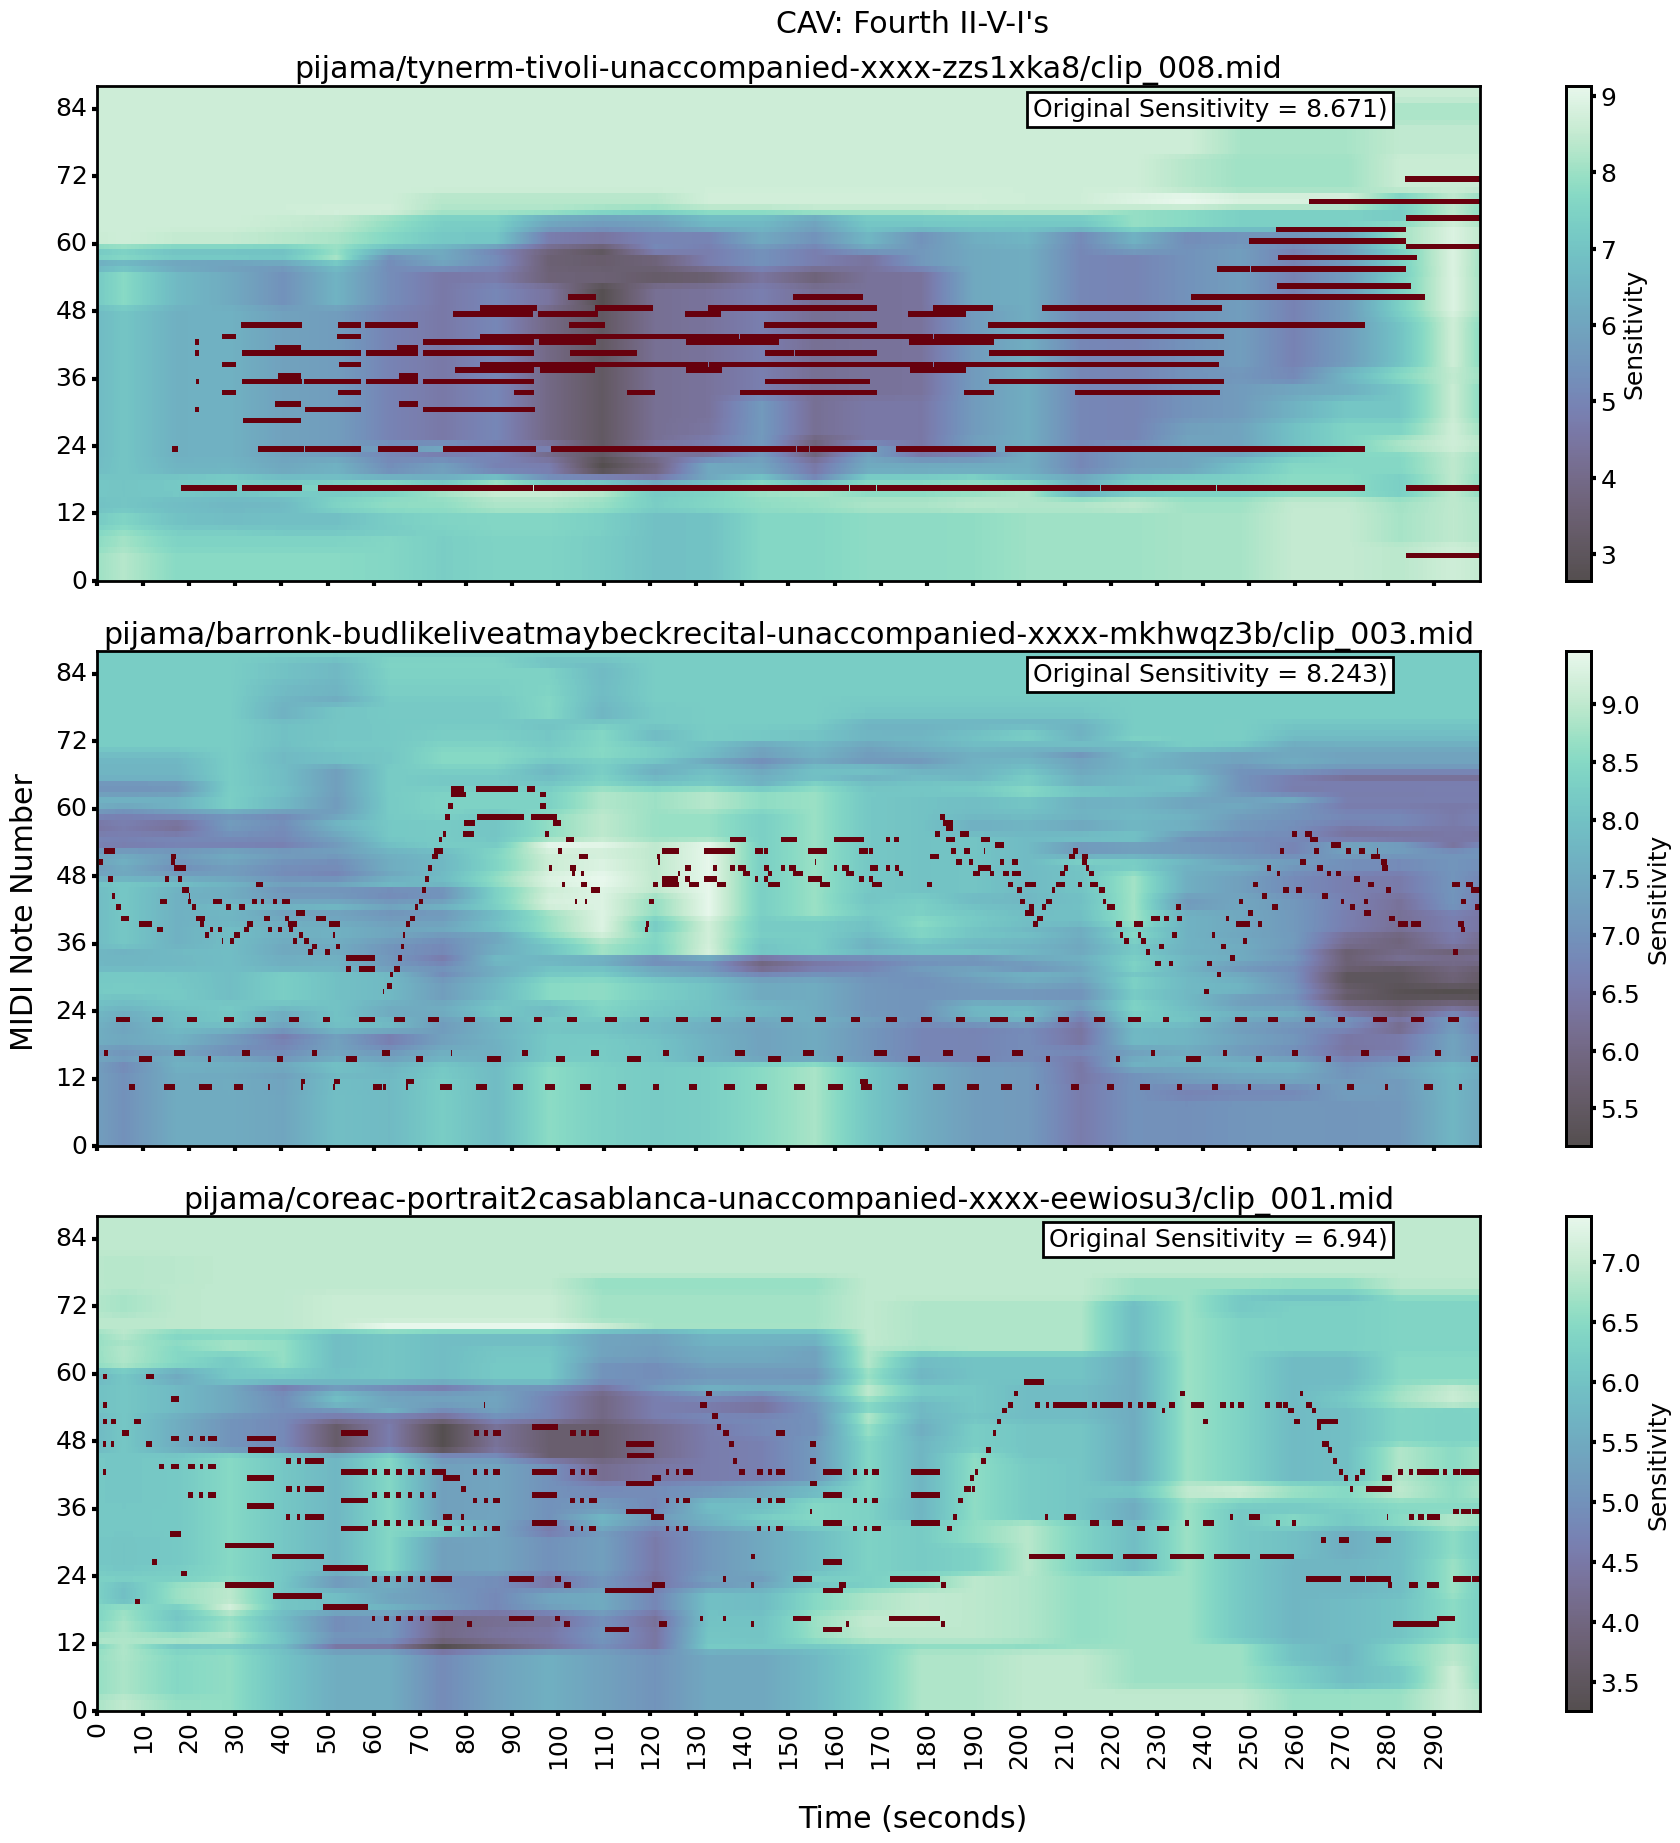

Tri-Tone Sub II-V-I's pijama/jarrettk-osakanovember81976part1-unaccompanied-xxxx-pst1v2v5/clip_021.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Tri-Tone Sub II-V-I's jtd/mancej-nadja-mayewilliamsj-1998-8ec1160d/clip_002.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Tri-Tone Sub II-V-I's pijama/jarrettk-ritooria-unaccompanied-xxxx-z63haqac/clip_005.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

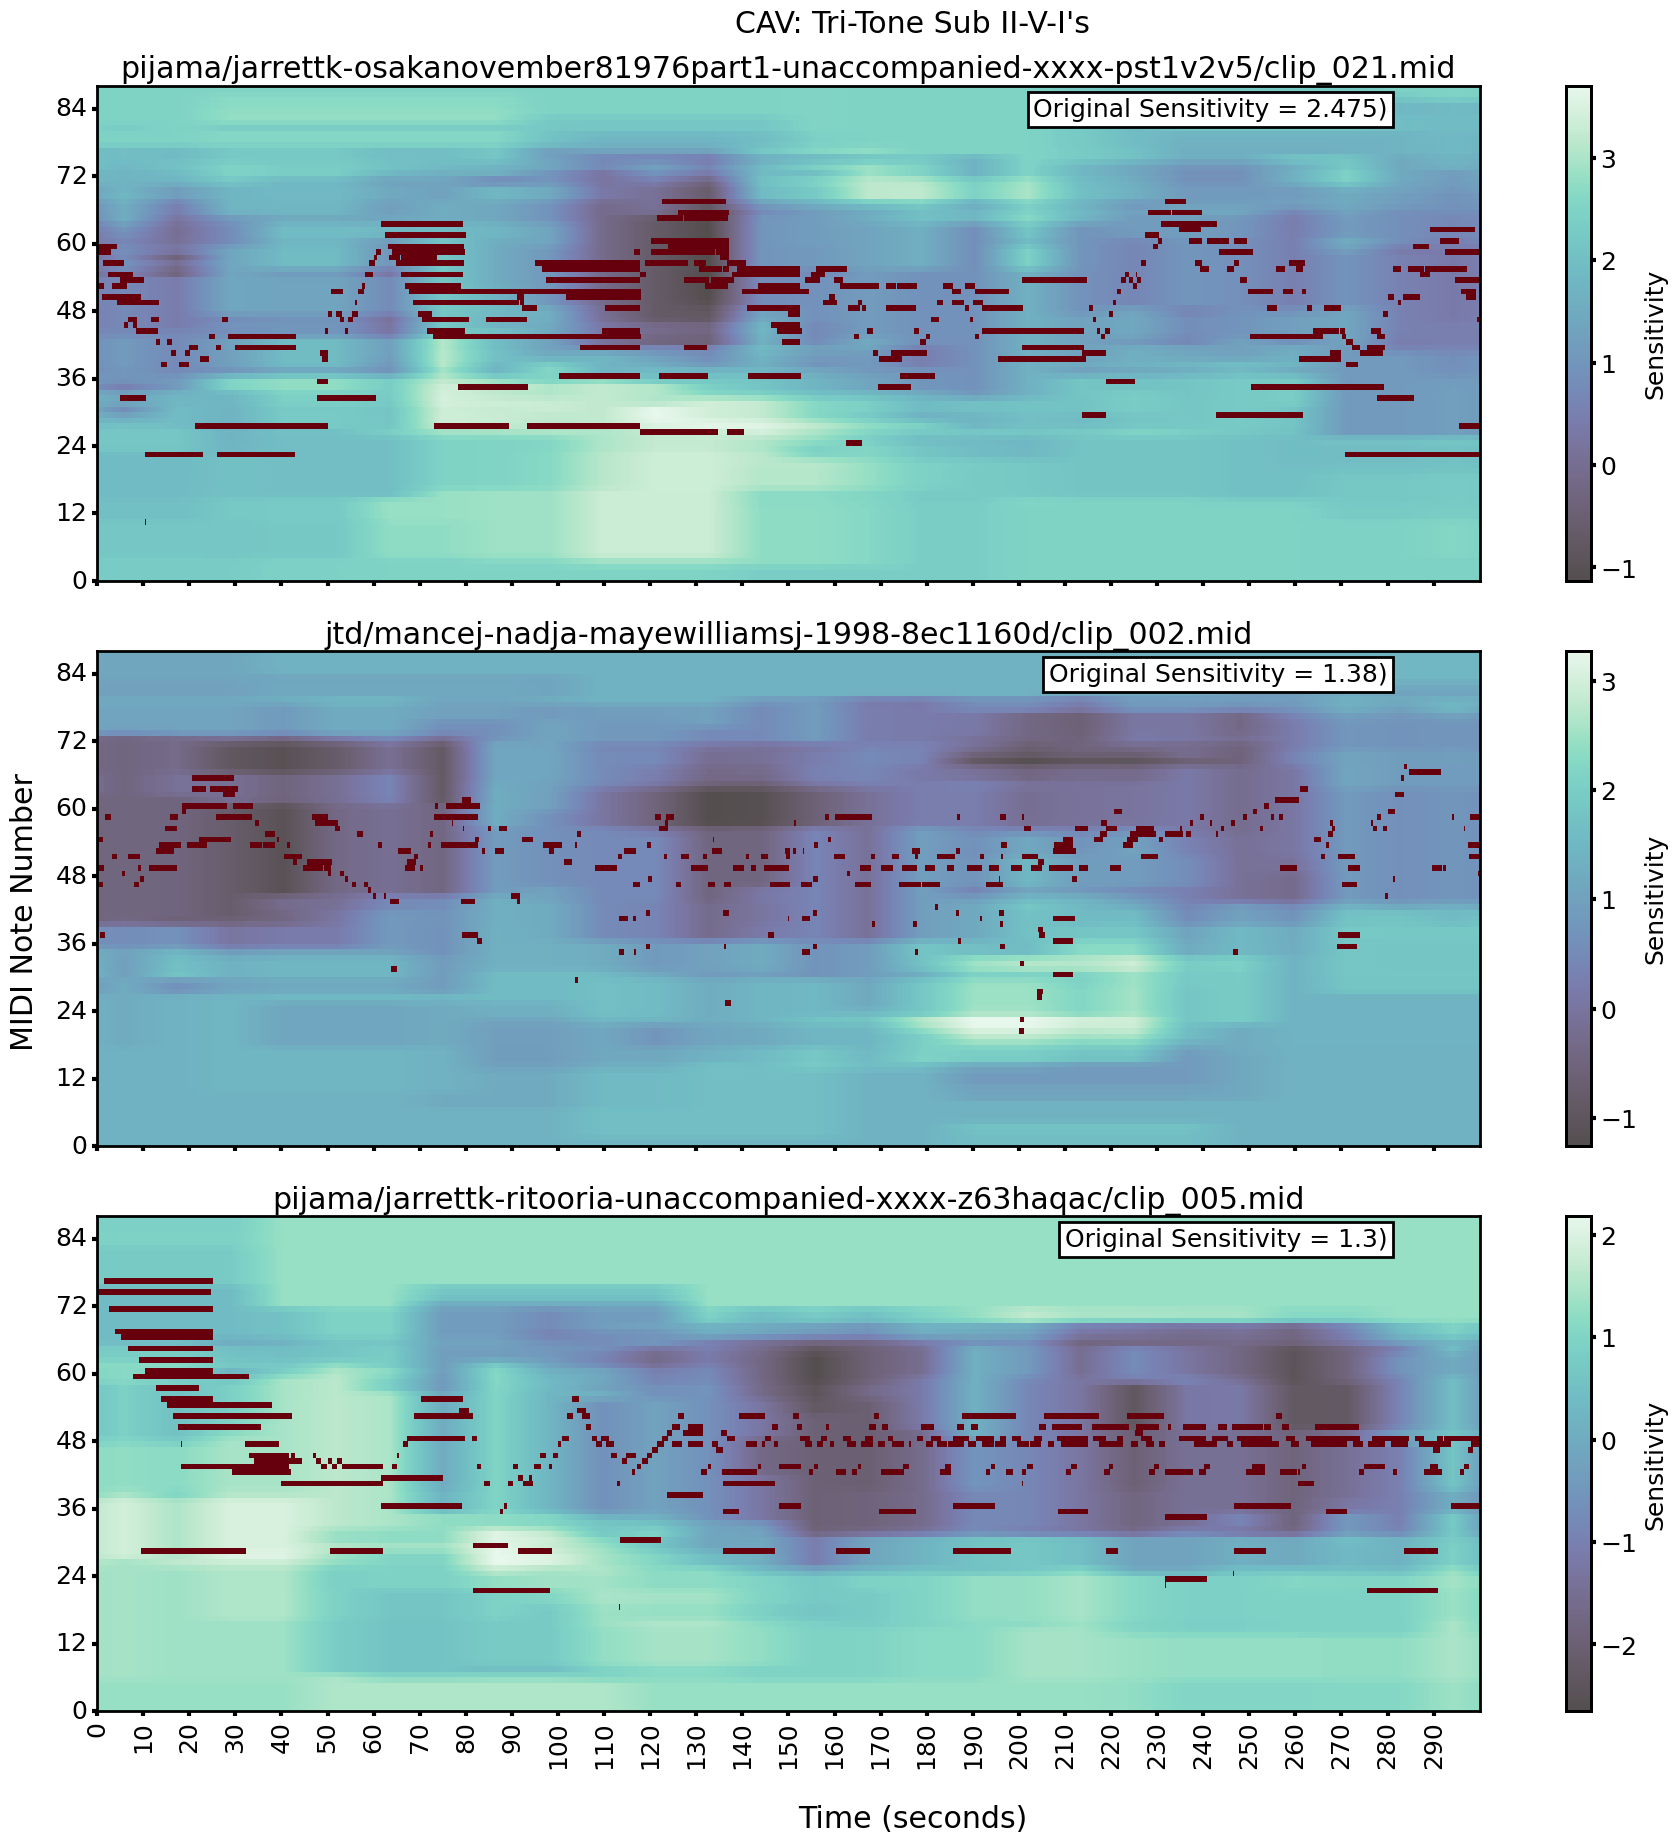

Polychordal II-V-I's pijama/evansb-atimeforlove-unaccompanied-xxxx-5mh2rams/clip_009.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Polychordal II-V-I's pijama/evansb-neverletmego-unaccompanied-xxxx-hdvc6a5k/clip_017.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Polychordal II-V-I's pijama/wilsont-teafortwo-unaccompanied-xxxx-ptbs1qzd/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

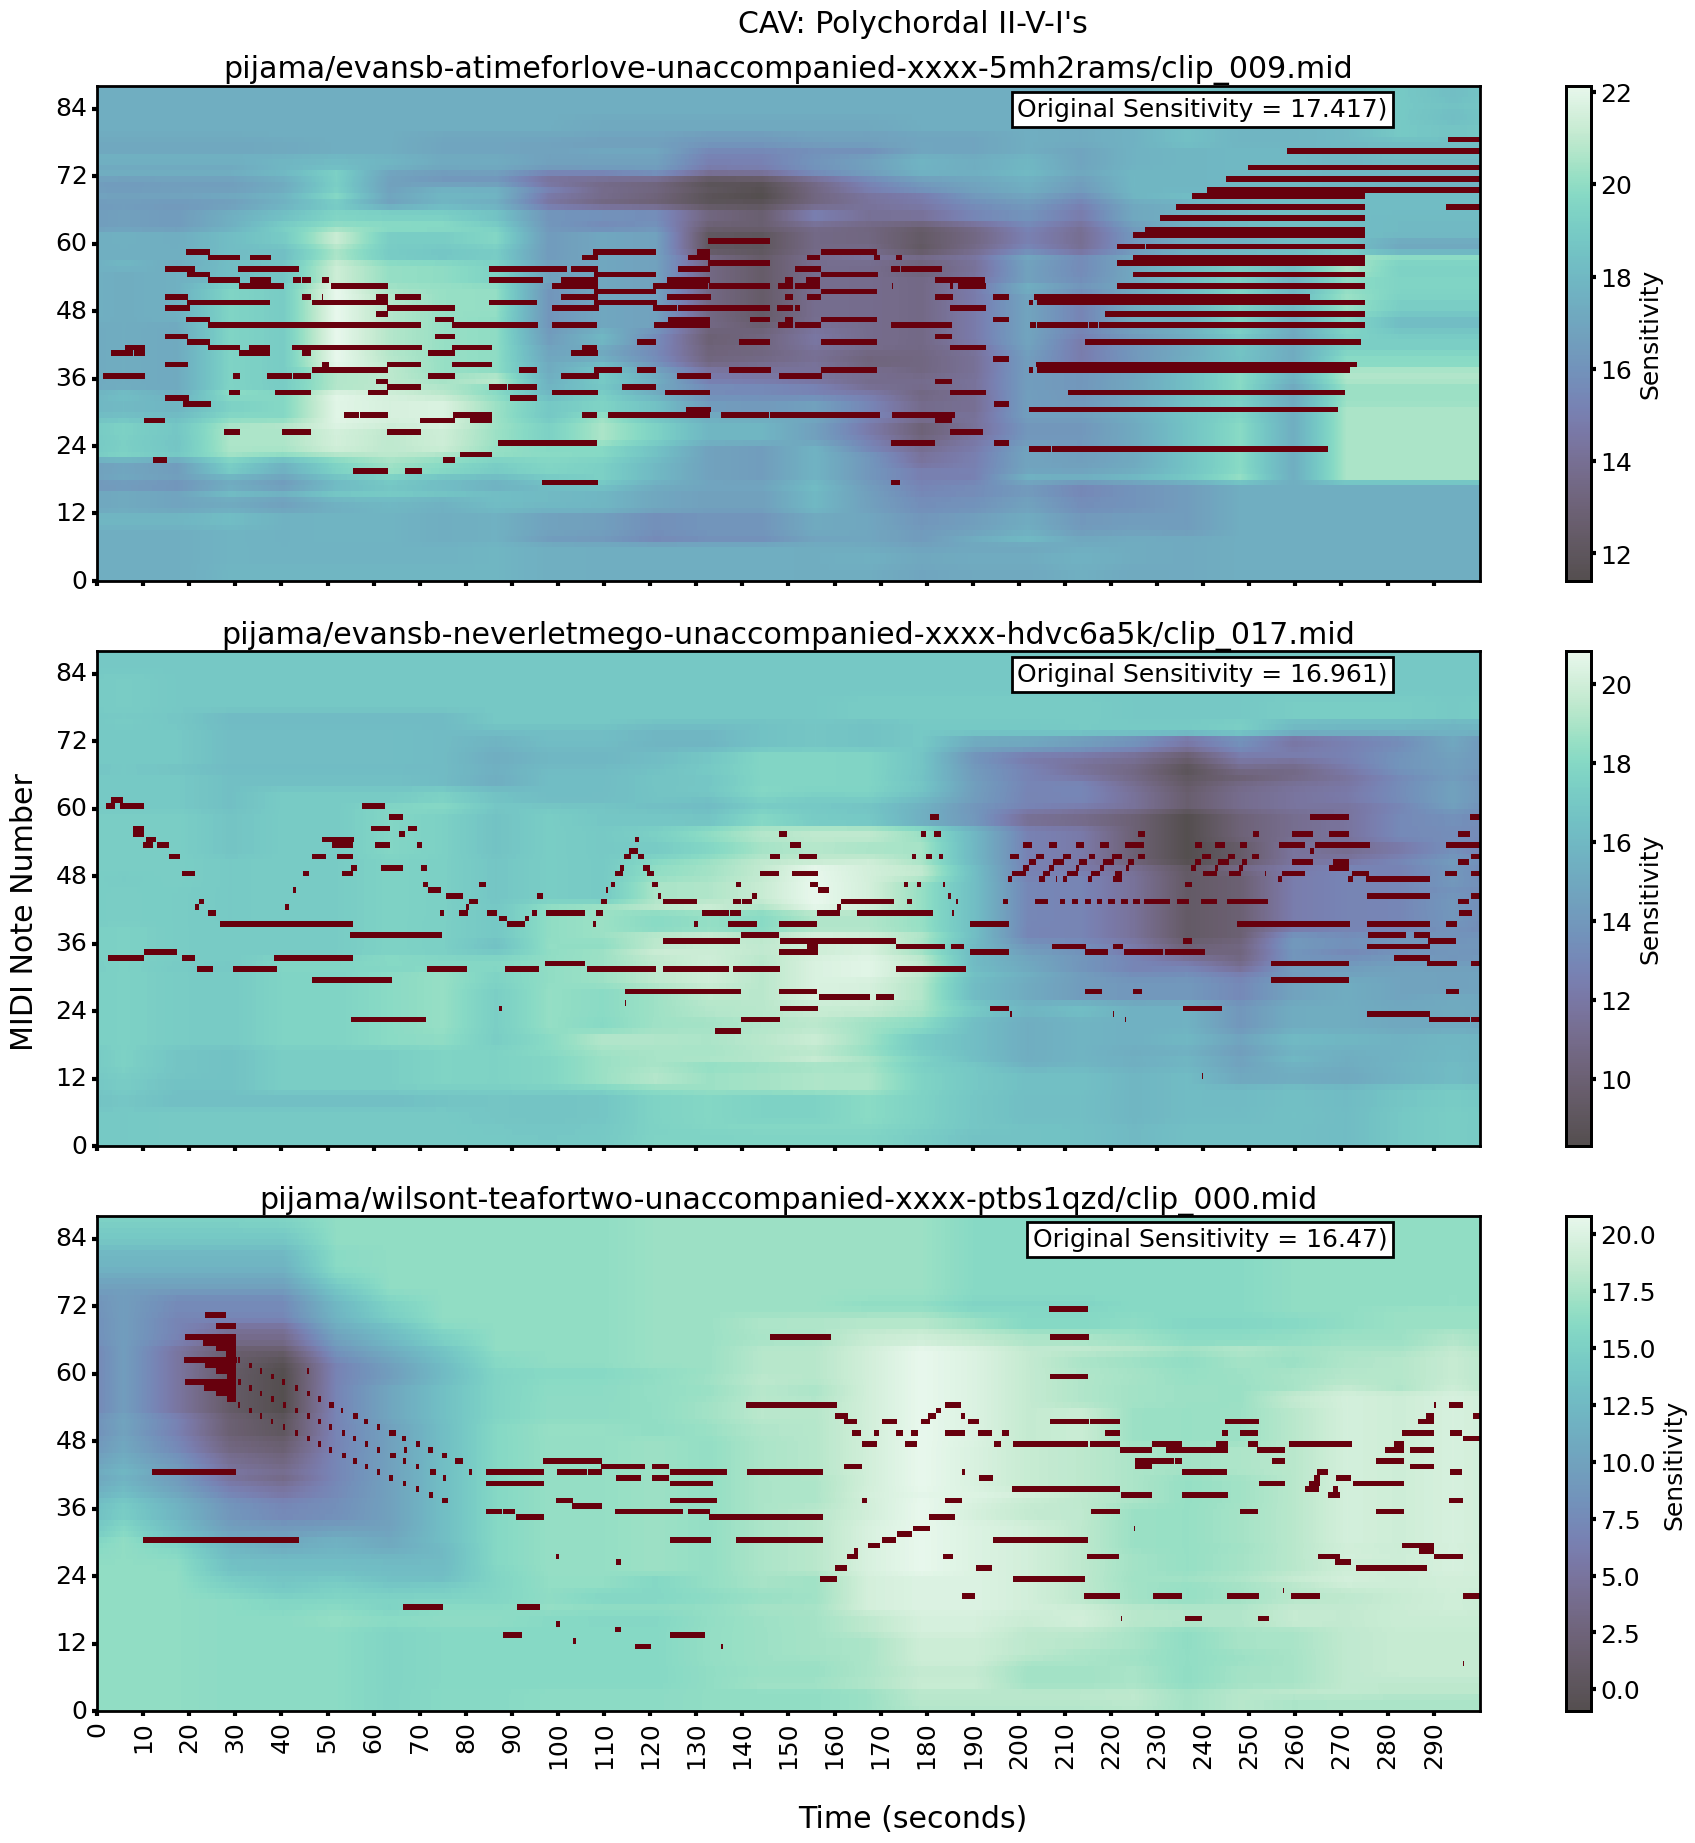

Cycling Altered Dominants jtd/petersono-betterlucknexttime-brownrthigpene-1961-db8ec00c/clip_007.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Cycling Altered Dominants pijama/alleng-godsancientsky-unaccompanied-xxxx-224gmzlu/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Cycling Altered Dominants jtd/jamala-likesomeoneinlovealternative-crosbyifournierv-1959-f4a5da5b/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

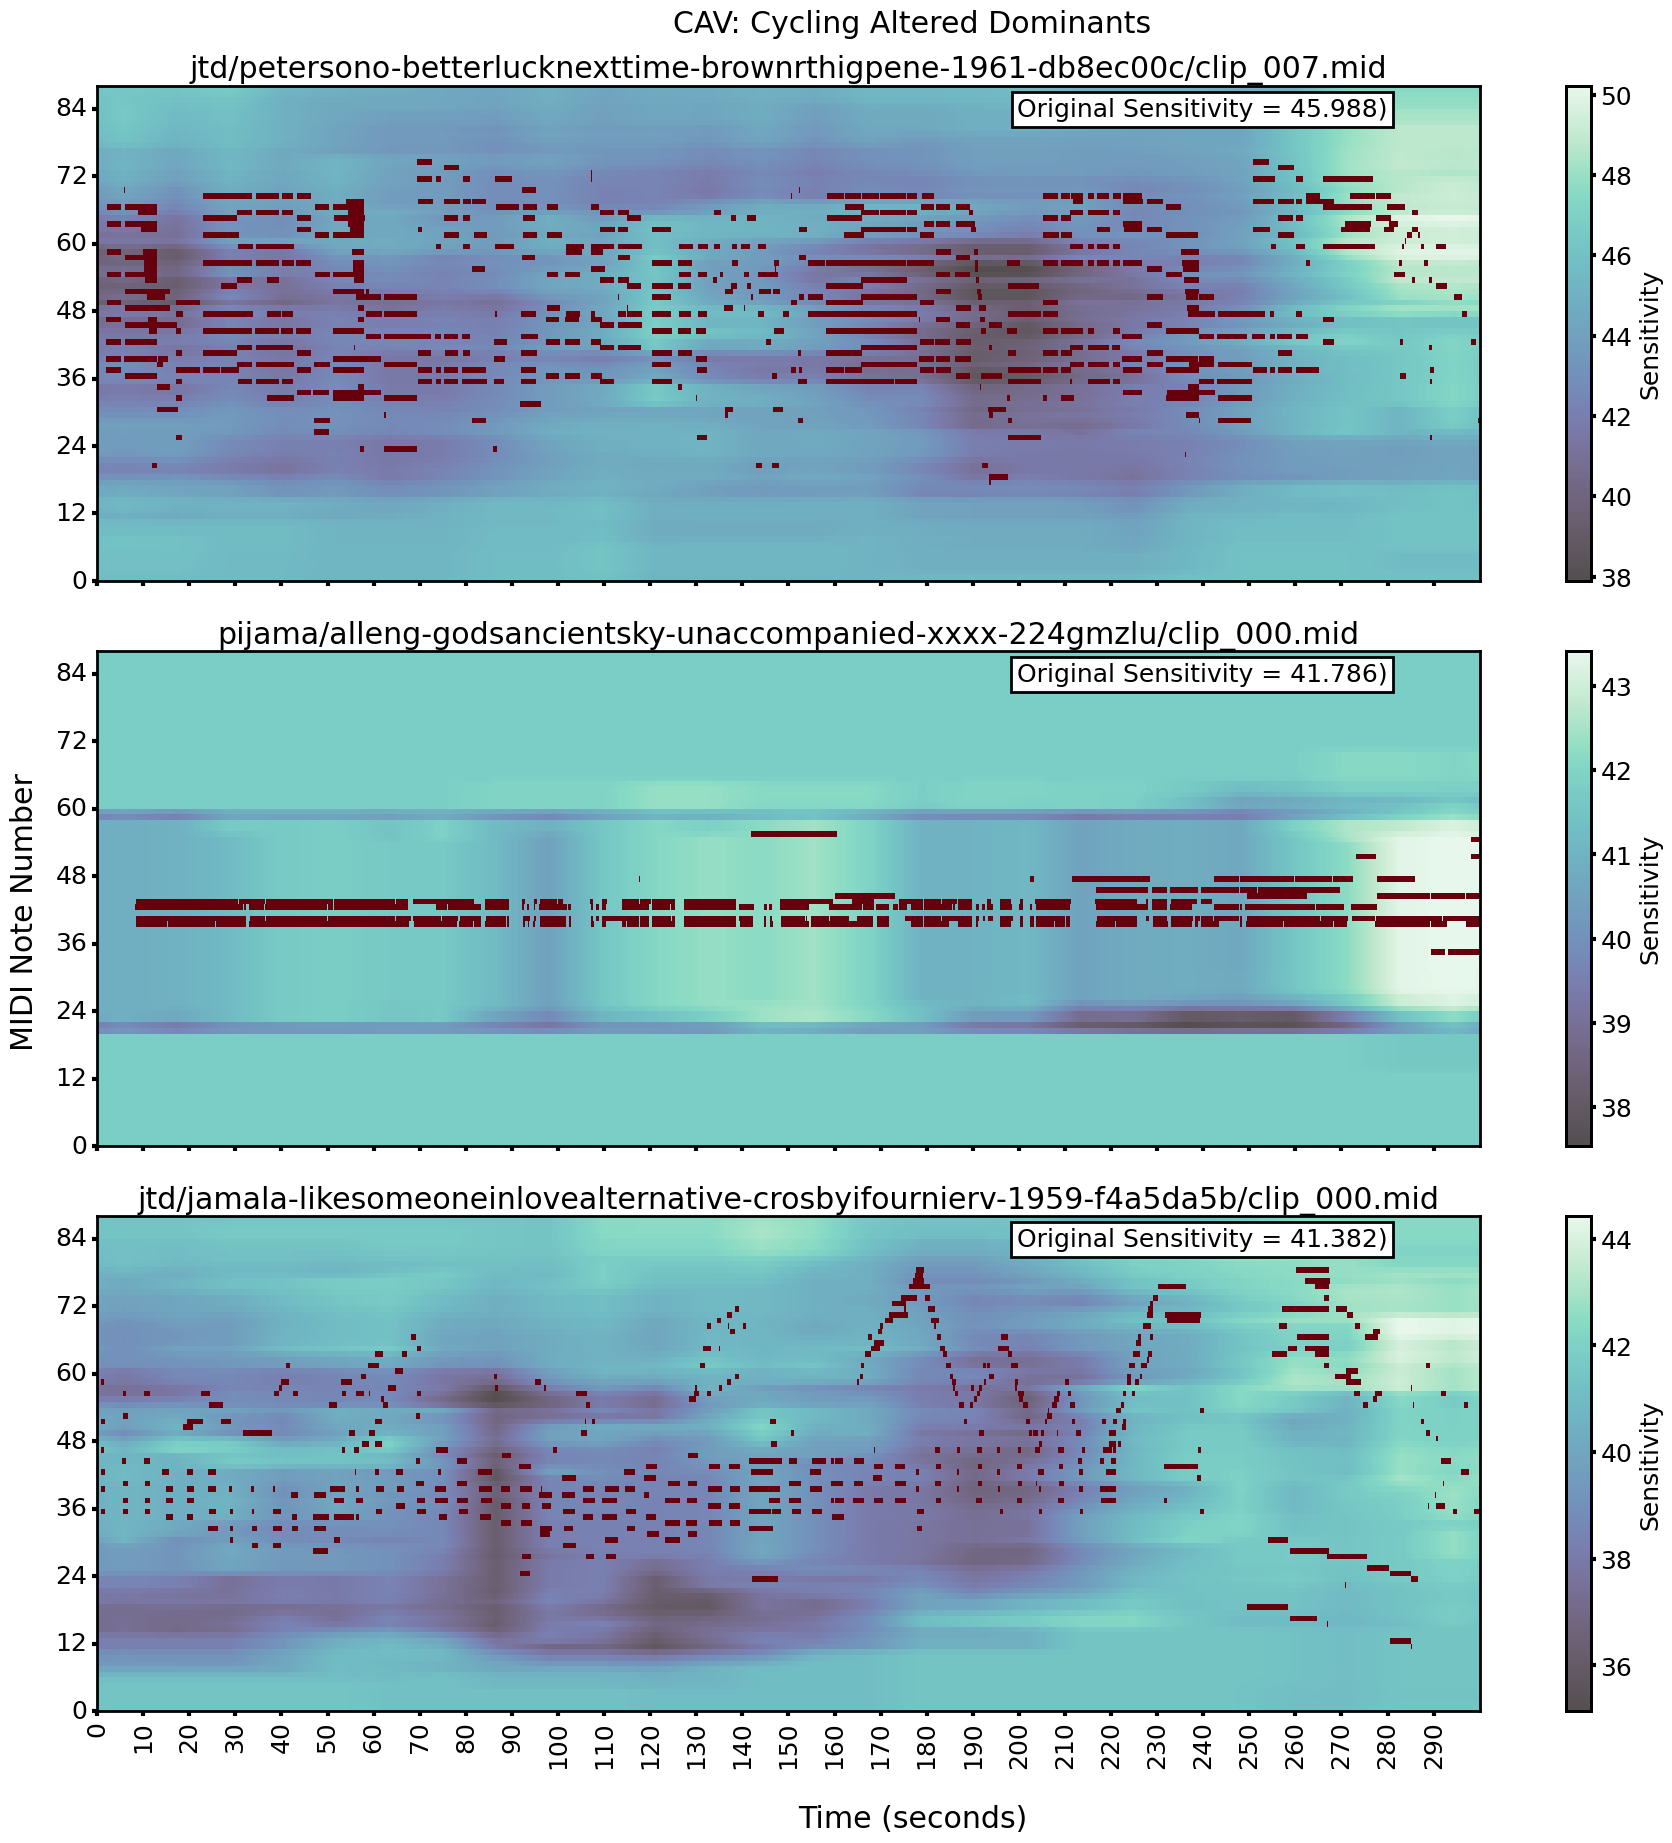

Polychordal Blues Voicings pijama/ibrahima-forcoltrane-unaccompanied-xxxx-esbwjxxi/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Polychordal Blues Voicings pijama/mehldaub-ix-unaccompanied-xxxx-id6ylbmq/clip_002.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Polychordal Blues Voicings pijama/tynerm-songformyladylive-unaccompanied-xxxx-h3g6eqgm/clip_004.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

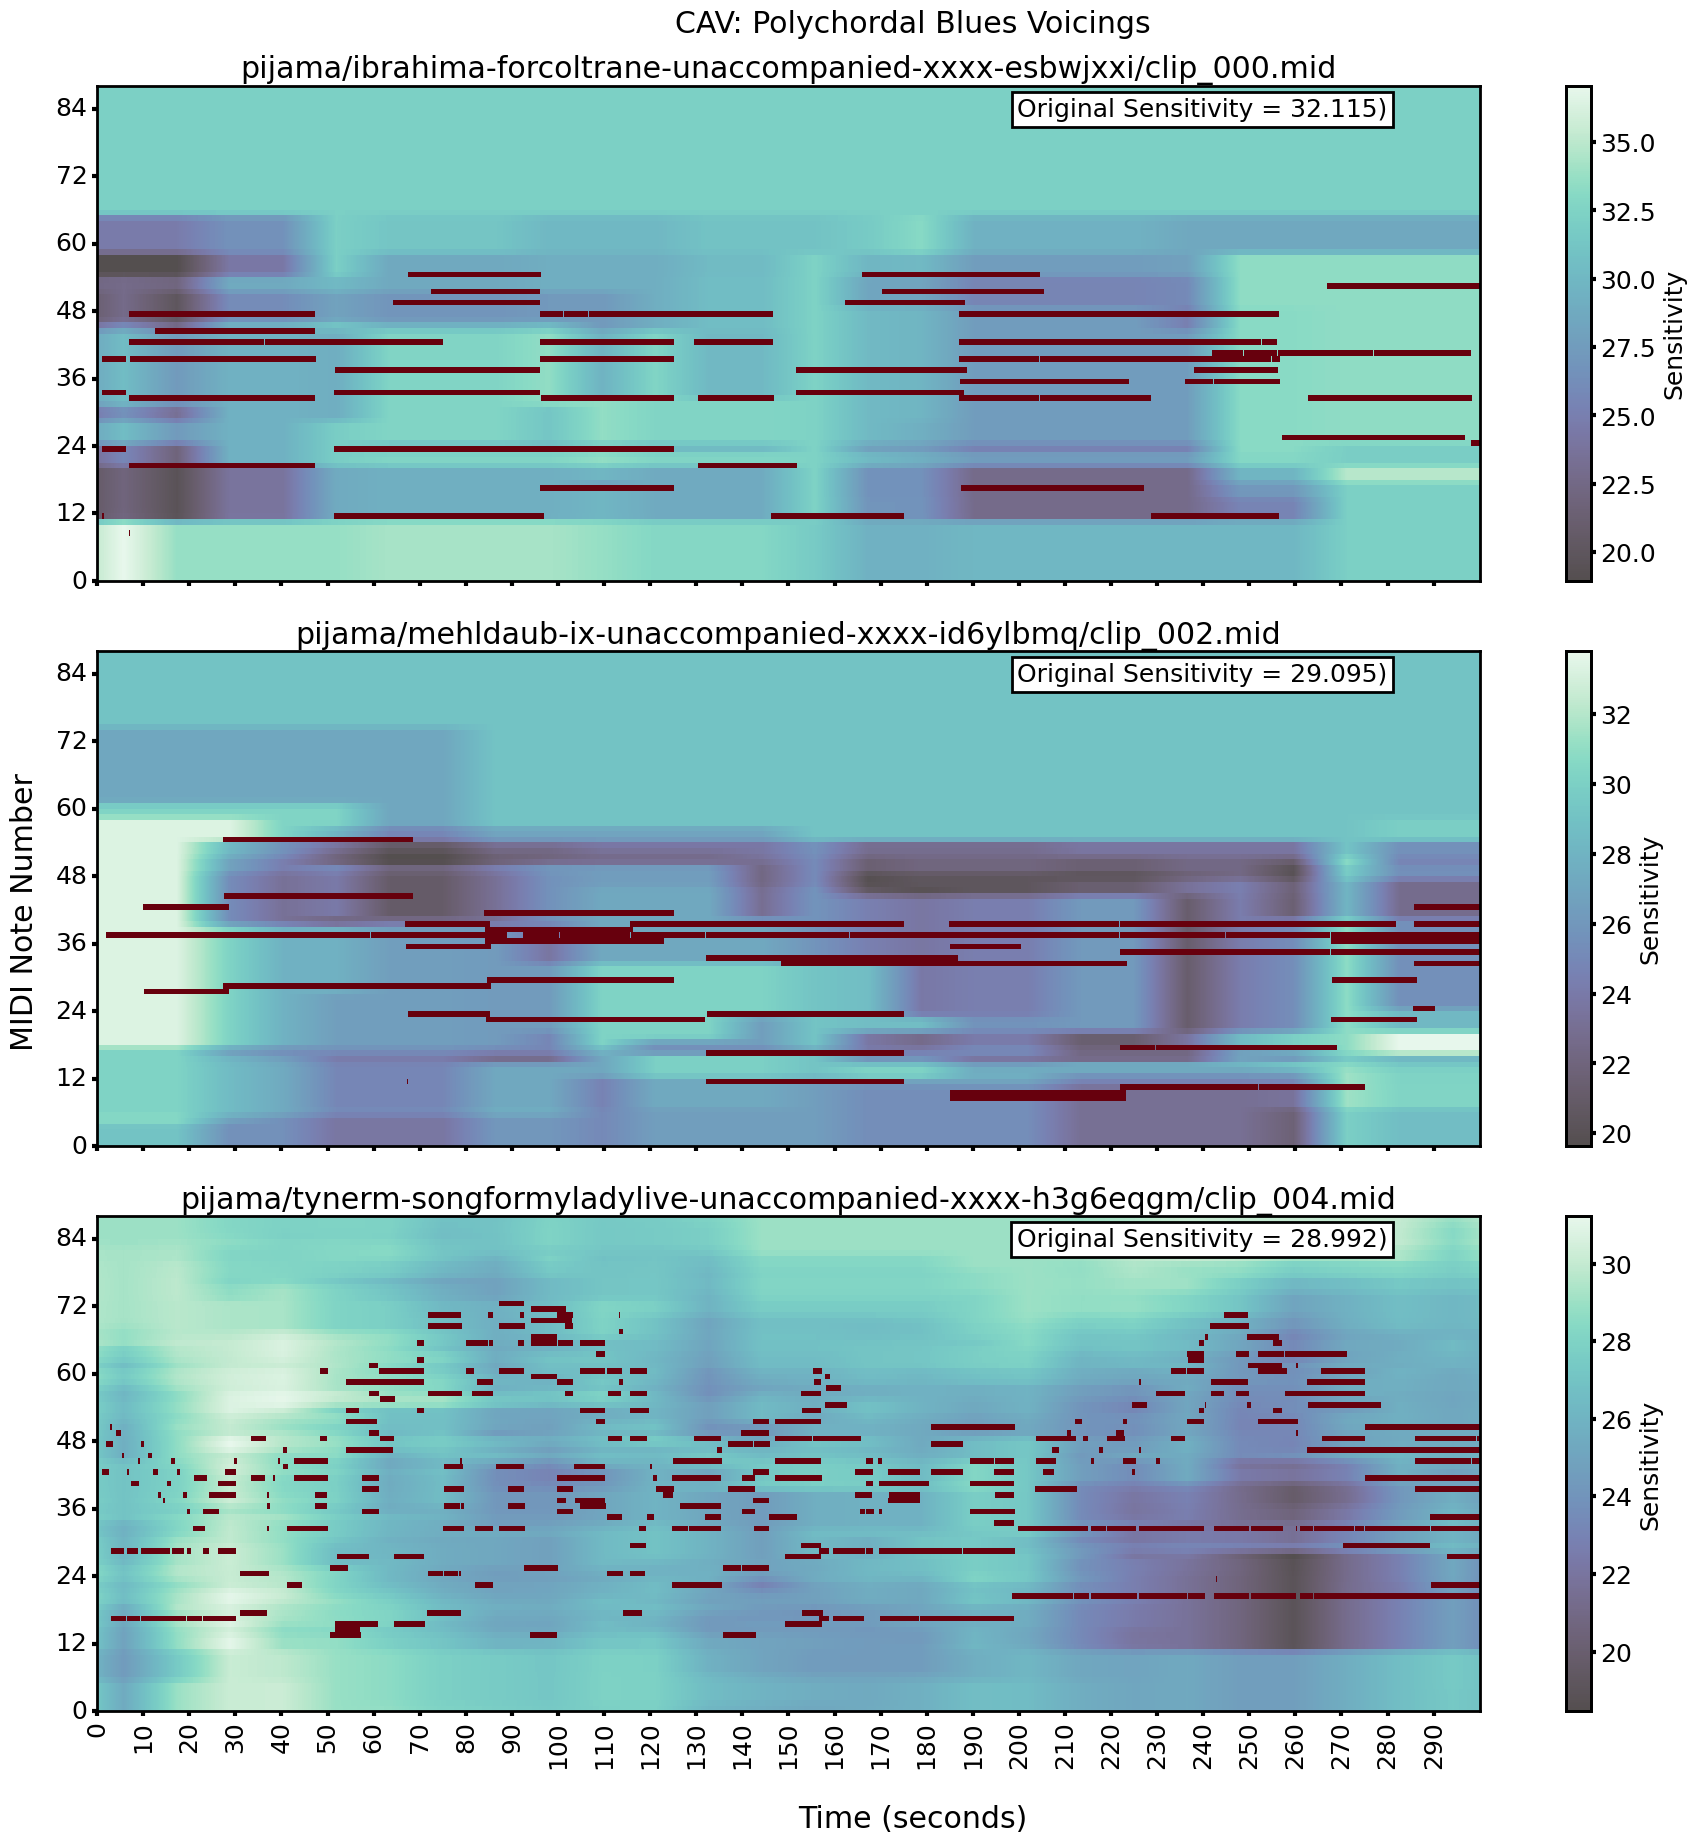

Fourthy Blues Voicings pijama/mehldaub-heyyoulive-unaccompanied-xxxx-levtfkvk/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Fourthy Blues Voicings pijama/mehldaub-andiloveherlive-unaccompanied-xxxx-as1cgema/clip_016.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Fourthy Blues Voicings pijama/jarrettk-osakanovember81976part1-unaccompanied-xxxx-pst1v2v5/clip_040.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

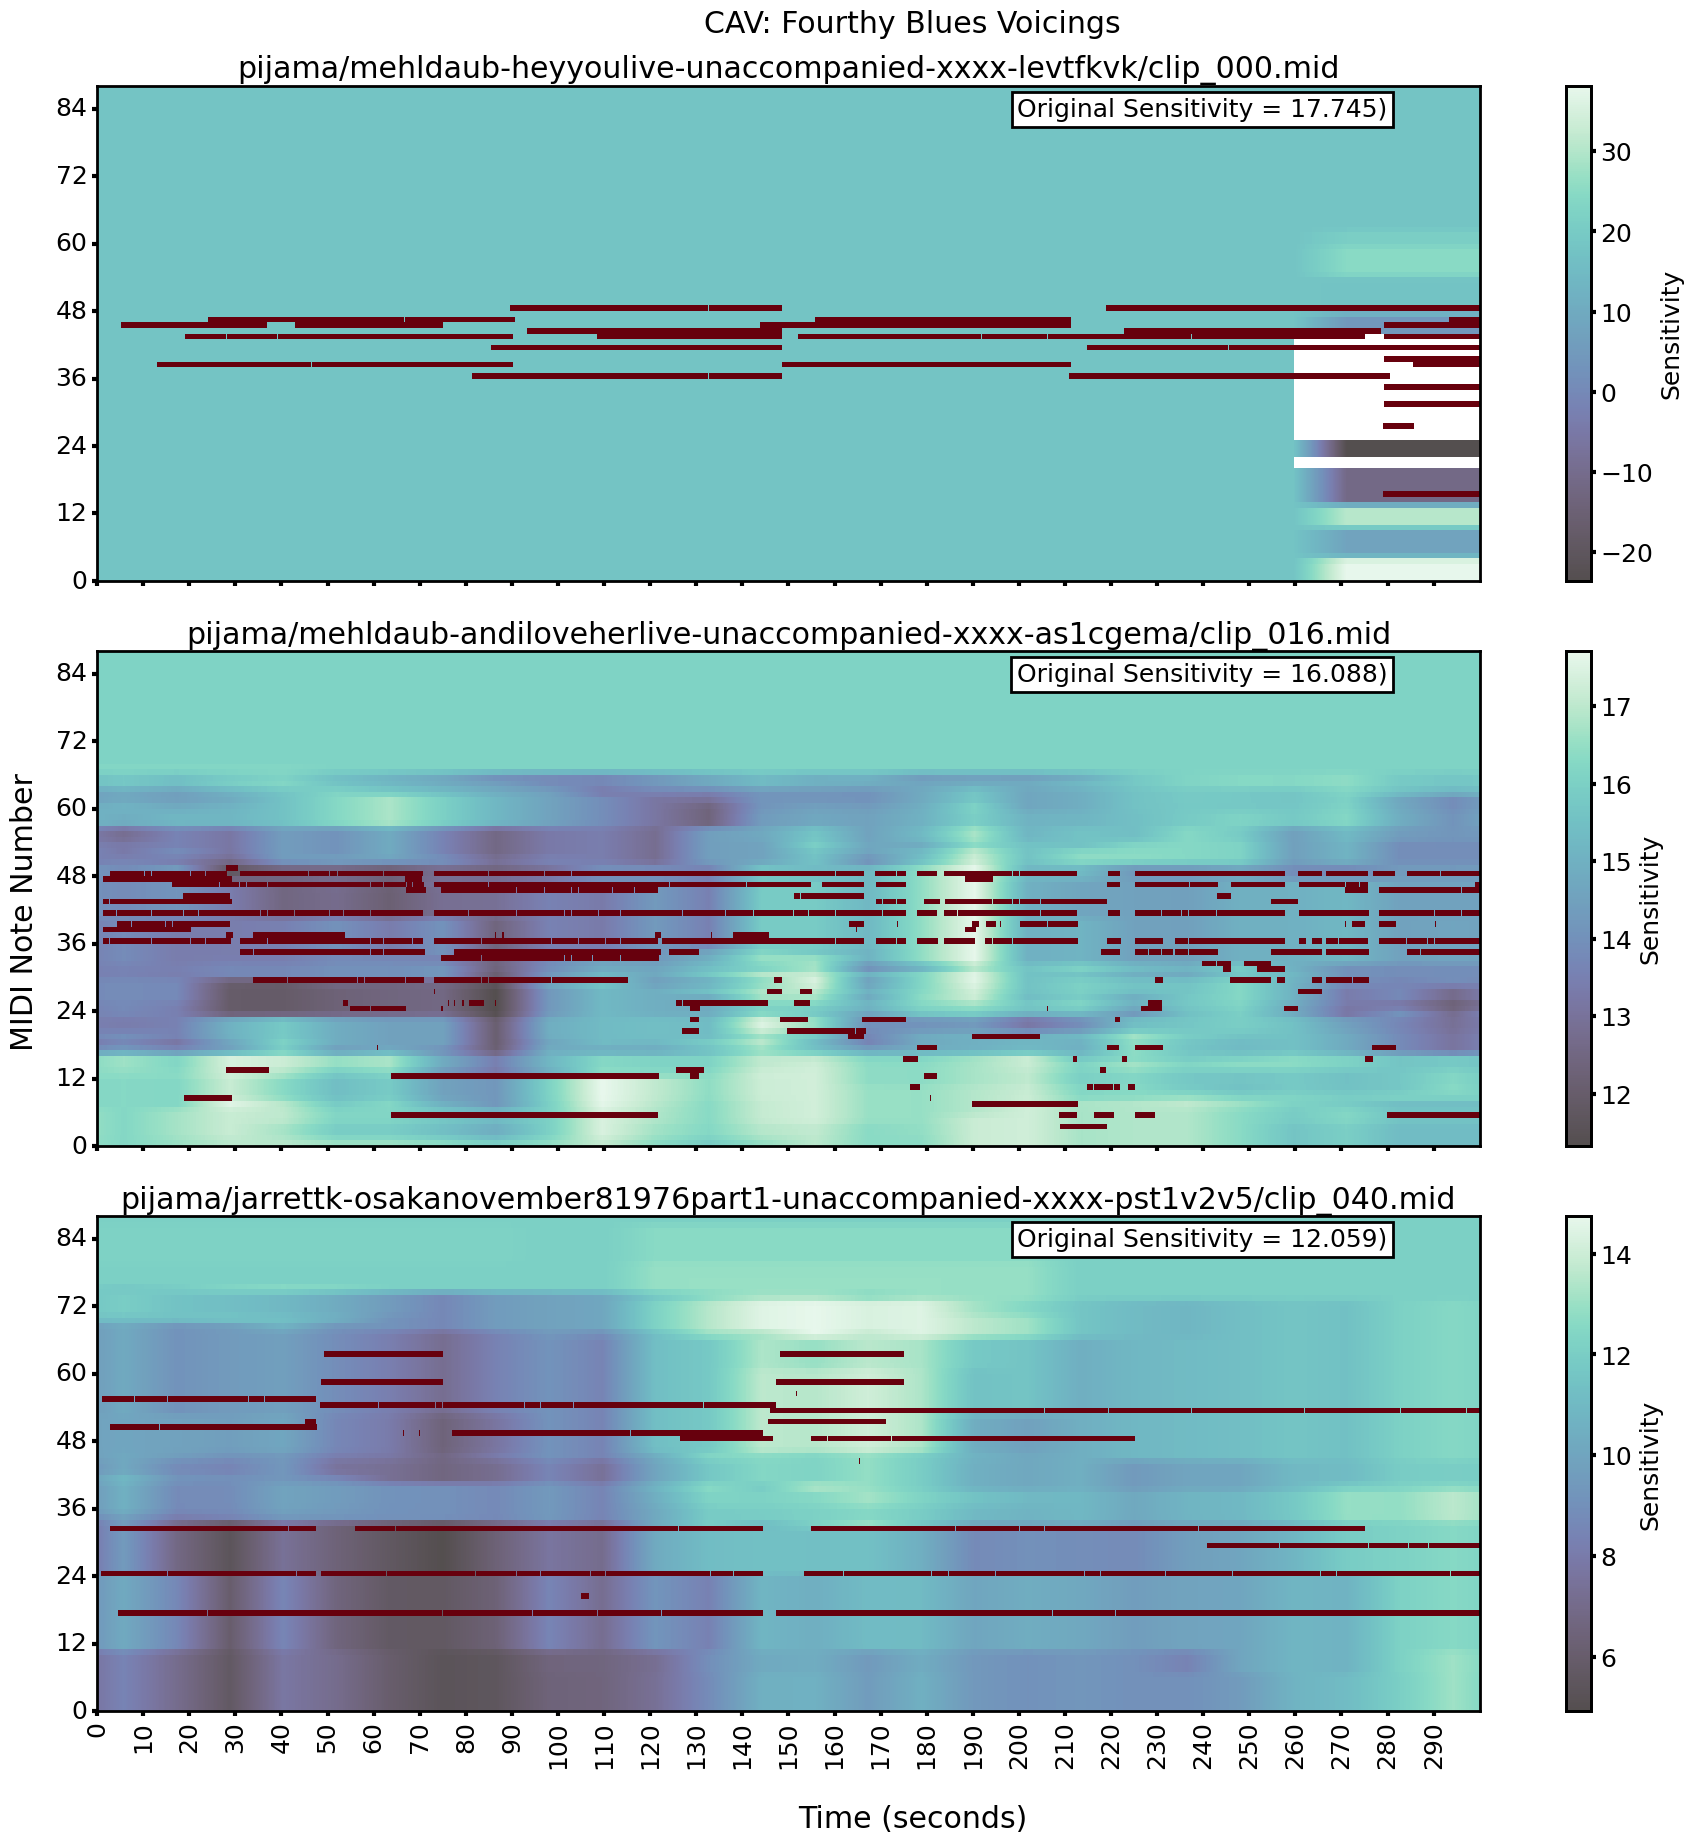

Major 7th Blues Voicings pijama/mehldaub-knivesoutlive-unaccompanied-xxxx-kwpzz1ym/clip_018.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Major 7th Blues Voicings jtd/drewk-nogreaterlove-rstednqueena-1988-321d8806/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Major 7th Blues Voicings pijama/coreac-someonetowatchoverme-unaccompanied-xxxx-i61luj9d/clip_014.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

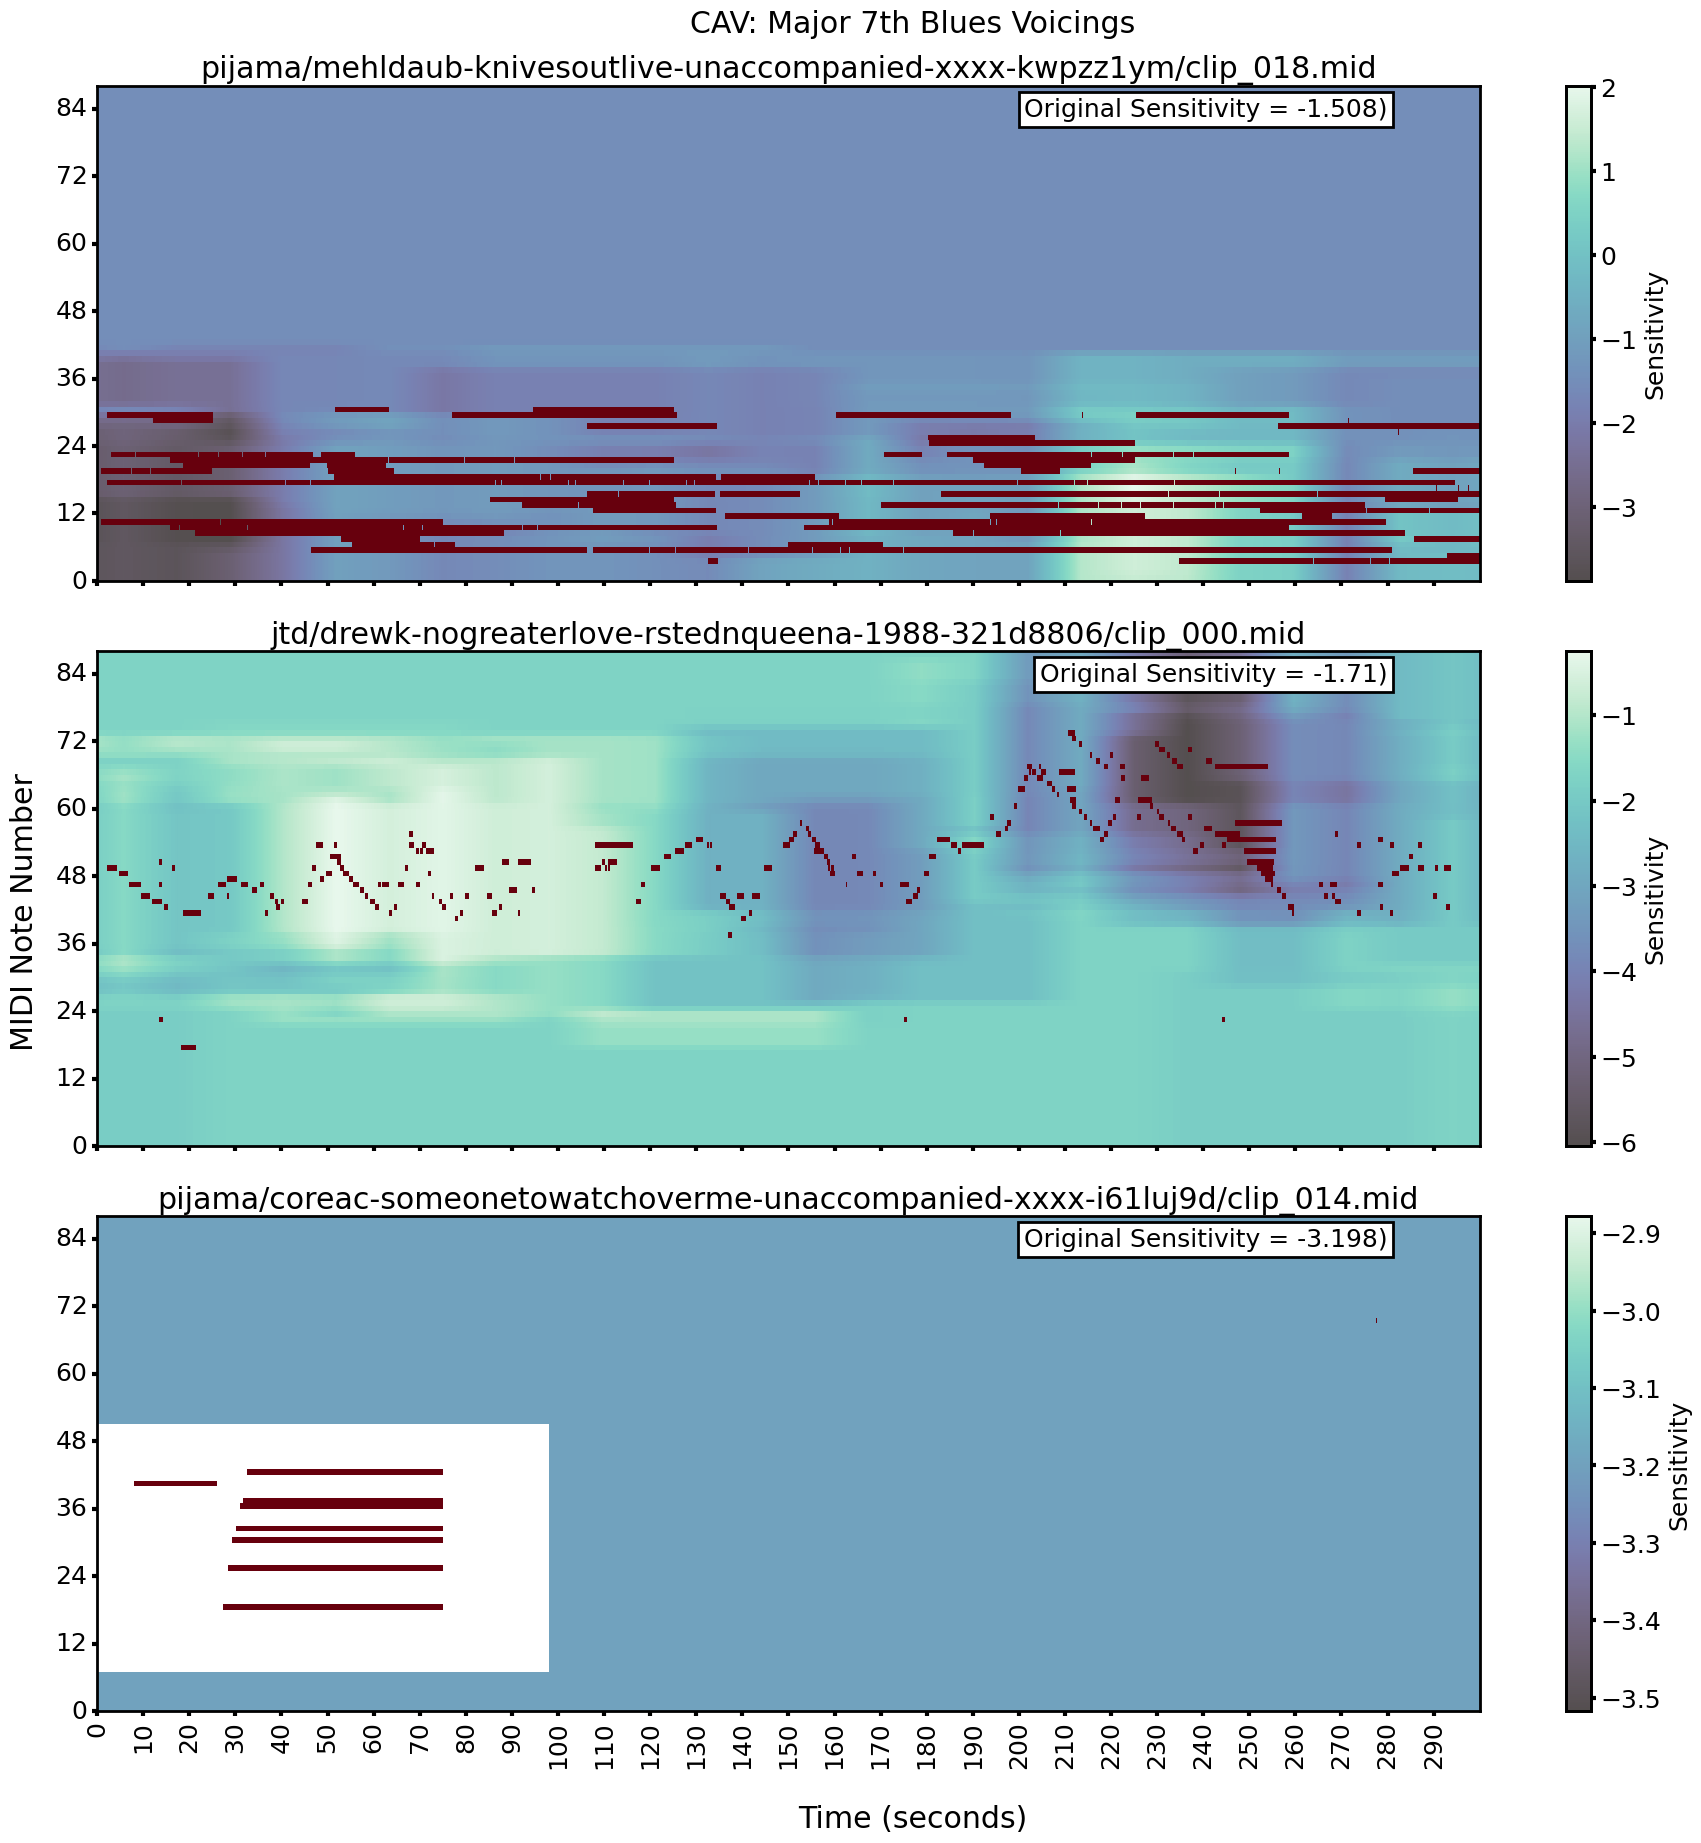

Minor Blues Voicings pijama/mehldaub-paranoidandroid-unaccompanied-xxxx-bcembqll/clip_011.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Minor Blues Voicings pijama/mehldaub-knivesoutlive-unaccompanied-xxxx-kwpzz1ym/clip_017.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Minor Blues Voicings pijama/mehldaub-paranoidandroid-unaccompanied-xxxx-bcembqll/clip_010.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

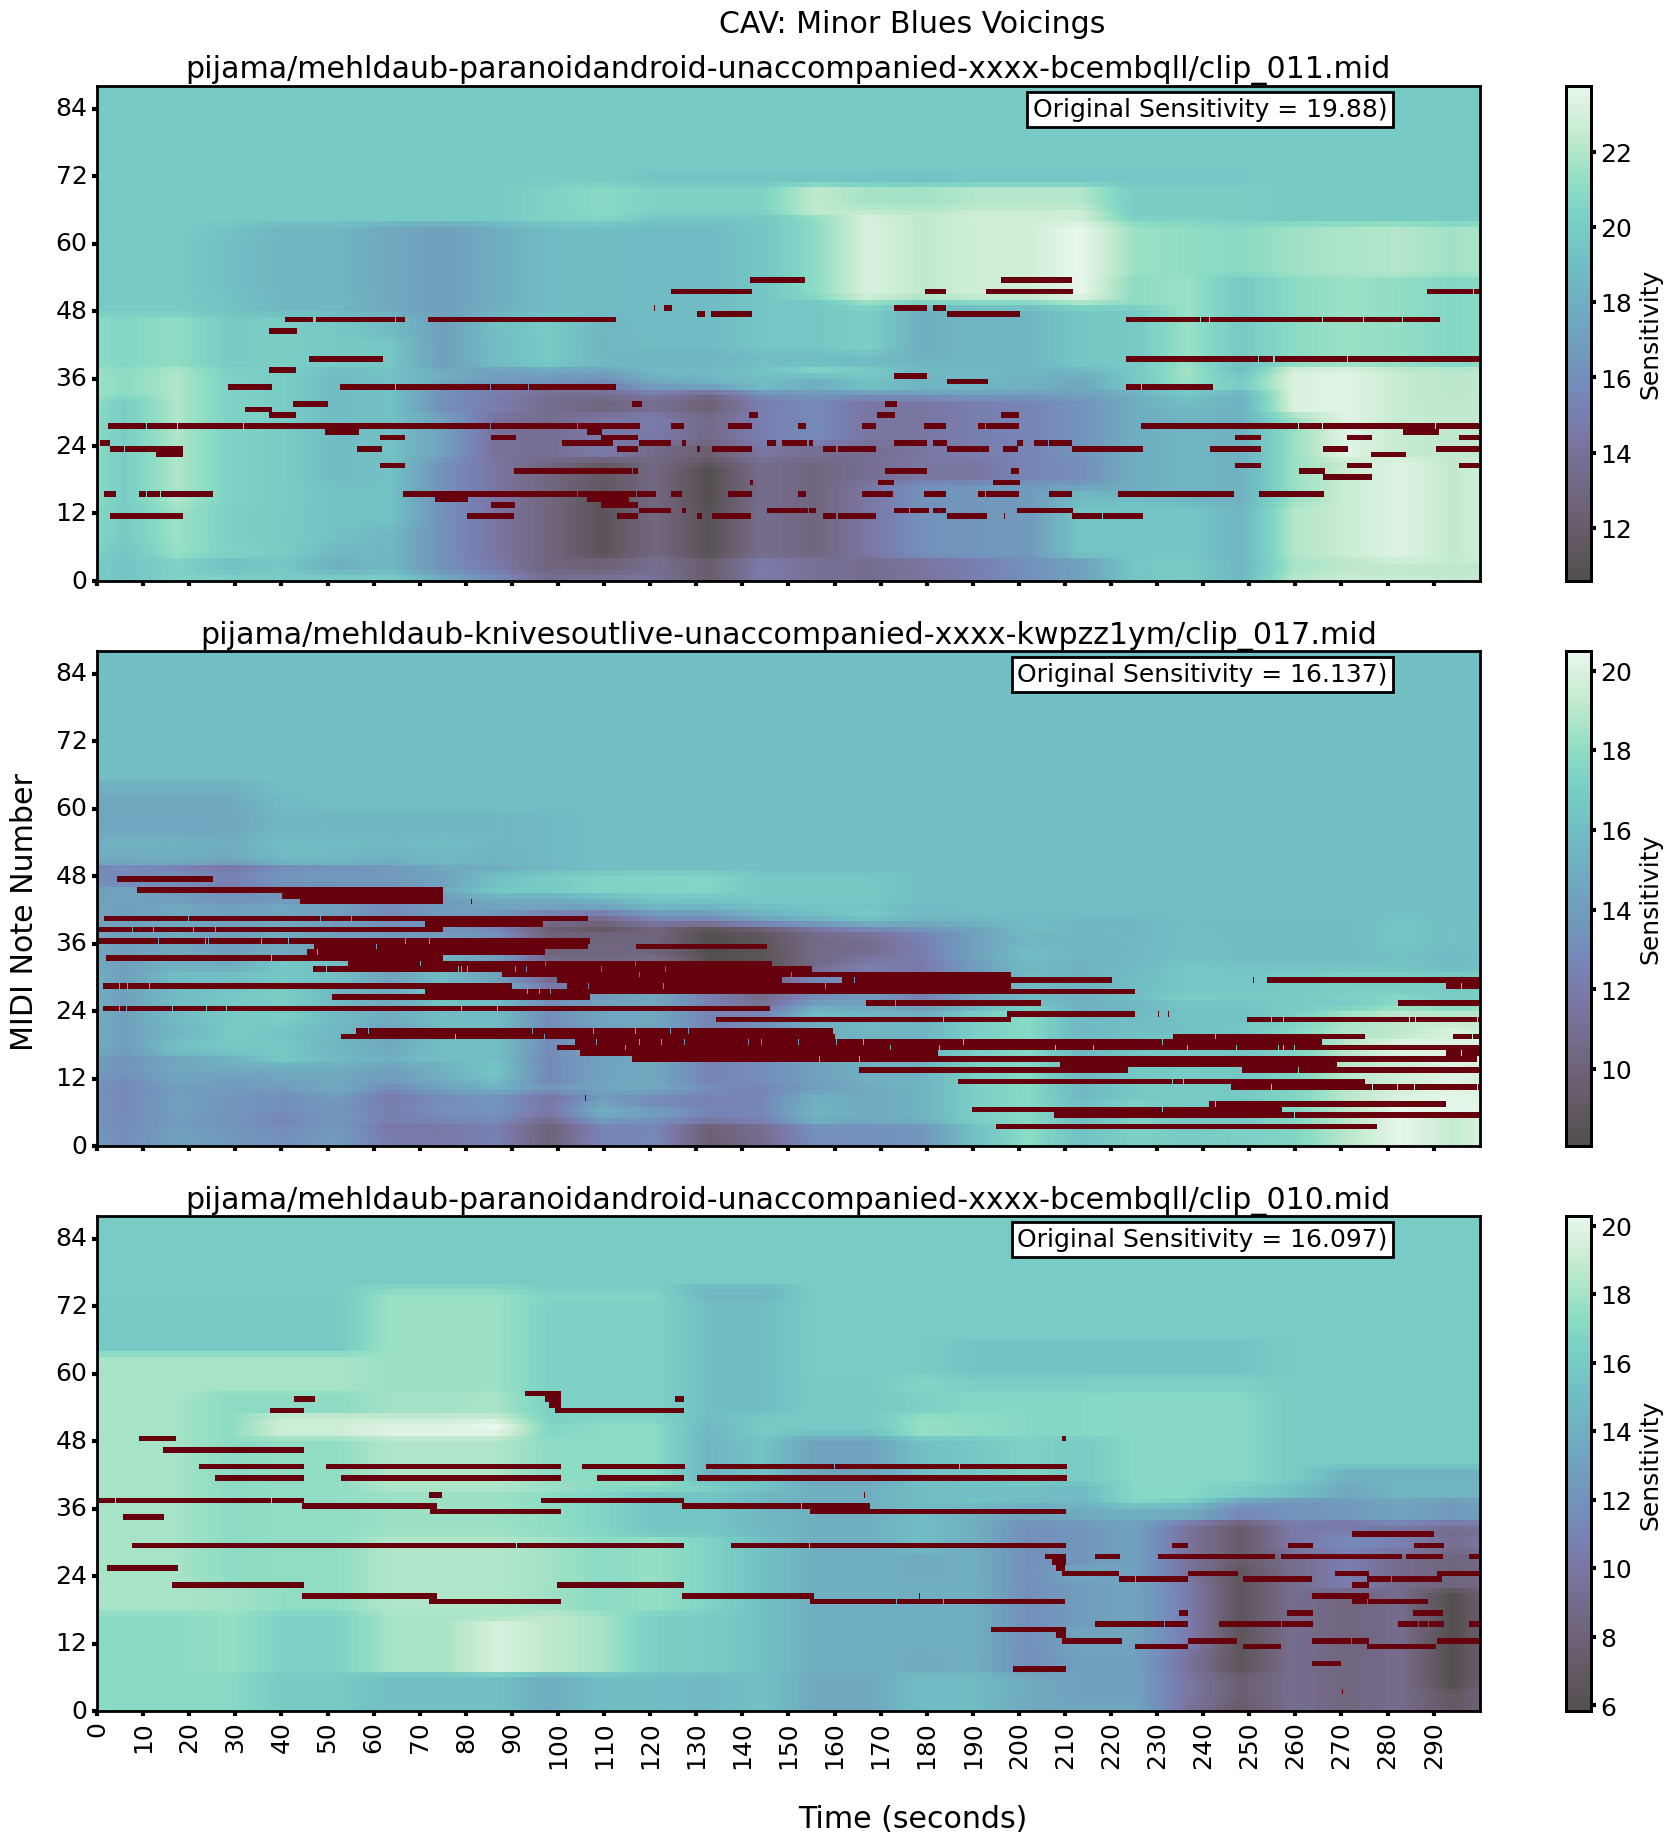

Dominant 7th Polychords pijama/jonesh-pleasedonttalkaboutmewhen-unaccompanied-xxxx-5wmnpx1x/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Dominant 7th Polychords pijama/alleng-godsancientsky-unaccompanied-xxxx-224gmzlu/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Dominant 7th Polychords pijama/jonesh-squeezemeinstrumental-unaccompanied-xxxx-lcyyturr/clip_003.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

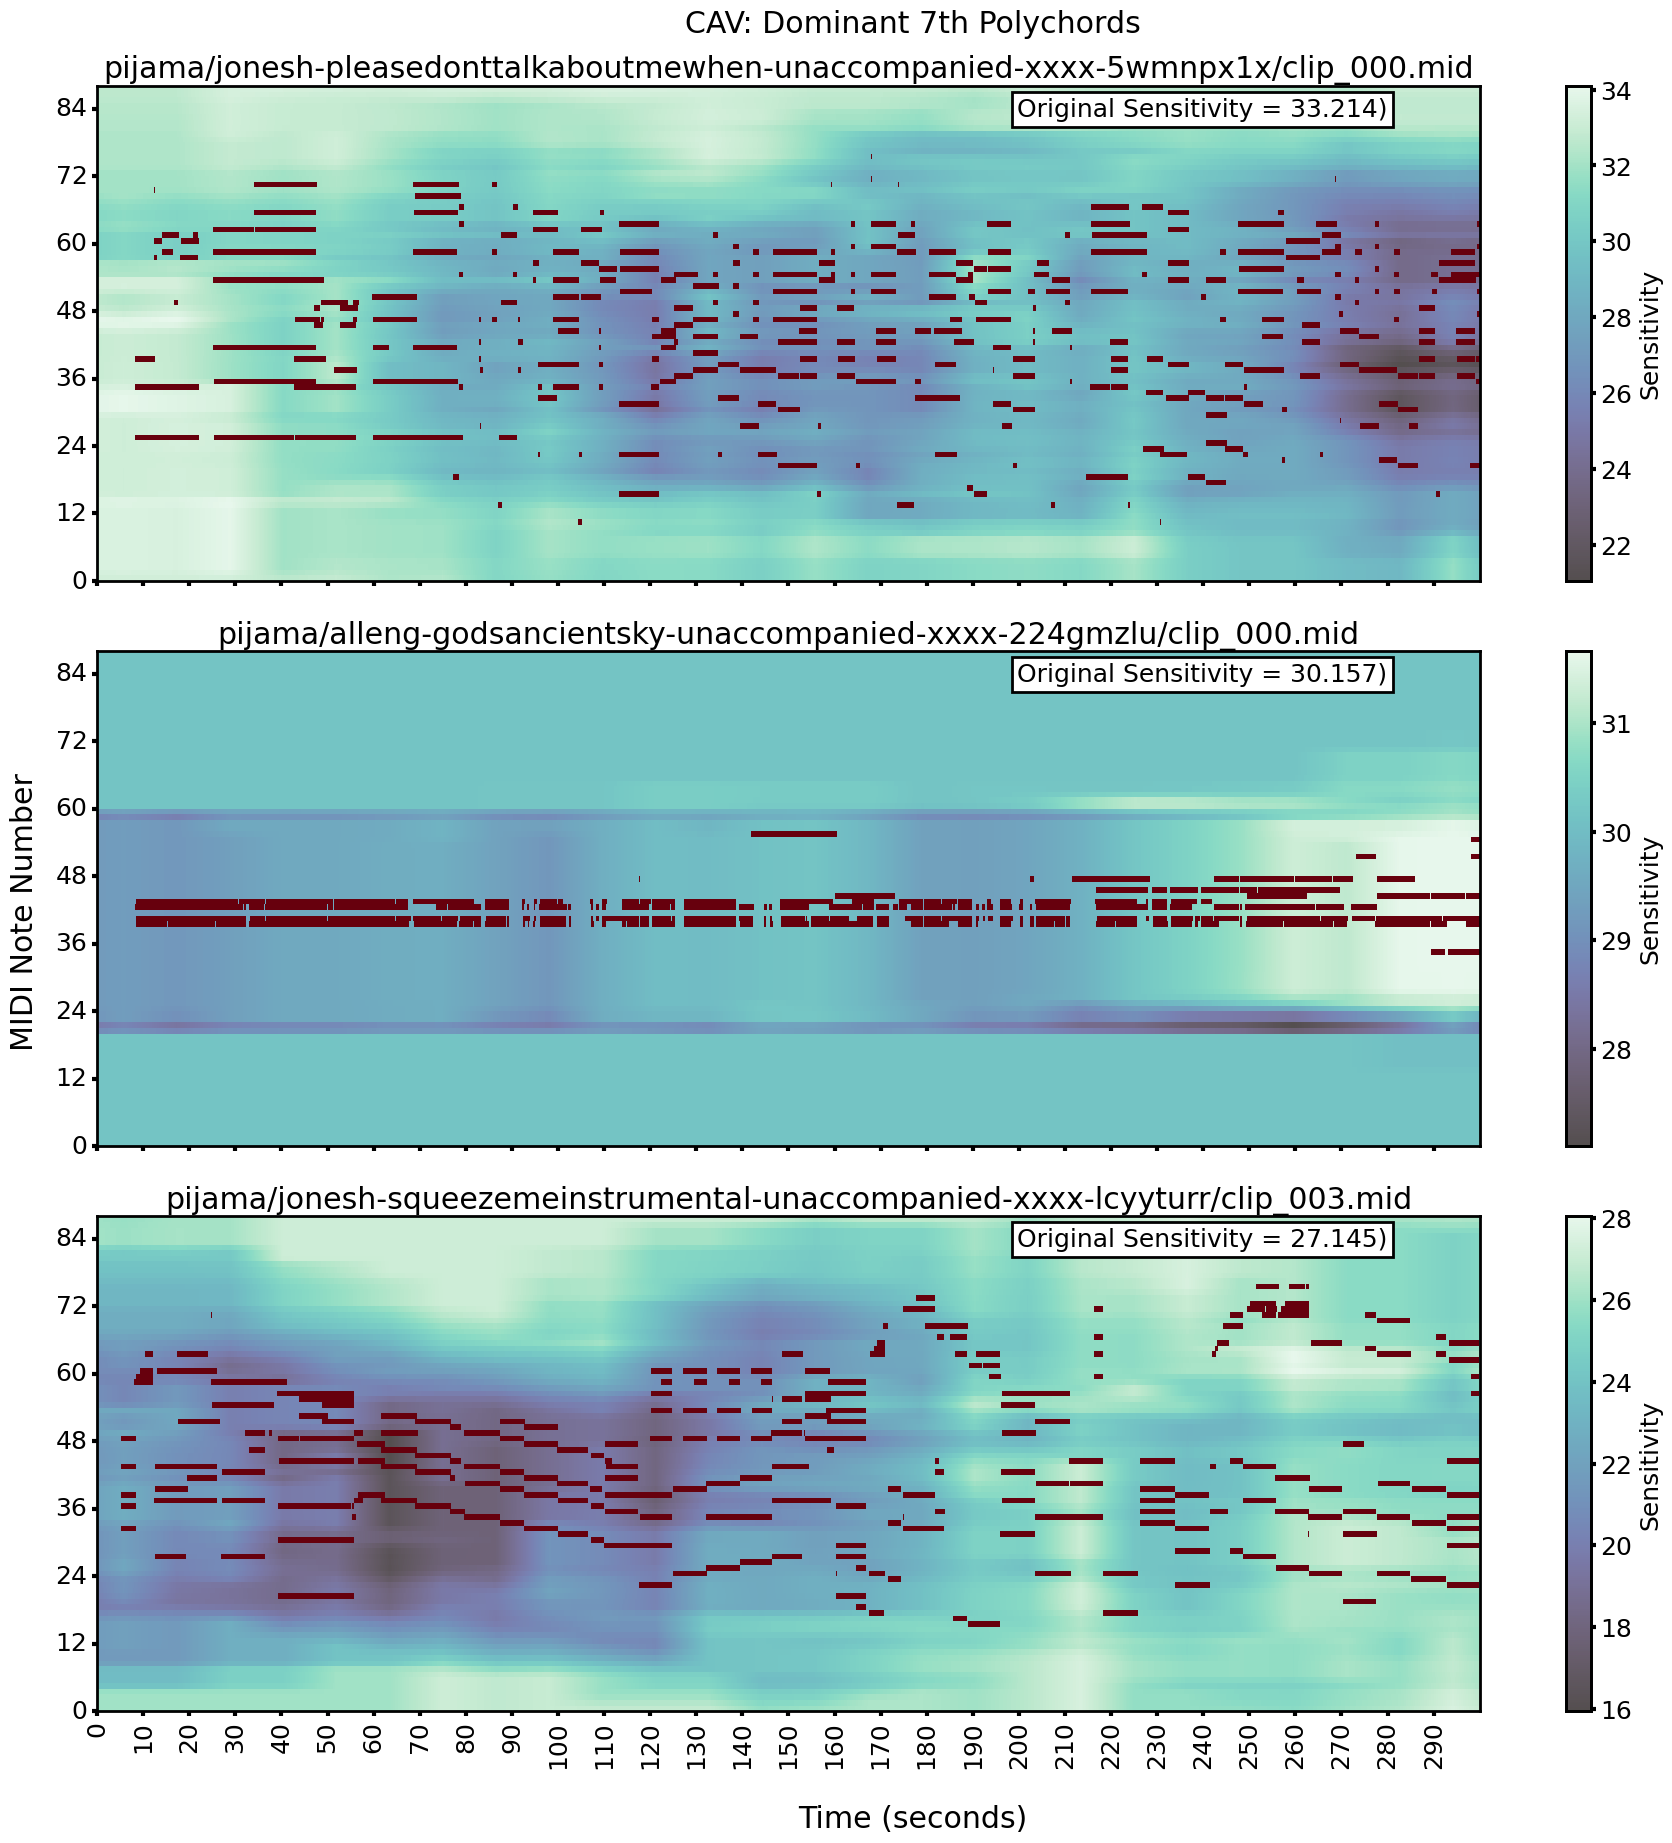

Dominant Polychord Groups jtd/evansb-whocaniturnto-gomezemorellm-1973-99d33ea0/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Dominant Polychord Groups pijama/jonesh-pleasedonttalkaboutmewhen-unaccompanied-xxxx-5wmnpx1x/clip_000.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Dominant Polychord Groups jtd/evansb-whocaniturnto-gomezemorellm-1972-a5ebb859/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

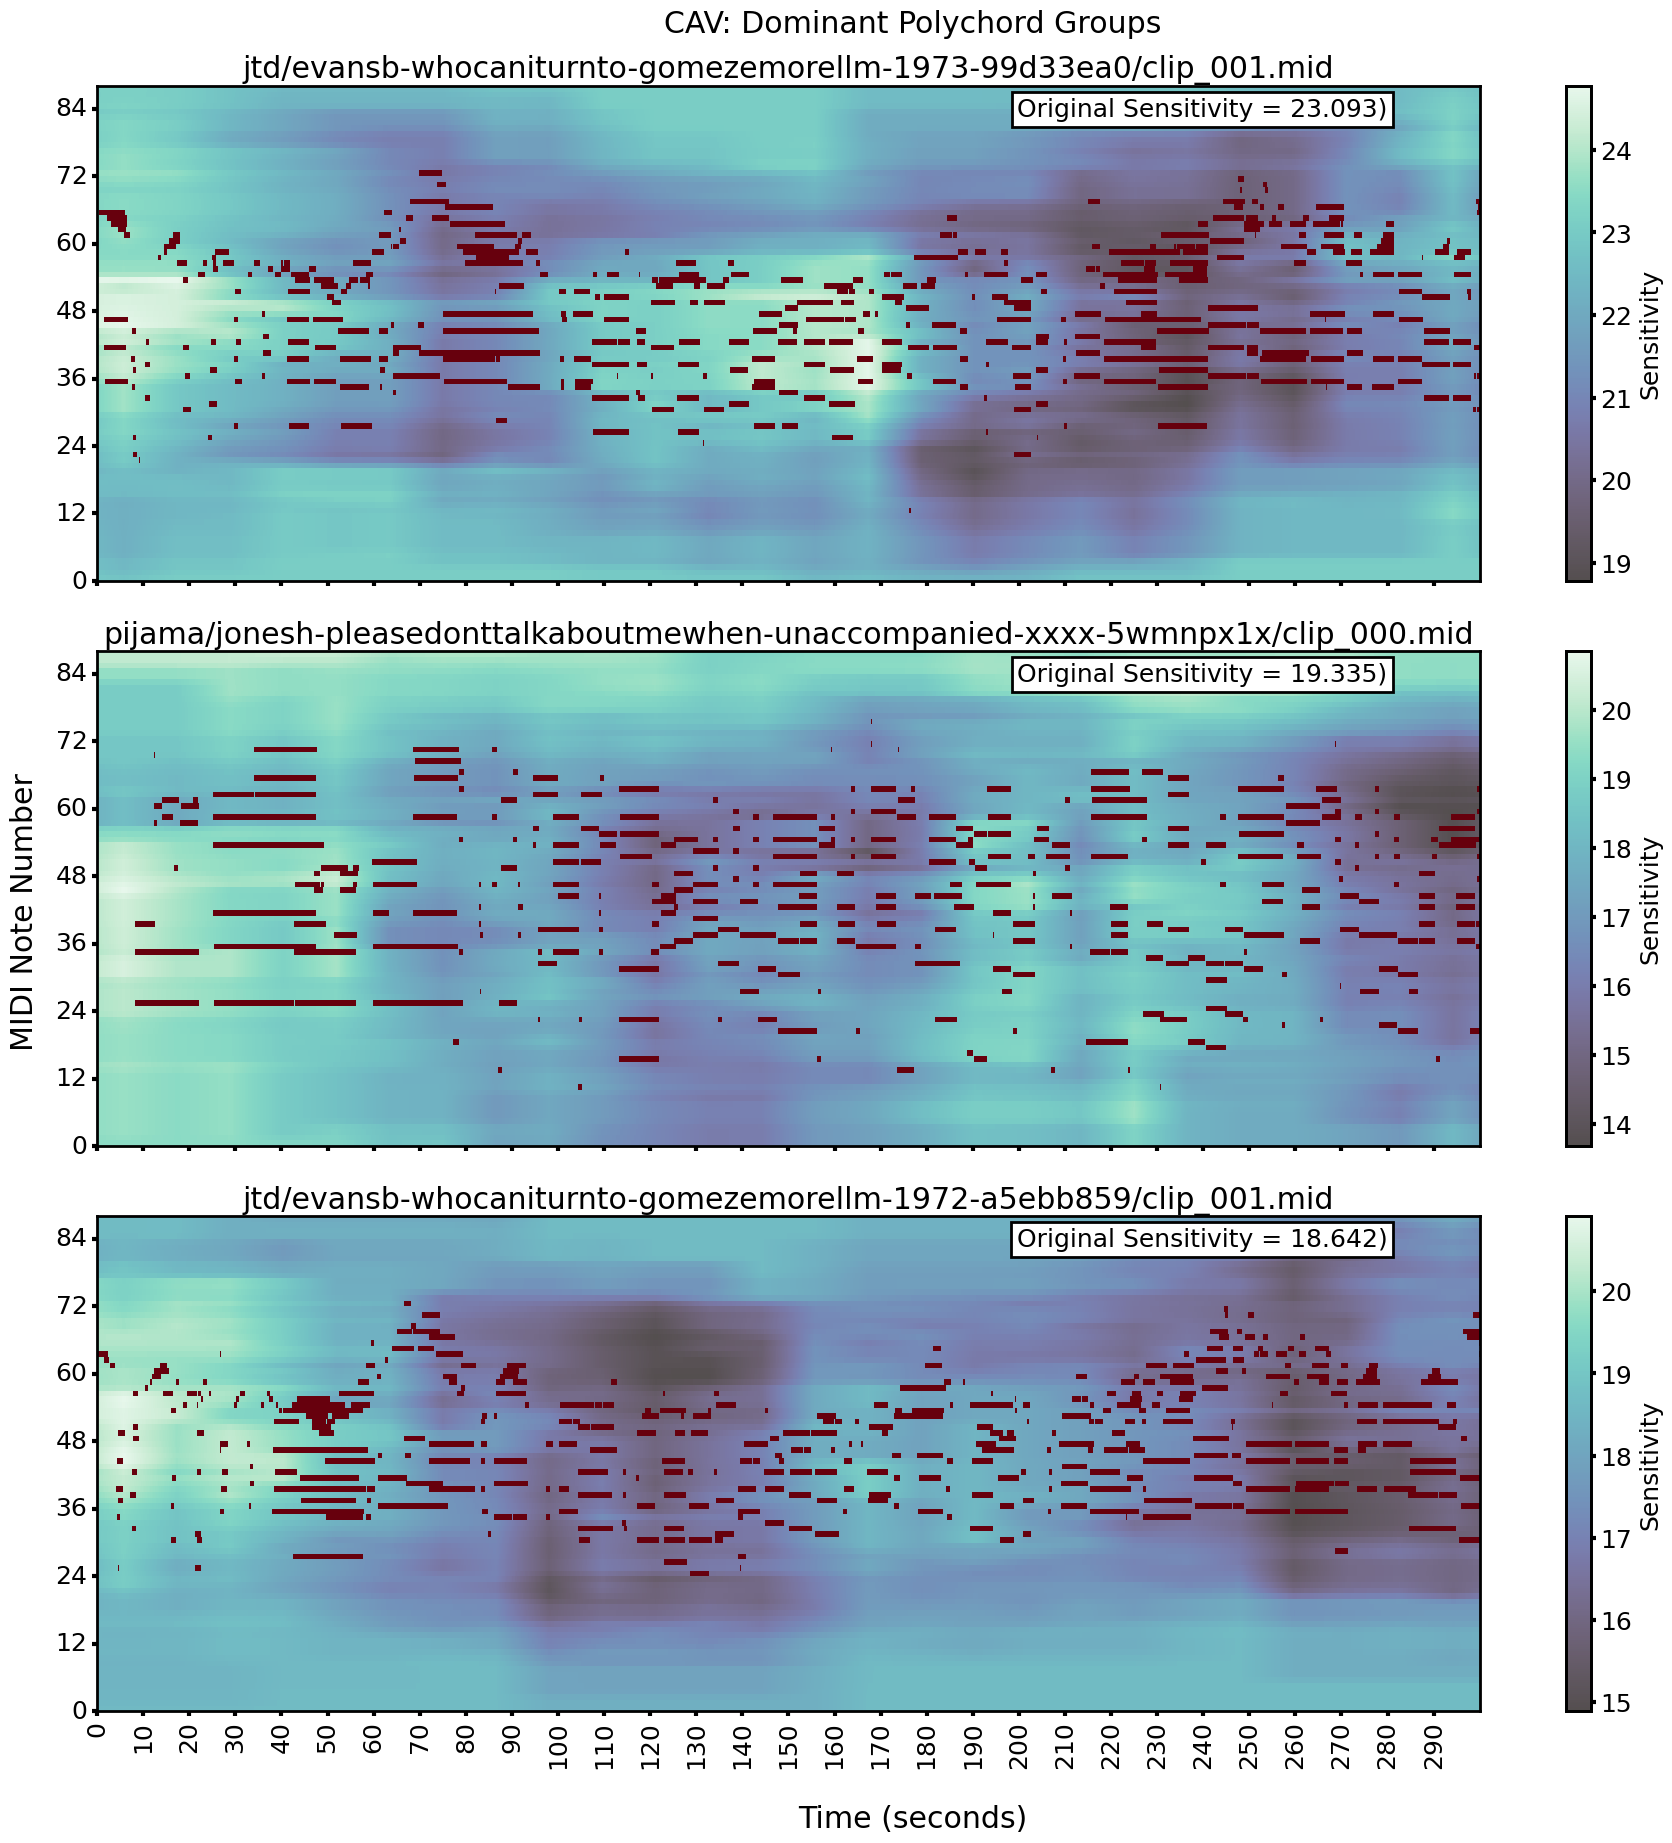

Diminished Substitutions pijama/coreac-childrenssong10-unaccompanied-xxxx-aa9tp8hq/clip_006.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Diminished Substitutions pijama/coreac-childrenssong10-unaccompanied-xxxx-aa9tp8hq/clip_007.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

Diminished Substitutions jtd/monkt-monksdream-mappgblakeya-1952-0526e904/clip_001.mid


Computing kernel sensitivities:   0%|          | 0/1690 [00:00<?, ?it/s]

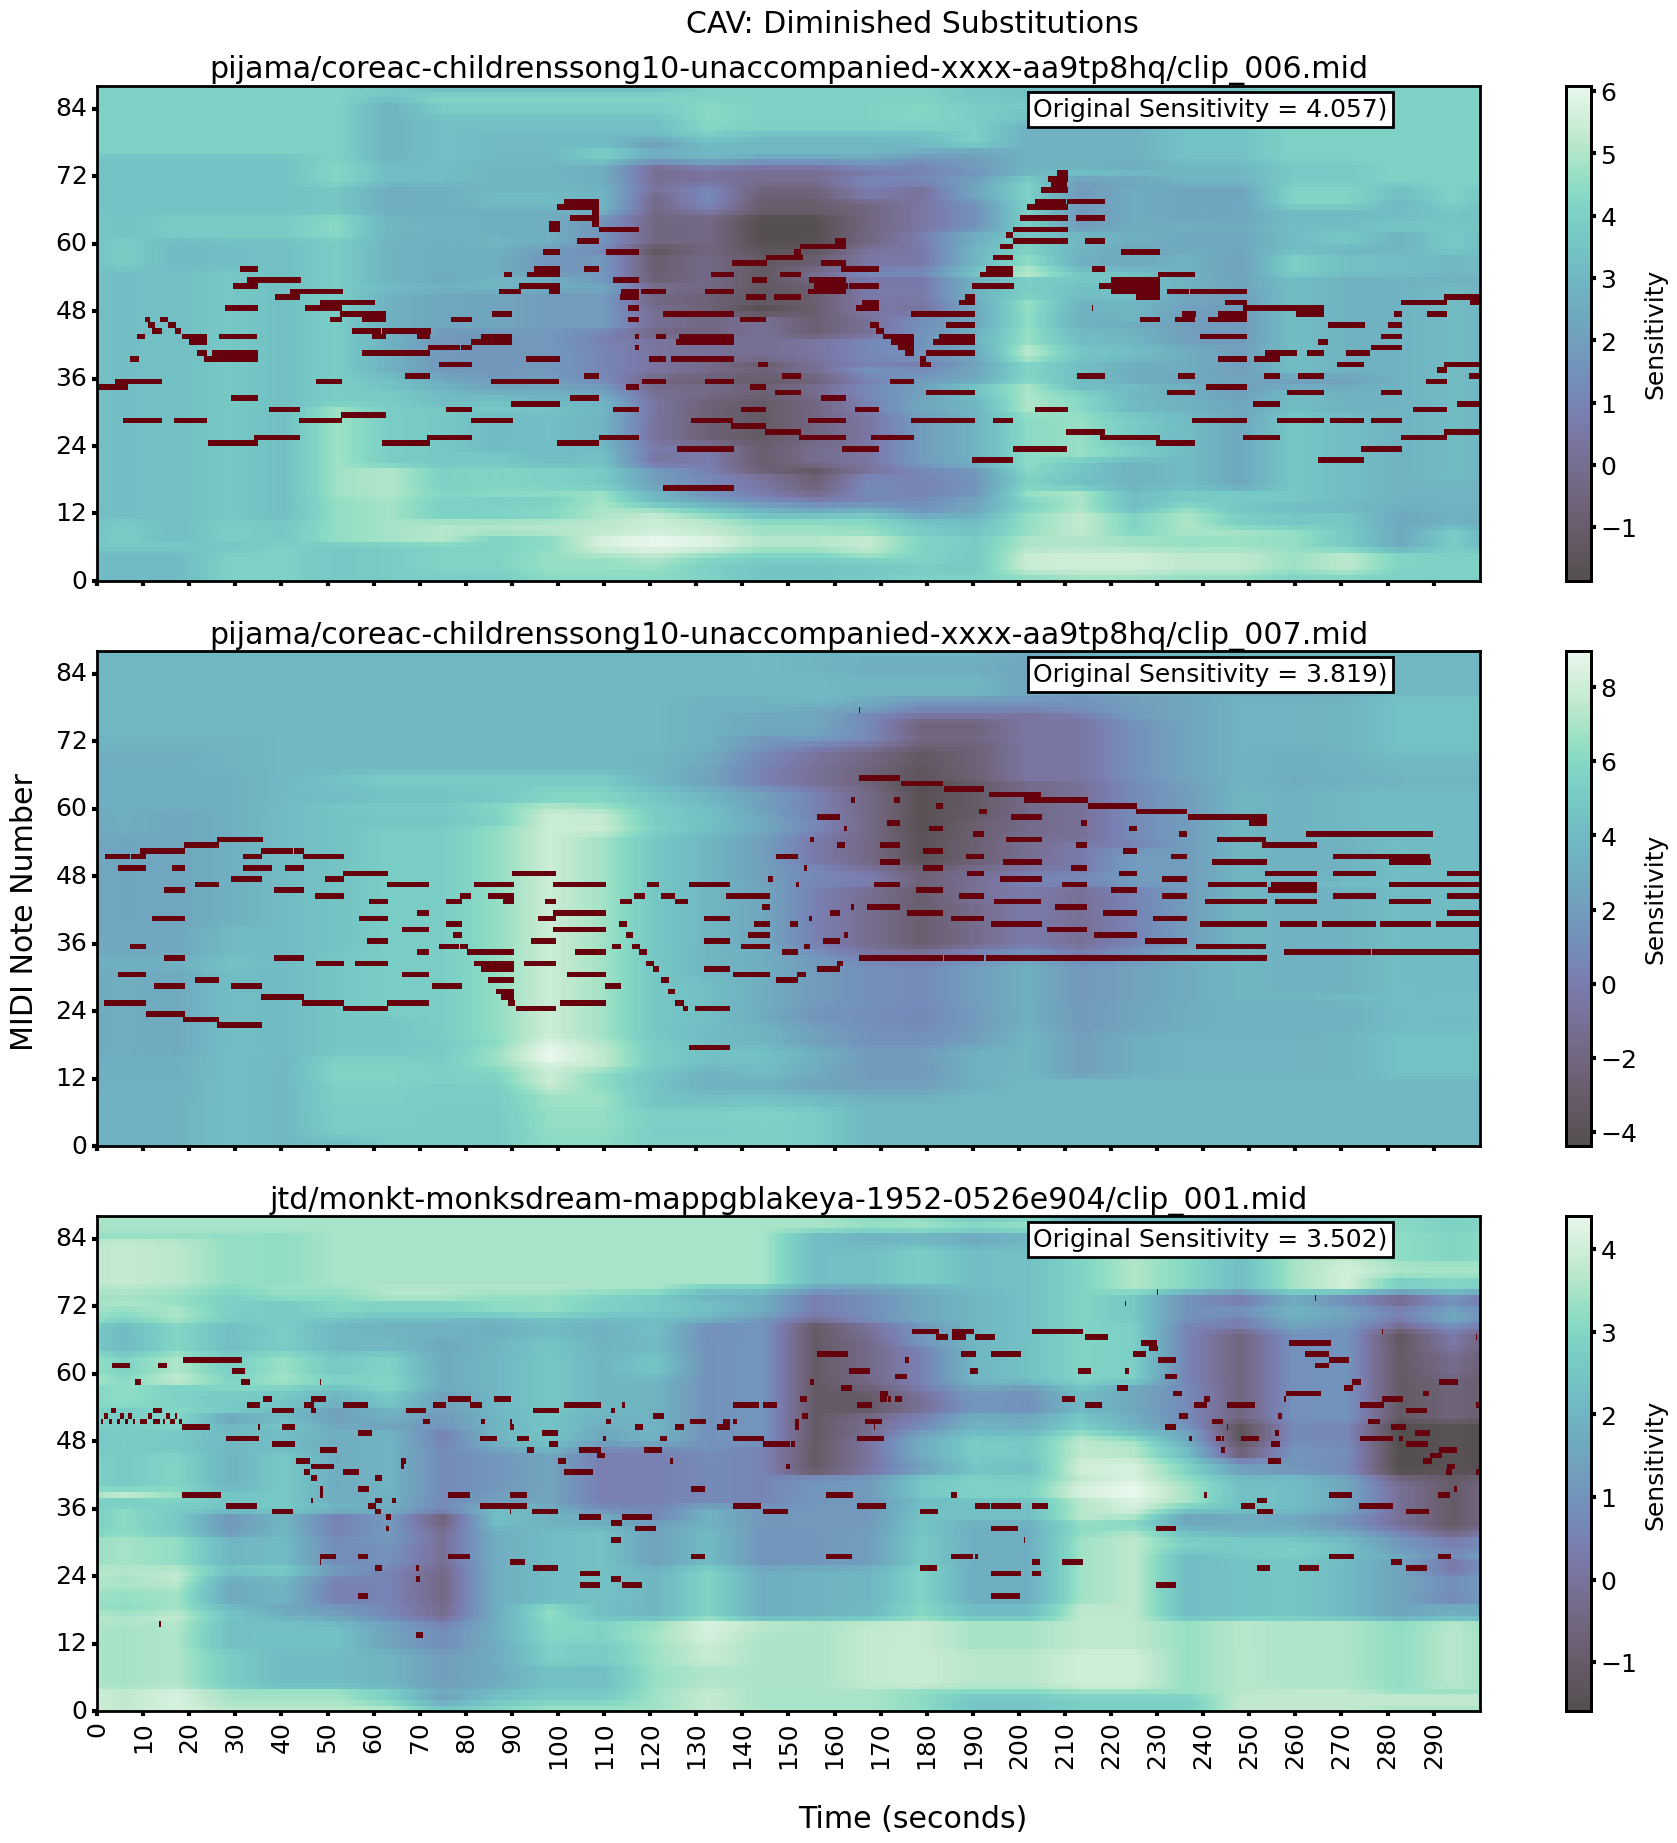

In [36]:
from copy import deepcopy
from deep_pianist_identification.extractors import HarmonyExtractor


def compute_sensitivity(rol, ca):
    try:
        extractor = HarmonyExtractor(rol).roll
        extractor[extractor != 0] = 1.
    except:
        return np.nan
    else:
        # Convert to tensor
        tens = torch.tensor(extractor).to(utils.DEVICE)
        # Get just the harmony roll and add the missing dimensions back in
        harm_roll = tens.unsqueeze(0).unsqueeze(0)
        # Forwards through the disentangled model
        with torch.no_grad():
            harm_embed = harmony_concept(harm_roll).squeeze(1).cpu().numpy()
        # Compute cav sensitivity at this kernel
        return harm_embed[0] @ ca


tn = np.array(track_names)
for i__, (cav_name, values, cav_coefs) in enumerate(zip(xticklabels, dotted.T, cavs)):
    fig, ax_ = plt.subplots(3, 1, figsize=(plotting.WIDTH, plotting.WIDTH), sharex=True, sharey=True)
    for k in [0, 1, 2]:
        # Get the idx of the 1 clip with the most CAV activation
        top1 = np.argsort(-values)[k]
        # Get the path of the clip
        clip_pather = tn[top1]
        # Load the PrettyMIDI object in
        print(cav_name, clip_pather)
        loaded = PrettyMIDI(os.path.join(utils.get_project_root(), 'data/clips', clip_pather))
        # Compute the original piano roll and the normal sensitivity
        original_roll = get_piano_roll([(i.start, i.end, i.pitch, 127) for i in loaded.instruments[0].notes])
        original_sensitivity = compute_sensitivity(loaded, cav_coefs)
        # Iterate through all of our kernels
        all_sensitivities = []
        for (v_low, v_hi), (h_low, h_hi) in tqdm(kernels, desc='Computing kernel sensitivities: '):
            temp = deepcopy(loaded)
            # Remove notes that are within the span of our kernel
            temp.instruments[0].notes = [
                n for n in temp.instruments[0].notes 
                if not (v_low <= n.pitch - utils.MIDI_OFFSET <= v_hi)
                or not any([(h_low <= n.start <= h_hi), (h_low <= n.end <= h_hi)])
            ]
            # Get the multichannel piano roll
            try:
                extractors = np.array(tm.test_loader.dataset.get_multichannel_piano_roll(temp))
            except:
                sensitivity_at_kernel = np.nan
            else:
                # Convert to tensor
                tens = torch.tensor(extractors).to(utils.DEVICE)
                # Get just the harmony roll and add the missing dimensions back in
                harm_roll = tens[1, :, :].unsqueeze(0).unsqueeze(0)
                # Forwards through the disentangled model
                with torch.no_grad():
                    harm_embed = harmony_concept(harm_roll).squeeze(1).cpu().numpy()
                # Compute cav sensitivity at this kernel
                sensitivity_at_kernel = harm_embed[0] @ cav_coefs
            finally:
                all_sensitivities.append(sensitivity_at_kernel)
        # Get the correct axis
        ax = ax_[k]
        # Create the background for the heatmap by resizing
        background = resize(
            np.array(all_sensitivities).reshape(65, 26), 
            (utils.PIANO_KEYS, utils.CLIP_LENGTH * utils.FPS)
        )
        sns.heatmap(background, ax=ax, alpha=0.7, cmap="mako", cbar_kws={'label': 'Sensitivity'})
        # Plot the original piano roll
        original_roll[original_roll == 0] = np.nan    # set 0 values to NaN to make transparent
        sns.heatmap(original_roll, ax=ax, alpha=1.0, cbar=None, cmap="Reds_r")
        # Plot aesthetics 
        ax.set(
            xticks=range(0, 3000, 100), xticklabels=range(0, 300, 10), yticks=range(0, utils.PIANO_KEYS, 12),
            yticklabels=range(0, utils.PIANO_KEYS, 12), title=tn[top1], xlabel="", ylabel=""
        )
        ax.text(
            2800, 86, f"Original Sensitivity = {round(original_sensitivity, 3)})",
            **dict(rotation=0, va='top', ha='right', fontsize=plotting.FONTSIZE),
            bbox=dict(
                facecolor=plotting.WHITE, alpha=1.0, linewidth=plotting.LINEWIDTH, edgecolor=plotting.BLACK,
            )
        )
        for a in [ax, ax.figure.axes[-1]]:
            for spine in a.spines.values():
                spine.set_visible(True)
                spine.set_color(plotting.BLACK)
                spine.set_linewidth(plotting.LINEWIDTH)
            plt.setp(a.spines.values(), linewidth=plotting.LINEWIDTH, color=plotting.BLACK)
            a.tick_params(axis='both', width=plotting.TICKWIDTH, color=plotting.BLACK)
    # Figure aesthetics
    ax_[0].invert_yaxis()
    fig.suptitle(f"CAV: {cav_name}")
    fig.supxlabel("Time (seconds)")
    fig.supylabel("MIDI Note Number")
    fig.tight_layout()
    # Save the figure
    for fmt in ["png"]:
        fp = os.path.join(utils.get_project_root(), "reports/figures", "cav_plots/voicings", cav_name.lower().replace(" ", "_") + f".{fmt}")
        fig.savefig(fp, format=fmt, facecolor=plotting.WHITE)
    plt.show()


Regression model predicting recording year (and dataset?) from CAV activation